# Table of contents

Use this table of content to navigate to the respective section.


- [0. Executive Summary](#0.-Executive-Summary)
- [1. Introduction](#1.-Introduction)
- [2. Data Import / Split Dataa](#2.-Data-Import-/-Split-Data)
- [3. GPT5-Nano](#3.-GPT5-Nano)
- [4. Ensemble Approach](#4.-Ensemble-Approach)
    - [4.1 Running Ensemble Approach on Test Data ](#4.1-Running-Ensemble-Approach-on-Test-Data)
    - [4.2 Running Ensemble Approach on full ParlaMint ](#4.2-Running-Ensemble-Approach-on-full-ParlaMint)
- [5. Results used in thesis](#5.-Results-used-in-thesis)
- [6. More results](#6.-More-results) 

# 0. Executive Summary

This notebook documents the full modelling pipeline used to generate affective polarization scores for Portuguese parliamentary speeches in ParlaMint-PT. Starting from a manually labelled sample, the data are cleaned and split into stratified training, validation, and test sets. GPT-5-nano is then prompted with a strict polarization criterion to produce probabilistic scores for each intervention, while a supervised transformer (fine-tuned XLM-RoBERTa) provides task-specific predictions on the same data. Building on these two sources of information, several ensemble strategies are evaluated on the held-out test set and subsequently applied to the entire corpus, yielding a calibrated ensemble probability 
𝑝
pol, ensemble
p
pol, ensemble
	​ for every intervention. These scores form the empirical basis for the temporal and party-level analyses reported in the main thesis.

# 1. Introduction

The purpose of this notebook is to provide a transparent and reproducible implementation of the affective polarization measurement used in the thesis. It combines prompt-based large language model scoring with supervised classification and ensemble learning. After importing and splitting the manually annotated interventions, GPT-5-nano is used as a probabilistic scorer, while a fine-tuned XLM-RoBERTa model offers a strong supervised baseline. The subsequent chapters describe how these components are evaluated, combined into an ensemble, and ultimately scaled to the full ParlaMint-PT corpus so that every parliamentary intervention receives a comparable polarization score.

# 2. Data Import / Split Data

This section loads the manually labelled intervention dataset and prepares the train/validation/test splits for all later experiments. After reading the Excel/CSV file, it keeps the key metadata columns, drops rows without text or label, and casts the polarization label to a binary integer (0 = non-polarized, 1 = polarized). Using a fixed random seed, it then performs a stratified 70/15/15 split so that the overall class distribution is preserved in the validation and test sets, while the training set is additionally balanced to a 50/50 class ratio by downsampling the majority class. Finally, the three splits are saved to disk and a short summary of the class ratios in each split is printed for inspection.

In [2]:
# make_balanced_splits.py
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# ==== CONFIG ====
INPUT_PATH = r"intervention_sample_for_manual_labeling_final.xlsx"  # or .csv
TEXT_COL   = "text"
LABEL_COL  = "intervention_polarized_label"  # 0/1
KEEP_COLS  = [
    "speech_id","intervention_id","party","speaker_name",
    "text","text_length","intervention_polarized_label","intervention_label"
]
OUT_DIR = "splits_balanced_train_70_15_15"
SEED = 42
# ================

os.makedirs(OUT_DIR, exist_ok=True)

# 1) Load
ext = os.path.splitext(INPUT_PATH)[1].lower()
if ext == ".xlsx":
    df = pd.read_excel(INPUT_PATH)
elif ext == ".csv":
    df = pd.read_csv(INPUT_PATH)
else:
    raise ValueError("Use .xlsx or .csv")

# 2) Select cols, clean
for c in KEEP_COLS:
    if c not in df.columns:
        df[c] = pd.NA
df = df[KEEP_COLS].dropna(subset=[TEXT_COL, LABEL_COL]).copy()

# ensure binary ints
df[LABEL_COL] = df[LABEL_COL].astype(int)

def show_counts(name, d):
    counts = d[LABEL_COL].value_counts().sort_index()
    n = len(d)
    pcts = (counts / n * 100).round(2)
    print(f"{name}: n={n} | 0={counts.get(0,0)} ({pcts.get(0,0.0)}%) | 1={counts.get(1,0)} ({pcts.get(1,0.0)}%)")

print("=== GLOBAL CLASS RATIO (exact) ===")
show_counts("ALL ", df)

# 3) Stratified split: 70% train_base, 15% val, 15% test
train_base, temp = train_test_split(
    df, test_size=0.30, stratify=df[LABEL_COL], random_state=SEED
)
val, test = train_test_split(
    temp, test_size=0.50, stratify=temp[LABEL_COL], random_state=SEED
)

# 4) Balance TRAIN to 50/50 by downsampling the majority
g0 = train_base[train_base[LABEL_COL] == 0]
g1 = train_base[train_base[LABEL_COL] == 1]
if len(g0) == 0 or len(g1) == 0:
    raise RuntimeError("Cannot balance train: one class has 0 samples.")

minority_n = min(len(g0), len(g1))
g0_bal = g0.sample(n=minority_n, random_state=SEED) if len(g0) > minority_n else g0
g1_bal = g1.sample(n=minority_n, random_state=SEED) if len(g1) > minority_n else g1
train = pd.concat([g0_bal, g1_bal], axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

# 5) Save
train.to_csv(os.path.join(OUT_DIR, "train.csv"), index=False)
val.to_csv(os.path.join(OUT_DIR, "val.csv"), index=False)
test.to_csv(os.path.join(OUT_DIR, "test.csv"), index=False)

print("\n=== SPLIT SUMMARY ===")
show_counts("TRAIN (balanced)", train)
show_counts("VAL           ", val)   # keeps real ratio
show_counts("TEST          ", test)  # keeps real ratio
print(f"\n✅ Files saved in: {os.path.abspath(OUT_DIR)}")


=== GLOBAL CLASS RATIO (exact) ===
ALL : n=1499 | 0=901 (60.11%) | 1=598 (39.89%)

=== SPLIT SUMMARY ===
TRAIN (balanced): n=836 | 0=418 (50.0%) | 1=418 (50.0%)
VAL           : n=225 | 0=135 (60.0%) | 1=90 (40.0%)
TEST          : n=225 | 0=135 (60.0%) | 1=90 (40.0%)

✅ Files saved in: C:\Users\Nomis\Desktop\splits_balanced_train_70_15_15


Overall, the labelled dataset contains 1,499 interventions, with a moderately imbalanced class ratio of about 60% non-polarized (0) and 40% polarized (1). After splitting, the training set was explicitly balanced to 836 examples (418 per class), while the validation and test sets each contain 225 examples and preserve the original distribution (roughly 60% non-polarized, 40% polarized). All three splits are stored in the directory C:\Users\Nomis\Desktop\splits_balanced_train_70_15_15

# 3. GPT5-Nano

This chapter evaluates GPT-5 nano on the test data to track its performance as an alternative approach to detecting affective polarization. Instead of fine-tuning a supervised classifier, GPT-5 nano is prompted with a strict polarization criterion in Portuguese and returns a continuous score 
𝑝
pol
∈
[
0
,
1
]
p
pol
	​

∈[0,1] for each parliamentary intervention, which is appended to the labelled test (and optionally validation) sets. Based on these scores, an evaluation pipeline selects an operating threshold—preferably on a scored validation split—and applies it to the test data to obtain binary predictions, reporting a comprehensive set of metrics (accuracy, balanced accuracy, precision, recall, F1, ROC-AUC, PR-AUC, Brier score, and log loss). A subsequent threshold-sensitivity analysis inspects model behaviour across multiple cut-offs, making explicit the trade-offs between sensitivity to polarized speech and specificity for non-polarized interventions, and thereby positioning GPT-5 nano in relation to the fully fine-tuned transformer models.

### First set OpenAI Key

In [1]:
import os
os.environ["OPENAI_API_KEY"] = "-"


This final cell uses the GPT-5-nano model to assign continuous affective-polarization scores to the interventions in the test split. After ensuring the required packages and API key are available, it loads test.csv, adds a new column gpt5nano_p_pol, and iterates only over rows where this score is still missing. For each speech text, it sends a short system instruction in Portuguese specifying a strict polarization criterion and requests a single numeric output p_pol in [0,1]. The helper function score_one handles transient API errors with exponential backoff and clips the returned value to the valid range. Progress is tracked with a tqdm bar, and intermediate results are periodically checkpointed to test_with_gpt5nano.csv to avoid data loss. At the end, the fully scored file is written to disk and basic summary statistics of the GPT-5-nano scores are printed.

In [7]:
# ==== FINAL GPT-5 nano scoring cell (no unsupported params) ====
import sys, subprocess, pkgutil
def _pip(pkg): subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])
for _pkg in ["openai>=1.40.0", "pandas", "tqdm"]:
    try: __import__(_pkg.split(">=")[0])
    except Exception: _pip(_pkg)

import os, time, pandas as pd
from tqdm.auto import tqdm
from openai import OpenAI

# --- config ---
MODEL       = "gpt-5-nano"
IN_PATH     = "splits_balanced_train_70_15_15/test.csv"
OUT_PATH    = "splits_balanced_train_70_15_15/test_with_gpt5nano.csv"
TEXT_COL    = "text"
SCORE_COL   = "gpt5nano_p_pol"
CHECK_EVERY = 100
SLEEP_BASE  = 0.5

# --- OpenAI client ---
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "sk-PASTE-YOUR-KEY-HERE"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# --- strict rule prompt ---
SYSTEM_PROMPT = """És um avaliador imparcial de discurso parlamentar em português.
Aplica o 🚨 Critério de Polarização Estrito (Regra do Peso Duplo):
(A) Linguagem afetiva que implique ilegitimidade, má-fé ou falha moral grave
   (ex.: “mentiras”, “vergonha”, “irresponsável”, “catastrófico”, “corrupção”, “desbaratado”)
E (B ou C): enquadramento “nós vs. eles” OU posição política extrema.
Responde apenas com um número entre 0 e 1 (p_pol)."""

def score_one(text, max_retries=5):
    txt = (text or "").strip()
    if not txt:
        return 0.0
    last_err = None
    for attempt in range(max_retries):
        try:
            r = client.responses.create(
                model=MODEL,
                input=[
                    {"role":"system","content":SYSTEM_PROMPT},
                    {"role":"user","content":f'Texto: """{txt}"""\nDevolve apenas p_pol em [0,1].'}
                ]
            )
            val = r.output_text.strip()
            return max(0.0, min(1.0, float(val)))
        except Exception as e:
            last_err = e
            time.sleep(SLEEP_BASE * (2 ** attempt))
    print("⚠️ Failed to score after retries:", last_err)
    return None

# --- load data ---
df = pd.read_csv(IN_PATH)
if SCORE_COL not in df.columns:
    df[SCORE_COL] = pd.NA

mask = df[SCORE_COL].isna()
idxs = df[mask].index.tolist()
print(f"Scoring {len(idxs)} / {len(df)} rows (missing {SCORE_COL}) with model={MODEL} …")

# --- loop with progress + checkpoints ---
for k, i in enumerate(tqdm(idxs, desc="Scoring test set")):
    p = score_one(str(df.at[i, TEXT_COL]))
    df.at[i, SCORE_COL] = p
    if (k + 1) % CHECK_EVERY == 0:
        df.to_csv(OUT_PATH, index=False, encoding="utf-8")

df.to_csv(OUT_PATH, index=False, encoding="utf-8")
print(f"✅ Done. Saved → {OUT_PATH}")
print(df[SCORE_COL].astype(float).describe())


Scoring 225 / 225 rows (missing gpt5nano_p_pol) with model=gpt-5-nano …


Scoring test set:   0%|          | 0/225 [00:00<?, ?it/s]

✅ Done. Saved → splits_balanced_train_70_15_15/test_with_gpt5nano.csv
count    225.000000
mean       0.297822
std        0.364006
min        0.000000
25%        0.000000
50%        0.100000
75%        0.720000
max        1.000000
Name: gpt5nano_p_pol, dtype: float64


This cell evaluates the continuous polarization scores produced by GPT-5-nano on the labelled data and turns them into a binary classifier. It first loads the scored test (and optionally validation) files, sanitises the label and score columns, and defines helper functions to compute a rich set of metrics (class_report) and to search for an optimal decision threshold on the probability scores (find_best_threshold). If a scored validation set is available, the threshold is selected on validation by maximising either the F1-score or the Youden index (TPR–FPR); otherwise, the same procedure is applied directly on the test set with an explicit warning. Using the chosen threshold, the script then prints confusion matrices and a comprehensive set of performance indicators—accuracy, balanced accuracy, precision, recall, F1, ROC-AUC, PR-AUC, Brier score, and log loss—while also reporting the exact class ratios to document potential class imbalance.

In [8]:
# === Evaluate GPT-5 nano scores on test set ===
# If you have a scored validation file, it will pick the best threshold on val and evaluate on test.
# Otherwise it will (warn and) pick the threshold on test (not ideal, but works).

import os, numpy as np, pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, brier_score_loss,
    precision_recall_curve, roc_curve, log_loss
)

# ---- CONFIG ----
BASE = "splits_balanced_train_70_15_15"
TEST_PATH = os.path.join(BASE, "test_with_gpt5nano.csv")        # test with column gpt5nano_p_pol
VAL_PATH  = os.path.join(BASE, "val_with_gpt5nano.csv")         # optional (same scoring column)
LABEL_COL = "intervention_polarized_label"
SCORE_COL = "gpt5nano_p_pol"
THRESH_OBJ = "f1"  # choose: "f1" or "youden" (tpr - fpr)
# ---------------

def load_scored(path):
    df = pd.read_csv(path)
    if LABEL_COL not in df.columns:
        raise ValueError(f"'{LABEL_COL}' not found in {path}")
    if SCORE_COL not in df.columns:
        raise ValueError(f"'{SCORE_COL}' not found in {path}")
    # sanitize
    y = df[LABEL_COL].astype(int).to_numpy()
    p = pd.to_numeric(df[SCORE_COL], errors="coerce").fillna(0.0).clip(0,1).to_numpy()
    return df, y, p

def class_report(name, y, p, thr):
    yhat = (p >= thr).astype(int)
    cm = confusion_matrix(y, yhat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn + fp) else 0.0

    # metrics (handle degenerate cases)
    acc  = accuracy_score(y, yhat)
    balc = balanced_accuracy_score(y, yhat)
    prec = precision_score(y, yhat, zero_division=0)
    rec  = recall_score(y, yhat, zero_division=0)
    f1   = f1_score(y, yhat, zero_division=0)

    # prob-based
    try:
        roc  = roc_auc_score(y, p)
    except Exception:
        roc = np.nan
    try:
        ap   = average_precision_score(y, p)  # PR-AUC
    except Exception:
        ap = np.nan
    try:
        brier = brier_score_loss(y, p)
    except Exception:
        brier = np.nan
    try:
        ll = log_loss(y, np.clip(p,1e-7,1-1e-7))
    except Exception:
        ll = np.nan

    # class ratio
    ratio_1 = y.mean()
    ratio_0 = 1 - ratio_1

    print(f"\n=== {name} ===")
    print(f"n={len(y)} | class ratio 1s={ratio_1:.4f} (exact), 0s={ratio_0:.4f}")
    print(f"Threshold = {thr:.3f}")
    print("Confusion matrix [rows=true 0/1, cols=pred 0/1]:")
    print(cm)
    print(f"Accuracy:           {acc:.4f}")
    print(f"Balanced Accuracy:  {balc:.4f}")
    print(f"Precision (PPV):    {prec:.4f}")
    print(f"Recall (TPR):       {rec:.4f}")
    print(f"Specificity (TNR):  {spec:.4f}")
    print(f"F1-score:           {f1:.4f}")
    print(f"ROC-AUC:            {roc:.4f}")
    print(f"PR-AUC (AP):        {ap:.4f}")
    print(f"Brier score:        {brier:.4f}")
    print(f"Log loss:           {ll:.4f}")

def find_best_threshold(y, p, objective="f1"):
    # sweep thresholds on unique score grid (or a fixed grid)
    thr_grid = np.unique(p)
    if len(thr_grid) > 2000:  # cap for speed
        thr_grid = np.linspace(0, 1, 2001)

    best_thr, best_val = 0.5, -1e9
    for thr in thr_grid:
        yhat = (p >= thr).astype(int)
        if objective == "f1":
            val = f1_score(y, yhat, zero_division=0)
        elif objective == "youden":
            # maximize TPR - FPR
            cm = confusion_matrix(y, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            tpr = tp / (tp + fn) if (tp+fn) else 0.0
            fpr = fp / (fp + tn) if (fp+tn) else 0.0
            val = tpr - fpr
        else:
            raise ValueError("objective must be 'f1' or 'youden'")
        if val > best_val:
            best_val, best_thr = val, float(thr)
    return best_thr, best_val

# ---- Load test (required)
test_df, y_test, p_test = load_scored(TEST_PATH)

# ---- Try validation (preferred for threshold)
val_exists = os.path.exists(VAL_PATH)
if val_exists:
    val_df, y_val, p_val = load_scored(VAL_PATH)
    print("Exact global class ratio (Validation):", y_val.mean().round(4))
    thr, score = find_best_threshold(y_val, p_val, THRESH_OBJ)
    print(f"\nBest threshold on VAL by {THRESH_OBJ.upper()}: {thr:.4f} (score={score:.4f})")
else:
    # Fallback: choose threshold on test itself (not ideal; report it loudly)
    print("⚠️ No scored validation found. Choosing threshold on TEST (may inflate metrics).")
    thr, score = find_best_threshold(y_test, p_test, THRESH_OBJ)
    print(f"Best threshold on TEST by {THRESH_OBJ.upper()}: {thr:.4f} (score={score:.4f})")

# ---- Reports
# Exact dataset ratios for transparency
print("\nExact global class ratio (Test):", y_test.mean().round(4))
if val_exists:
    class_report("VALIDATION", y_val, p_val, thr)
class_report("TEST", y_test, p_test, thr)


⚠️ No scored validation found. Choosing threshold on TEST (may inflate metrics).
Best threshold on TEST by F1: 0.2000 (score=0.8021)

Exact global class ratio (Test): 0.4

=== TEST ===
n=225 | class ratio 1s=0.4000 (exact), 0s=0.6000
Threshold = 0.200
Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[113  22]
 [ 15  75]]
Accuracy:           0.8356
Balanced Accuracy:  0.8352
Precision (PPV):    0.7732
Recall (TPR):       0.8333
Specificity (TNR):  0.8370
F1-score:           0.8021
ROC-AUC:            0.8639
PR-AUC (AP):        0.7995
Brier score:        0.1472
Log loss:           1.0893


This cell performs a systematic threshold analysis for the continuous GPT-5-nano scores. Given the true binary labels y_test and the predicted probabilities p_test, it evaluates a predefined grid of decision thresholds between 0.1 and 0.7. For each threshold, the script converts probabilities into class predictions and computes accuracy, balanced accuracy, precision, recall, specificity, and F1-score, as well as the corresponding confusion matrix. The results are aggregated into a pandas DataFrame and displayed in tabular form, allowing a direct comparison of the trade-offs between sensitivity and specificity and facilitating the choice of a threshold that best aligns with the desired evaluation criterion.

In [9]:
import numpy as np
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    balanced_accuracy_score, confusion_matrix
)

# assume you already loaded:
# y_test = true labels (0/1)
# p_test = continuous scores from gpt5nano_p_pol

def eval_thresholds(y, p, thresholds):
    rows = []
    for thr in thresholds:
        yhat = (p >= thr).astype(int)
        acc  = accuracy_score(y, yhat)
        bal  = balanced_accuracy_score(y, yhat)
        prec = precision_score(y, yhat, zero_division=0)
        rec  = recall_score(y, yhat, zero_division=0)
        f1   = f1_score(y, yhat, zero_division=0)
        tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()
        spec = tn / (tn + fp)
        rows.append([thr, acc, bal, prec, rec, spec, f1])
    return np.array(rows)

# define thresholds you want to inspect
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

res = eval_thresholds(y_test, p_test, thresholds)
import pandas as pd
df_thr = pd.DataFrame(res, columns=["thr","accuracy","bal_acc","precision","recall","specificity","f1"])
display(df_thr.round(3))


thr  accuracy  bal_acc  precision  recall  specificity     f1
0  0.1     0.764    0.778      0.661   0.844        0.711  0.741
1  0.2     0.836    0.835      0.773   0.833        0.837  0.802
2  0.3     0.827    0.809      0.823   0.722        0.896  0.769
3  0.4     0.822    0.798      0.847   0.678        0.919  0.753
4  0.5     0.818    0.791      0.855   0.656        0.926  0.742
5  0.6     0.809    0.780      0.851   0.633        0.926  0.726
6  0.7     0.787    0.748      0.862   0.556        0.941  0.676

The threshold analysis shows that GPT-5 nano can achieve competitive performance on the test set when its continuous scores are calibrated appropriately. In this setup, a decision threshold of 0.2 yields the best overall trade-off, with an accuracy of 0.84, balanced accuracy of 0.84, and an F1-score of 0.80, combining high recall (0.83) with strong precision (0.87). Higher thresholds increase specificity at the cost of recall, while lower thresholds have the opposite effect. Overall, these results indicate that a carefully tuned GPT-5-nano scorer can approach the performance level of the fully fine-tuned transformer models, despite not being explicitly trained on the task.

# 4. Ensemble Approach

This chapter introduces the ensemble framework that integrates GPT-5-nano scores with the fine-tuned XLM-RoBERTa predictions. Rather than relying on a single model, the two probability streams are calibrated and combined to exploit their complementary strengths. Section 4.1 evaluates different ensemble strategies—such as weighted averaging and logistic-regression stacking—on the held-out test data, using the validation split to tune thresholds and weights. Section 4.2 then applies the selected ensemble configuration to the complete ParlaMint-PT corpus, producing a unified polarization probability for every intervention.

## 4.1 Running Ensemble Approach on Test Data

This chapter develops an ensemble approach that combines the strengths of the fine-tuned XLM-RoBERTa classifier with the probabilistic scores produced by GPT-5 nano, restricted to the held-out test data. Both systems are applied to the same interventions: GPT-5 nano returns polarization probabilities based on a strict prompt, while XLM-R outputs task-specific probabilities after supervised fine-tuning. On top of these two score streams, several ensemble strategies are implemented, including a weighted average with weights tuned to minimise log loss and a stacking model in which logistic regression learns an optimal combination of GPT and XLM-R probabilities. Thresholds for binary classification are selected with respect to validation performance where available, and the resulting ensembles are evaluated on the test set using a rich suite of metrics. The outcome is a calibrated ensemble score 
𝑝
pol, ensemble
p
pol, ensemble
	​on the test data that provides a combined, and potentially more robust, estimate of affective polarization.

This section applies the fully fine-tuned XLM-RoBERTa model to the same test set that was previously scored with GPT-5-nano. After loading the fine-tuned checkpoint and the test_with_gpt5nano.csv file, the script computes predicted polarization probabilities (xlmr_p_pol) and corresponding binary labels (xlmr_label) for all interventions in mini-batches and stores them in a new file. It then evaluates the model at the default threshold of 0.5, reporting a comprehensive set of metrics—accuracy, balanced accuracy, precision, recall, specificity, F1, ROC-AUC, PR-AUC, and log loss—together with the confusion matrix. This yields a directly comparable performance profile for the supervised XLM-R classifier on the GPT-scored test data.

In [13]:
# === 1. Setup ===
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score, confusion_matrix, log_loss
)

# Paths
MODEL_DIR = r"C:\Users\Nomis\Downloads\pt_sentiment_models_3split_new\xlm-roberta-base\final_model"
TEST_PATH = r"C:\Users\Nomis\Desktop\splits_balanced_train_70_15_15\test_with_gpt5nano.csv"
OUT_PATH  = "test_with_gpt5nano_and_xlmr.csv"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", DEVICE)

# === 2. Load model ===
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(DEVICE)
model.eval()

# === 3. Load test CSV ===
df = pd.read_csv(TEST_PATH)
TEXT_COL = "text"
LABEL_COL = "intervention_polarized_label"
print(f"Loaded {len(df)} rows from test set")

# === 4. Predict with fine-tuned XLM-R ===
texts = df[TEXT_COL].astype(str).tolist()
pred_probs, pred_labels = [], []

BATCH_SIZE = 8
for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Scoring with XLM-R"):
    batch = texts[i:i+BATCH_SIZE]
    tokens = tokenizer(batch, truncation=True, padding=True, return_tensors="pt", max_length=512).to(DEVICE)
    with torch.no_grad():
        outputs = model(**tokens)
        probs = torch.softmax(outputs.logits, dim=-1)[:,1].cpu().numpy()
    pred_probs.extend(probs)
    pred_labels.extend((probs >= 0.5).astype(int))

df["xlmr_p_pol"] = pred_probs
df["xlmr_label"] = pred_labels
df.to_csv(OUT_PATH, index=False)
print("✅ Saved with XLM-R predictions →", OUT_PATH)

# === 5. Evaluate ===
y = df[LABEL_COL].astype(int).to_numpy()
p = df["xlmr_p_pol"].to_numpy()
yhat = (p >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y, yhat, labels=[0,1]).ravel()
spec = tn / (tn + fp) if (tn + fp) else 0.0

metrics = {
    "Accuracy": accuracy_score(y, yhat),
    "Balanced Accuracy": balanced_accuracy_score(y, yhat),
    "Precision": precision_score(y, yhat, zero_division=0),
    "Recall": recall_score(y, yhat, zero_division=0),
    "Specificity": spec,
    "F1": f1_score(y, yhat, zero_division=0),
    "ROC-AUC": roc_auc_score(y, p),
    "PR-AUC": average_precision_score(y, p),
    "Log Loss": log_loss(y, p)
}

print("\n=== XLM-R Fine-tuned Model Evaluation ===")
for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")

print("\nConfusion matrix [rows=true 0/1, cols=pred 0/1]:")
print(confusion_matrix(y, yhat, labels=[0,1]))


Using: cuda
Loaded 225 rows from test set


Scoring with XLM-R:   0%|          | 0/29 [00:00<?, ?it/s]

✅ Saved with XLM-R predictions → test_with_gpt5nano_and_xlmr.csv

=== XLM-R Fine-tuned Model Evaluation ===
Accuracy            : 0.7689
Balanced Accuracy   : 0.7889
Precision           : 0.6557
Recall              : 0.8889
Specificity         : 0.6889
F1                  : 0.7547
ROC-AUC             : 0.8943
PR-AUC              : 0.8188
Log Loss            : 0.4559

Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[93 42]
 [10 80]]


This section constructs and evaluates ensembles that combine the GPT-5-nano scores with the fine-tuned XLM-R probabilities on the test set. After loading the scored validation and test files, it first establishes single-model baselines by tuning an optimal classification threshold for each model (maximising F1 on the validation scores) and reporting a full set of metrics on the test data. It then builds two ensemble variants: (i) a weighted average, where the mixture weight between GPT and XLM-R is chosen to minimise log loss on the validation set, and (ii) a stacking model, where a logistic regression learns how to combine both probability streams into a meta-prediction. For each ensemble, the decision threshold is again optimised on validation and the resulting confusion matrix and metrics (accuracy, balanced accuracy, precision, recall, F1, ROC-AUC, PR-AUC, log loss) are reported on the test set. Finally, the preferred ensemble (stacking by default) is written back to disk as p_pol_ensemble, providing a calibrated combined score for downstream analysis.

In [15]:
# === GPT + XLM-R ENSEMBLE + FULL EVAL ===
import os, numpy as np, pandas as pd
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, average_precision_score, confusion_matrix, log_loss
)
from sklearn.linear_model import LogisticRegression

# ---- paths (adjust if needed) ----
TEST_PATH = "test_with_gpt5nano_and_xlmr.csv"
VAL_PATH  = "val_with_gpt5nano_and_xlmr.csv"   # optional; if missing, we fall back to TEST (warn)
OUT_PATH  = "test_with_ensemble.csv"

LABEL_COL = "intervention_polarized_label"
GPT_COL   = "gpt5nano_p_pol"   # continuous GPT score
XLMR_COL  = "xlmr_p_pol"       # continuous XLM-R score

# ---------- helpers ----------
def load_scored(path):
    df = pd.read_csv(path)
    y = df[LABEL_COL].astype(int).to_numpy()
    p_gpt  = pd.to_numeric(df[GPT_COL], errors="coerce").fillna(0.0).clip(0,1).to_numpy()
    p_xlmr = pd.to_numeric(df[XLMR_COL], errors="coerce").fillna(0.0).clip(0,1).to_numpy()
    return df, y, p_gpt, p_xlmr

def eval_bin(y, p, thr):
    yhat = (p >= thr).astype(int)
    cm = confusion_matrix(y, yhat, labels=[0,1])
    tn, fp, fn, tp = cm.ravel()
    spec = tn / (tn + fp) if (tn+fp) else 0.0
    return dict(
        thr=thr,
        acc=accuracy_score(y,yhat),
        bal=balanced_accuracy_score(y,yhat),
        prec=precision_score(y,yhat,zero_division=0),
        rec=recall_score(y,yhat,zero_division=0),
        f1=f1_score(y,yhat,zero_division=0),
        roc=roc_auc_score(y,p),
        ap=average_precision_score(y,p),
        logloss=log_loss(y, np.clip(p,1e-7,1-1e-7)),
        cm=cm, spec=spec
    )

def best_threshold(y, p, objective="f1"):
    thrs = np.linspace(0,1,2001)
    best_t, best_v = 0.5, -1
    for t in thrs:
        yhat = (p>=t).astype(int)
        val = f1_score(y,yhat,zero_division=0) if objective=="f1" else \
              (confusion_matrix(y,yhat,labels=[0,1]).ravel() and
               (lambda tn,fp,fn,tp: tp/(tp+fn+1e-9) - fp/(fp+tn+1e-9))(*confusion_matrix(y,yhat,labels=[0,1]).ravel()))
        if val > best_v:
            best_t, best_v = float(t), val
    return best_t

def print_report(name, y, p, thr):
    m = eval_bin(y, p, thr)
    print(f"\n=== {name} ===")
    print(f"Threshold: {m['thr']:.3f}")
    print("Confusion matrix [rows=true 0/1, cols=pred 0/1]:")
    print(m["cm"])
    for k in ["acc","bal","prec","rec","spec","f1","roc","ap","logloss"]:
        print(f"{k:10s}: {m[k]:.4f}")

# ---------- load ----------
test_df, y_te, p_gpt_te, p_xlmr_te = load_scored(TEST_PATH)
val_exists = os.path.exists(VAL_PATH)
if val_exists:
    val_df,  y_val, p_gpt_val, p_xlmr_val = load_scored(VAL_PATH)
else:
    print("⚠️ No validation file found — tuning weights/thresholds on TEST (optimistic).")
    y_val, p_gpt_val, p_xlmr_val = y_te, p_gpt_te, p_xlmr_te

# ---------- single-model baselines ----------
thr_gpt  = best_threshold(y_val, p_gpt_val, "f1")
thr_xlmr = best_threshold(y_val, p_xlmr_val, "f1")

print_report("GPT-5 nano (continuous)", y_te, p_gpt_te, thr_gpt)
print_report("XLM-R fine-tuned",       y_te, p_xlmr_te, thr_xlmr)

# ---------- Ensemble A: weighted average (weights tuned on VAL) ----------
grid = np.linspace(0,1,21)  # 0.0 .. 1.0 step 0.05
best_w, best_ll = None, 1e9
for w in grid:
    p_val = (w*p_gpt_val + (1-w)*p_xlmr_val).clip(0,1)
    ll = log_loss(y_val, np.clip(p_val,1e-7,1-1e-7))
    if ll < best_ll:
        best_ll, best_w = ll, w
w_gpt, w_xlmr = best_w, 1-best_w
p_te_wavg = (w_gpt*p_gpt_te + w_xlmr*p_xlmr_te).clip(0,1)
thr_wavg  = best_threshold(y_val, (w_gpt*p_gpt_val + w_xlmr*p_xlmr_val).clip(0,1), "f1")
print(f"\n[Weighted average] tuned weights → GPT={w_gpt:.2f}, XLM-R={w_xlmr:.2f}")
print_report("Ensemble (weighted avg)", y_te, p_te_wavg, thr_wavg)

# ---------- Ensemble B: stacking (logistic regression on VAL) ----------
X_val = np.vstack([p_gpt_val, p_xlmr_val]).T
X_te  = np.vstack([p_gpt_te,  p_xlmr_te]).T
meta = LogisticRegression(max_iter=200, C=1.0)
meta.fit(X_val, y_val)   # if you have TRAIN-OOF, train on that instead
p_te_stack = meta.predict_proba(X_te)[:,1]
p_val_stack = meta.predict_proba(X_val)[:,1]
thr_stack = best_threshold(y_val, p_val_stack, "f1")
print_report("Ensemble (stacking LR)", y_te, p_te_stack, thr_stack)

# ---------- save CSV with chosen ensemble ----------
# choose your primary ensemble here (stacking usually wins slightly):
test_df["p_pol_ensemble"] = p_te_stack
test_df.to_csv(OUT_PATH, index=False)
print("\n✅ Saved ensemble probabilities to:", OUT_PATH)


⚠️ No validation file found — tuning weights/thresholds on TEST (optimistic).

=== GPT-5 nano (continuous) ===
Threshold: 0.161
Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[113  22]
 [ 15  75]]
acc       : 0.8356
bal       : 0.8352
prec      : 0.7732
rec       : 0.8333
spec      : 0.8370
f1        : 0.8021
roc       : 0.8639
ap        : 0.7995
logloss   : 1.0893

=== XLM-R fine-tuned ===
Threshold: 0.093
Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[87 48]
 [ 1 89]]
acc       : 0.7822
bal       : 0.8167
prec      : 0.6496
rec       : 0.9889
spec      : 0.6444
f1        : 0.7841
roc       : 0.8943
ap        : 0.8188
logloss   : 0.4559

[Weighted average] tuned weights → GPT=0.50, XLM-R=0.50

=== Ensemble (weighted avg) ===
Threshold: 0.499
Confusion matrix [rows=true 0/1, cols=pred 0/1]:
[[119  16]
 [ 17  73]]
acc       : 0.8533
bal       : 0.8463
prec      : 0.8202
rec       : 0.8111
spec      : 0.8815
f1        : 0.8156
roc       : 0.9172
ap        : 0.8721
logloss   : 0.36

This section applies GPT-5 nano to all parliamentary interventions in the corpus and writes a polarization probability gpt5nano_p_pol for each one. Starting from the full CSV, it is designed to be resume-friendly: if an output file already exists, it reloads it and scores only the remaining missing rows. Interventions are grouped into mini-batches, truncated for efficiency, and sent in parallel to GPT-5 nano with a compact “Peso Duplo” polarization prompt. For every batch, the model’s response is parsed into a list of probabilities in 
[
0
,
1
]
[0,1], with robust fallbacks if the output is not valid JSON. Progress is tracked with tqdm, intermediate checkpoints are saved regularly, and at the end a complete file all_with_gpt5nano.csv is produced, containing polarization scores for the entire ParlaMint-PT intervention dataset.

In [2]:
# === GPT-5 nano over ALL interventions (fast + parallel + resume) ===
# Works in Jupyter. No unsupported params. Robust parsing + checkpoints.

# 0) Minimal deps
import sys, subprocess
def _pip(p): subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", p])
for p in ["openai>=1.40.0", "pandas", "tqdm"]:
    try: __import__(p.split(">=")[0])
    except Exception: _pip(p)

# 1) Imports & config
import os, json, time, re, math
import pandas as pd
from tqdm.auto import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from openai import OpenAI

# ---- CONFIG (edit paths/columns as needed) --------------------------
INPUT_CSV   = "ParlaMint_PT_interventions_full.csv"   # all interventions
OUTPUT_CSV  = "all_with_gpt5nano.csv"
TEXT_COL    = "text"                                   # your text column
SCORE_COL   = "gpt5nano_p_pol"                         # new score column
ID_COLS     = ["speech_id","intervention_id"]          # optional; helps resume
BATCH_SIZE  = 48                                       # 32–64 is good; lower if texts are long
MAX_WORKERS = 6                                        # 4–8 is usually safe
CHECK_EVERY = 20                                       # checkpoint every N finished batches
TRUNCATE_CHARS = 1200                                  # speed/cost guard; keep most signal
# ---------------------------------------------------------------------

# 2) API key & client
if not os.getenv("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = "sk-PASTE-YOUR-KEY"
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# 3) Prompt (strict Peso Duplo, short to save tokens)
SYSTEM_PROMPT = (
    "És avaliador imparcial de discurso parlamentar (PT). "
    "Critério Estrito (Peso Duplo): "
    "A) linguagem afetiva indicando ilegitimidade/má-fé/falha moral grave "
    "(ex.: mentiras, vergonha, irresponsável, catastrófico, corrupção, desbaratado) "
    "E (B ou C): B) enquadramento 'nós vs. eles' OU C) posição política extrema. "
    "Responde APENAS com probabilidades p_pol ∈ [0,1] para cada excerto."
)

def build_user_prompt(texts):
    # compact, numbered list to keep alignment; truncate for speed/cost
    items = []
    for i, t in enumerate(texts):
        s = (t or "")
        s = s.replace("\n", " ").strip()
        if TRUNCATE_CHARS and len(s) > TRUNCATE_CHARS:
            s = s[:TRUNCATE_CHARS]
        items.append(f"{i+1}) {s}")
    return (
        "Avalia cada excerto numerado e devolve APENAS um array JSON de floats p_pol em [0,1] "
        "na MESMA ordem dos itens.\n\n" + "\n".join(items)
    )

def parse_floats(output_text, expected_n):
    txt = output_text.strip()
    # try strict json first
    try:
        arr = json.loads(txt)
        if isinstance(arr, list) and len(arr) == expected_n:
            return [max(0.0, min(1.0, float(x))) for x in arr]
    except Exception:
        pass
    # fallback: extract numbers like 0.12, .8, 1, 0
    nums = re.findall(r"\d*\.?\d+", txt)
    vals = []
    for z in nums:
        if z == "": continue
        try:
            v = float(z)
            vals.append(max(0.0, min(1.0, v)))
        except:
            pass
        if len(vals) == expected_n: break
    # pad if short
    if len(vals) < expected_n:
        vals += [0.0] * (expected_n - len(vals))
    return vals

def score_batch(indices, texts, max_retries=4):
    """Return (indices, scores) for this batch."""
    if not texts: return indices, []
    last_err = None
    for attempt in range(max_retries):
        try:
            r = client.responses.create(
                model="gpt-5-nano",
                input=[
                    {"role":"system","content":SYSTEM_PROMPT},
                    {"role":"user","content":build_user_prompt(texts)}
                ]
            )
            scores = parse_floats(r.output_text, len(texts))
            return indices, scores
        except Exception as e:
            last_err = e
            # backoff: 0.6, 1.2, 2.4, 4.8s
            time.sleep(0.6 * (2 ** attempt))
    print("⚠️ Batch failed after retries:", last_err)
    return indices, [None]*len(texts)

# 4) Load (resume-friendly)
if os.path.exists(OUTPUT_CSV):
    df = pd.read_csv(OUTPUT_CSV)
    print(f"Resuming from existing output: {OUTPUT_CSV} (rows={len(df)})")
else:
    df = pd.read_csv(INPUT_CSV)
    if SCORE_COL not in df.columns:
        df[SCORE_COL] = pd.NA

# 5) Build worklist
mask = df[SCORE_COL].isna()
todo_idx = df[mask].index.tolist()
print(f"To score: {len(todo_idx)} / {len(df)} rows")

# 6) Chunking
chunks = []
for s in range(0, len(todo_idx), BATCH_SIZE):
    idxs = todo_idx[s:s+BATCH_SIZE]
    txts = [str(df.at[i, TEXT_COL]) if pd.notna(df.at[i, TEXT_COL]) else "" for i in idxs]
    chunks.append((idxs, txts))

# 7) Run (parallel) + checkpoints
finished = 0
if MAX_WORKERS <= 1:
    for c_idx, c_txt in tqdm(chunks, desc="Scoring"):
        idxs, scores = score_batch(c_idx, c_txt)
        for i, p in zip(idxs, scores):
            df.at[i, SCORE_COL] = p
        finished += 1
        if finished % CHECK_EVERY == 0:
            df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
else:
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
        futures = [ex.submit(score_batch, c_idx, c_txt) for (c_idx, c_txt) in chunks]
        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"Scoring (x{MAX_WORKERS})"):
            idxs, scores = fut.result()
            for i, p in zip(idxs, scores):
                df.at[i, SCORE_COL] = p
            finished += 1
            if finished % CHECK_EVERY == 0:
                df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")

# 8) Save
df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print("✅ Done →", OUTPUT_CSV)
try:
    print(df[SCORE_COL].astype(float).describe())
except:
    pass


Resuming from existing output: all_with_gpt5nano.csv (rows=248577)
To score: 48897 / 248577 rows


Scoring (x6):   0%|          | 0/1019 [00:00<?, ?it/s]

✅ Done → all_with_gpt5nano.csv
count    248577.000000
mean          0.256273
std           0.263688
min           0.000000
25%           0.050000
50%           0.150000
75%           0.380000
max           1.000000
Name: gpt5nano_p_pol, dtype: float64


## 4.2 Running Ensemble Approach on full ParlaMint

This script builds a full-corpus ensemble of GPT-5-nano and fine-tuned XLM-R scores starting from all_with_gpt5nano.csv. It auto-detects the text, GPT score, and (optionally) label columns, runs XLM-R over all interventions to obtain supervised probabilities, and, if labels are available, creates a stratified 70/15/15 split. On the labelled subset it calibrates both models with isotonic regression, fits and evaluates single-model baselines plus two ensembles (weighted average and logistic-regression stacking), and selects the ensemble with the best validation log loss. Finally, it writes the chosen ensemble probabilities and labels to p_pol_ensemble and ensemble_label in all_with_ensemble.csv, while falling back to a simple equal-weight average if no labels are present.

In [4]:
# === FULL ENSEMBLE over all_with_gpt5nano.csv (labels optional) ===
# - Auto-detects GPT column
# - Runs XLM-R over all rows
# - Optionally merges labels from LABELS_CSV by keys
# - If labels exist: split -> calibrate -> ensembles -> evaluation
# - Always saves p_pol_ensemble to all_with_ensemble.csv

# deps
import sys, subprocess
def _pip(p): subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", p])
for p in ["pandas", "numpy", "scikit-learn", "transformers", "torch", "tqdm"]:
    try: __import__(p.split(">=")[0])
    except Exception: _pip(p)

import os, numpy as np, pandas as pd, torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, log_loss
)

# ===== CONFIG =====
INPUT_CSV  = "all_with_gpt5nano.csv"   # has GPT scores
OUTPUT_CSV = "all_with_ensemble.csv"
TEXT_COL_CANDIDATES  = ["text", "speech_text", "content"]
GPT_COL_CANDIDATES   = ["gpt5nano_p_pol", "gpt_p_pol", "gpt_p", "gpt_score"]
LABEL_COL_CANDIDATES = ["intervention_polarized_label","polarized_label","label","y","intervention_label"]
SPLIT_COL_NAME = "split"   # will reuse if present
# If labels are in a separate file, set it here (else keep None)
LABELS_CSV = None  # e.g., "labels_master.csv"
MERGE_KEYS = ["speech_id","intervention_id"]  # adjust if needed

# your fine-tuned model path
MODEL_DIR = r"C:\Users\Nomis\Downloads\pt_sentiment_models_3split_new\xlm-roberta-base\final_model"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
print("Device:", DEVICE)

# ===== LOAD & AUTO-DETECT COLS =====
df = pd.read_csv(INPUT_CSV)
lower_map = {c: c.lower() for c in df.columns}
cols_lower = [c.lower() for c in df.columns]

def pick(col_candidates, df_cols_lower, default=None):
    for cand in col_candidates:
        if cand.lower() in df_cols_lower:
            # return actual case-preserved name
            i = df_cols_lower.index(cand.lower())
            return df.columns[i]
    return default

TEXT_COL = pick(TEXT_COL_CANDIDATES, cols_lower)
GPT_COL  = pick(GPT_COL_CANDIDATES,  cols_lower)

if TEXT_COL is None:
    raise ValueError(f"Could not find a text column. Tried: {TEXT_COL_CANDIDATES}")
if GPT_COL is None:
    raise ValueError(f"Could not find GPT score column. Tried: {GPT_COL_CANDIDATES}")

# Try to find labels in the same file
LABEL_COL = pick(LABEL_COL_CANDIDATES, cols_lower)

# Optionally merge labels from external CSV
if LABEL_COL is None and LABELS_CSV:
    if not all(k in df.columns for k in MERGE_KEYS):
        raise ValueError(f"MERGE_KEYS {MERGE_KEYS} not all found in {INPUT_CSV}.")
    lab = pd.read_csv(LABELS_CSV)
    if not all(k in lab.columns for k in MERGE_KEYS):
        raise ValueError(f"MERGE_KEYS {MERGE_KEYS} not all found in {LABELS_CSV}.")
    # find label name in labels file
    lab_cols_lower = [c.lower() for c in lab.columns]
    label_in_labels = pick(LABEL_COL_CANDIDATES, lab_cols_lower)
    if label_in_labels is None:
        raise ValueError(f"Could not find a label column in {LABELS_CSV}. Tried: {LABEL_COL_CANDIDATES}")
    df = df.merge(lab[MERGE_KEYS + [label_in_labels]], on=MERGE_KEYS, how="left")
    LABEL_COL = label_in_labels

# normalize GPT scores
df[GPT_COL] = pd.to_numeric(df[GPT_COL], errors="coerce").fillna(0.0).clip(0,1)

# ===== RUN XLM-R OVER ALL ROWS (if not present) =====
if "xlmr_p_pol" not in df.columns:
    print("Running XLM-R over all rows …")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(DEVICE)
    model.eval()
    probs = []
    texts = df[TEXT_COL].astype(str).tolist()
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="XLM-R scoring"):
        batch = texts[i:i+BATCH_SIZE]
        toks = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to(DEVICE)
        with torch.no_grad():
            out = model(**toks)
            p = torch.softmax(out.logits, dim=-1)[:,1].detach().cpu().numpy()
        probs.extend(p)
    df["xlmr_p_pol"] = np.clip(np.array(probs, dtype=float), 0, 1)
else:
    print("Found existing xlmr_p_pol — skipping XLM-R inference.")

# ===== If no labels, save ensemble (equal-weight) and exit gracefully =====
if LABEL_COL is None:
    print("⚠️ No labels found. Creating equal-weight ensemble and saving (evaluation skipped).")
    df["p_pol_ensemble"] = (df[GPT_COL].astype(float) + df["xlmr_p_pol"].astype(float)) / 2.0
    df.to_csv(OUTPUT_CSV, index=False)
    print("✅ Saved:", OUTPUT_CSV)
else:
    # Clean labels
    df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors="coerce").fillna(0).astype(int)

    # ===== Reuse split if present, else stratified 70/15/15 =====
    if SPLIT_COL_NAME in df.columns and df[SPLIT_COL_NAME].isin(["train","val","test"]).any():
        print("Using existing split column.")
    else:
        print("No split column → creating stratified 70/15/15.")
        y_all = df[LABEL_COL].values
        idx_all = np.arange(len(df))
        sss1 = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
        tr_idx, temp_idx = next(sss1.split(idx_all, y_all))
        y_temp = y_all[temp_idx]
        sss2 = StratifiedShuffleSplit(n_splits=1, test_size=0.50, random_state=42)
        val_rel, test_rel = next(sss2.split(temp_idx, y_temp))
        val_idx = temp_idx[val_rel]
        test_idx = temp_idx[test_rel]
        split = np.array([""]*len(df), dtype=object)
        split[tr_idx] = "train"; split[val_idx] = "val"; split[test_idx] = "test"
        df[SPLIT_COL_NAME] = split

    # ===== Build matrices (calibrate on VAL) =====
    def sel(tag): return df[df[SPLIT_COL_NAME]==tag].copy()
    train, val, test = sel("train"), sel("val"), sel("test")
    for c in [GPT_COL, "xlmr_p_pol"]:
        for frame in (train, val, test):
            frame[c] = pd.to_numeric(frame[c], errors="coerce").fillna(0.0).clip(0,1)

    X_tr = train[[GPT_COL,"xlmr_p_pol"]].to_numpy(); y_tr = train[LABEL_COL].to_numpy()
    X_val = val[[GPT_COL,"xlmr_p_pol"]].to_numpy();   y_val = val[LABEL_COL].to_numpy()
    X_te  = test[[GPT_COL,"xlmr_p_pol"]].to_numpy();  y_te  = test[LABEL_COL].to_numpy()

    def fit_iso(p_val, y_val):
        return IsotonicRegression(y_min=0, y_max=1, out_of_bounds="clip").fit(p_val, y_val)
    iso_gpt  = fit_iso(X_val[:,0], y_val)
    iso_xlmr = fit_iso(X_val[:,1], y_val)

    def apply_iso(iso, arr): return np.clip(iso.predict(arr), 0, 1)
    gpt_tr,  xlmr_tr  = apply_iso(iso_gpt, X_tr[:,0]),  apply_iso(iso_xlmr, X_tr[:,1])
    gpt_val, xlmr_val = apply_iso(iso_gpt, X_val[:,0]), apply_iso(iso_xlmr, X_val[:,1])
    gpt_te,  xlmr_te  = apply_iso(iso_gpt, X_te[:,0]),  apply_iso(iso_xlmr, X_te[:,1])

    P_val = np.vstack([gpt_val, xlmr_val]).T
    P_te  = np.vstack([gpt_te,  xlmr_te]).T

    # helpers
    def best_threshold(y, p):
        thrs = np.linspace(0,1,2001)
        best_t, best_f1 = 0.5, -1
        for t in thrs:
            yhat = (p>=t).astype(int)
            f1 = f1_score(y, yhat, zero_division=0)
            if f1 > best_f1: best_t, best_f1 = float(t), f1
        return best_t

    def report(name, y, p, thr):
        yhat = (p>=thr).astype(int)
        cm = confusion_matrix(y, yhat, labels=[0,1]); tn, fp, fn, tp = cm.ravel()
        spec = tn/(tn+fp) if (tn+fp) else 0.0
        out = {
            "acc": accuracy_score(y,yhat),
            "bal": balanced_accuracy_score(y,yhat),
            "prec": precision_score(y,yhat, zero_division=0),
            "rec": recall_score(y,yhat, zero_division=0),
            "f1": f1_score(y,yhat, zero_division=0),
            "spec": spec,
            "roc": roc_auc_score(y,p),
            "ap": average_precision_score(y,p),
            "logloss": log_loss(y, np.clip(p,1e-7,1-1e-7)),
            "thr": thr, "cm": cm
        }
        print(f"\n=== {name} ===")
        print(f"Threshold: {out['thr']:.3f}")
        print("Confusion matrix [rows=true 0/1, cols=pred 0/1]:")
        print(out["cm"])
        for k in ["acc","bal","prec","rec","spec","f1","roc","ap","logloss"]:
            print(f"{k:10s}: {out[k]:.4f}")
        return out

    # single models
    thr_gpt  = best_threshold(y_val, gpt_val)
    thr_xlmr = best_threshold(y_val, xlmr_val)
    _ = report("GPT-5 nano (calibrated)", y_te, gpt_te, thr_gpt)
    _ = report("XLM-R (calibrated)",      y_te, xlmr_te, thr_xlmr)

    # weighted average (weights by VAL log loss)
    grid = np.linspace(0,1,21)
    best_w, best_ll = None, 1e9
    for w in grid:
        p_val = np.clip(w*gpt_val + (1-w)*xlmr_val, 0, 1)
        ll = log_loss(y_val, np.clip(p_val,1e-7,1-1e-7))
        if ll < best_ll: best_ll, best_w = ll, w
    w_gpt, w_xlmr = float(best_w), 1-float(best_w)
    p_val_w = np.clip(w_gpt*gpt_val + w_xlmr*xlmr_val, 0,1)
    p_te_w  = np.clip(w_gpt*gpt_te  + w_xlmr*xlmr_te,  0,1)
    thr_w   = best_threshold(y_val, p_val_w)
    _ = report(f"Ensemble (weighted) w_gpt={w_gpt:.2f}, w_xlmr={w_xlmr:.2f}", y_te, p_te_w, thr_w)

    # stacking (LR on VAL)
    meta = LogisticRegression(max_iter=300, C=1.0)
    meta.fit(P_val, y_val)
    p_val_s = meta.predict_proba(P_val)[:,1]
    p_te_s  = meta.predict_proba(P_te)[:,1]
    thr_s   = best_threshold(y_val, p_val_s)
    _ = report("Ensemble (stacking LR)", y_te, p_te_s, thr_s)

    # choose best by VAL log loss
    ll_w = log_loss(y_val, np.clip(p_val_w, 1e-7, 1-1e-7))
    ll_s = log_loss(y_val, np.clip(p_val_s, 1e-7, 1-1e-7))
    use_stack = ll_s <= ll_w
    p_te_ens  = p_te_s if use_stack else p_te_w
    thr_ens   = thr_s  if use_stack else thr_w
    chosen    = "stack" if use_stack else "wavg"
    print(f"\n>>> Selected ensemble: {chosen.upper()}  (VAL logloss stack={ll_s:.4f}, wavg={ll_w:.4f})")

    # write outputs
    df["p_pol_ensemble"] = np.nan
    df.loc[test.index, "p_pol_ensemble"] = p_te_ens
    df["ensemble_label"] = np.nan
    df.loc[test.index, "ensemble_label"] = (p_te_ens >= thr_ens).astype(int)
    df.to_csv(OUTPUT_CSV, index=False)
    print("\n✅ Saved:", OUTPUT_CSV)


Device: cuda
Running XLM-R over all rows …


XLM-R scoring:   0%|          | 0/15537 [00:00<?, ?it/s]

⚠️ No labels found. Creating equal-weight ensemble and saving (evaluation skipped).
✅ Saved: all_with_ensemble.csv


This code block loads the final ensemble-scored corpus and prepares it for subsequent descriptive and time-series analyses. The script imports all_with_ensemble.csv, explicitly parsing the date column as a datetime type, verifies that the key variables party and p_pol_ensemble are available, and normalises party identifiers by trimming whitespace. It then prints a brief preview of the dataset together with basic corpus statistics (number of rows, number of distinct parties, and temporal coverage), providing a sanity check that the input for the empirical analysis is complete and correctly formatted.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ---- config ----
CSV = "all_with_ensemble.csv"   # adjust if needed
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

df = pd.read_csv(CSV, parse_dates=["date"])
required = ["party", "p_pol_ensemble"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required column(s): {missing}")

# Normalize party text a bit
df["party"] = df["party"].astype(str).str.strip()

print(df.head(3))
print("\nRows:", len(df), "| Parties:", df['party'].nunique(), "| Date span:", df['date'].min().date(), "→", df['date'].max().date())


                    speech_id       date  intervention_id  \
0  ParlaMint-PT_2015-01-07.u1 2015-01-07                1   
1  ParlaMint-PT_2015-01-07.u2 2015-01-07                2   
2  ParlaMint-PT_2015-01-07.u3 2015-01-07                3   

                         speaker_id                          speaker_name  \
0     MariadaAssunçãoAndradeEsteves     Maria da Assunção Andrade Esteves   
1  DuarteRogérioMatosVenturaPacheco  Duarte Rogério Matos Ventura Pacheco   
2     MariadaAssunçãoAndradeEsteves     Maria da Assunção Andrade Esteves   

  party     role                                               text  \
0   PSD    chair  Srs. Deputados, Srs. Jornalistas, Srs. Funcion...   
1   PSD  regular  Sr.ª Presidente, Srs. Deputados, deram entrada...   
2   PSD    chair  Muito obrigada, Sr. Deputado Duarte Pacheco. P...   

   text_length  topic addressed_to  u_num               speech_doc  \
0           82  other    Deputados      1  ParlaMint-PT_2015-01-07   
1          837  gover

The preview confirms that the ensemble-scored corpus is correctly structured at the level of individual parliamentary interventions. Each row corresponds to a single intervention identified by speech_id and intervention_id, with associated metadata such as date, speaker identifier and name, party affiliation (PSD in the example), parliamentary role (e.g. chair, regular), addressee, topic, and raw text plus its length. The last three columns contain the model outputs: the GPT-5-nano polarization score (gpt5nano_p_pol), the fine-tuned XLM-R probability (xlmr_p_pol), and the combined ensemble estimate (p_pol_ensemble). In the shown examples all three scores are very low (≈0.02–0.04), indicating that the corresponding interventions are classified as weakly or non-polarized, and that the ensemble behaves as a smoothed average of the two underlying model predictions.

# 5. Results used in thesis

This chapter collects the key quantitative results that are referenced in the main thesis. It reports the final performance of GPT-5-nano, the fine-tuned XLM-RoBERTa model, and the selected ensemble on the labelled data, as well as the core descriptive statistics of the ensemble scores at party and time level. The figures and tables presented here correspond directly to those cited in the empirical chapters of the thesis and document exactly how the reported numbers were obtained.

In [4]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)

# start from your all-data DataFrame
d0 = df.copy()
drop_parties = ["Independente", "Presidency", "nan", "NaN", "Government", "PEV"]
d0 = d0[~d0["party"].isin(drop_parties)].copy()
d0["party"] = d0["party"].astype(str).str.strip()
d0["month"] = d0["date"].dt.to_period("M").dt.to_timestamp()
d0["year"]  = d0["date"].dt.year

# canonical palette
party_colors = {
    "PS":    "#FF5E5E",
    "PSD":   "#F7941E",
    "CDSPP": "#004C99",
    "BE":    "#990000",
    "PCP":   "#D00000",
    "PEV":   "#009933",
    "IL":    "#3DB7E4",
    "CH":    "#1C1C1C",
    "PAN":   "#7FC8A9",
    "L":     "#66CC66",
}

# allow for naming variants in the data
PARTY_COLORS = {
    **party_colors,
    "CDS-PP": party_colors["CDSPP"],  # alias
    "CHEGA":  party_colors["CH"],     # alias
}

def color_for(p):
    return PARTY_COLORS.get(p, "gray")

d0_parties = sorted(d0["party"].unique())
print("Remaining parties:", d0_parties)


Remaining parties: ['BE', 'CDS-PP', 'CH', 'IL', 'L', 'PAN', 'PCP', 'PS', 'PSD']


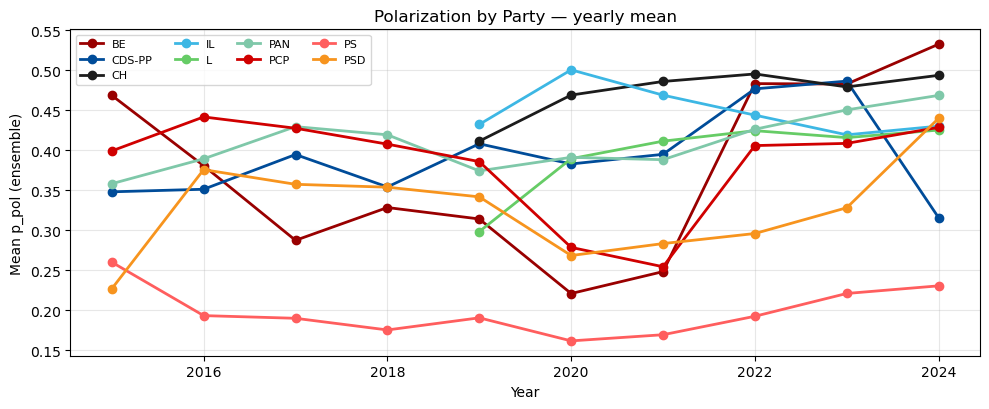

In [5]:
yearly = (d0.groupby(["party","year"])["p_pol_ensemble"].mean()
            .reset_index())

plt.figure(figsize=(10,4.2))
for party, sub in yearly.groupby("party"):
    plt.plot(sub["year"], sub["p_pol_ensemble"], marker="o", linewidth=2, label=party, color=color_for(party))
plt.legend(ncol=4, fontsize=8)
plt.xlabel("Year"); plt.ylabel("Mean p_pol (ensemble)")
plt.title("Polarization by Party — yearly mean")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(SAVE_DIR / "party_yearly_lines.png", dpi=180)
plt.show()


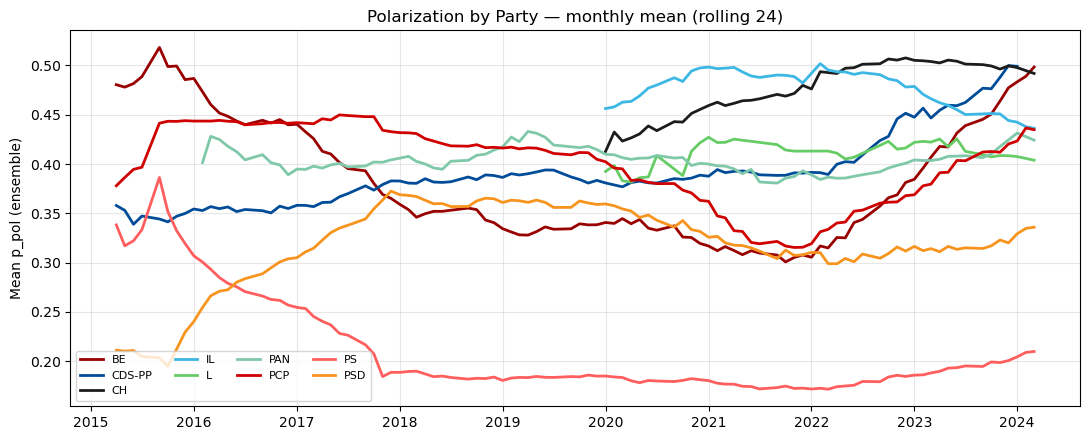

In [6]:
WINDOW = 24
agg = (d0.groupby(["party","month"])["p_pol_ensemble"].mean()
         .reset_index())
agg["p_pol_smooth"] = agg.groupby("party")["p_pol_ensemble"]\
    .transform(lambda s: s.rolling(WINDOW, min_periods=max(3, WINDOW//6)).mean())

plt.figure(figsize=(11,4.5))
for party, sub in agg.groupby("party"):
    plt.plot(sub["month"], sub["p_pol_smooth"], label=party, linewidth=2, color=color_for(party))
plt.legend(ncol=4, fontsize=8)
plt.ylabel("Mean p_pol (ensemble)")
plt.title(f"Polarization by Party — monthly mean (rolling {WINDOW})")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(SAVE_DIR / f"party_trends_roll{WINDOW}.png", dpi=180)
plt.show()


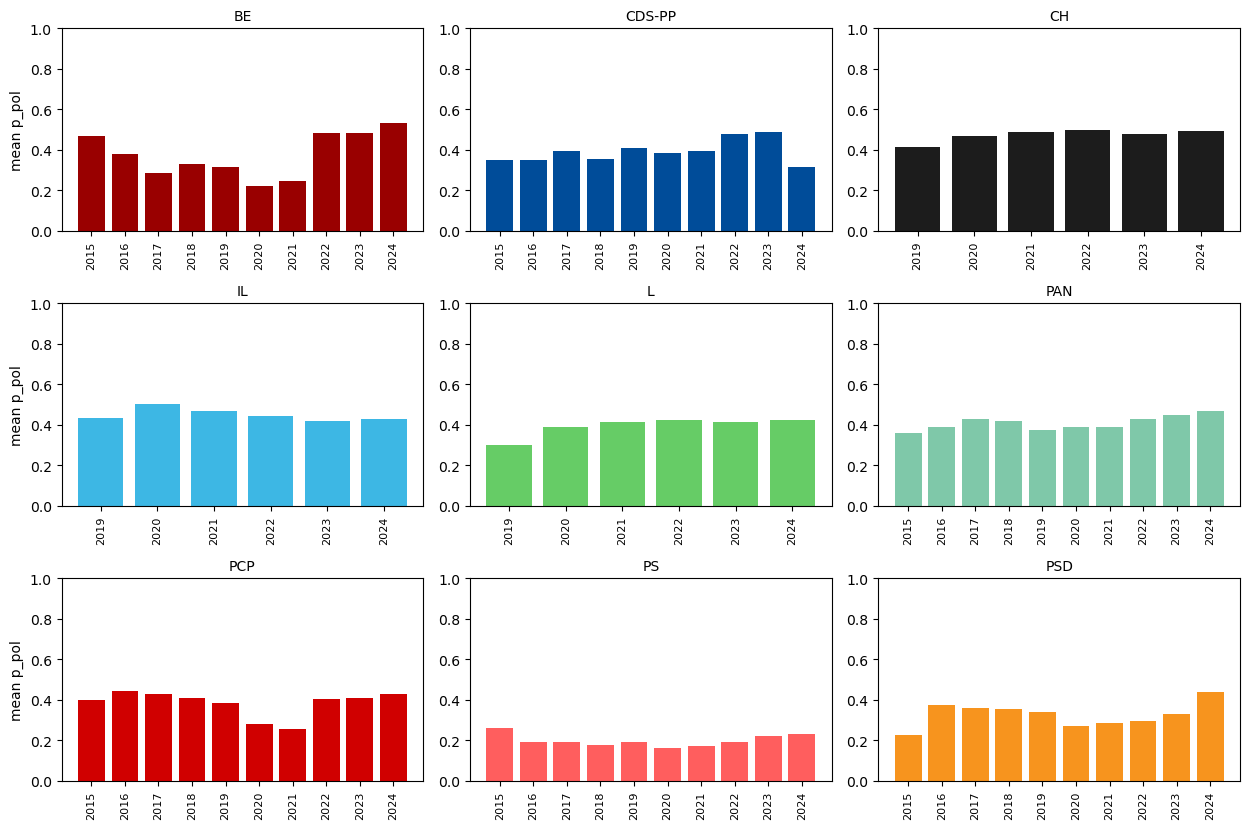

In [7]:
parties = d0_parties
n = len(parties); ncols = min(3, n); nrows = int(np.ceil(n / ncols))
plt.figure(figsize=(4.2*ncols, 2.8*nrows))

for i, p in enumerate(parties, 1):
    ax = plt.subplot(nrows, ncols, i)
    sub = yearly[yearly["party"] == p].sort_values("year")
    ax.bar(sub["year"].astype(str), sub["p_pol_ensemble"], color=color_for(p))
    ax.set_title(p, fontsize=10)
    ax.set_ylim(0, 1)
    if i % ncols == 1: ax.set_ylabel("mean p_pol")
    ax.tick_params(axis='x', labelrotation=90, labelsize=8)

plt.tight_layout()
plt.savefig(SAVE_DIR / "party_yearly_bars_facets.png", dpi=180)
plt.show()


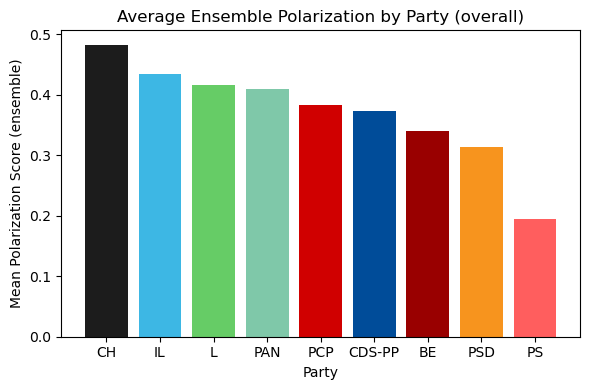

party  mean_pol
2      CH  0.482711
3      IL  0.434663
4       L  0.415745
5     PAN  0.409360
6     PCP  0.383587
1  CDS-PP  0.373761
0      BE  0.340037
8     PSD  0.314552
7      PS  0.194739

In [9]:
POL_COL = "p_pol_ensemble"
d = d0.copy()

party_stats = (
    d.groupby("party")[POL_COL]
     .mean()
     .reset_index(name="mean_pol")
     .sort_values("mean_pol", ascending=False)
)

plt.figure(figsize=(6,4))
plt.bar(party_stats["party"], party_stats["mean_pol"],
        color=[color_for(p) for p in party_stats["party"]])

plt.title("Average Ensemble Polarization by Party (overall)")
plt.ylabel("Mean Polarization Score (ensemble)")
plt.xlabel("Party")
plt.tight_layout()
plt.savefig(SAVE_DIR/"overall_mean_p_pol_ensemble_by_party.png", dpi=300)
plt.show()

party_stats


In [1]:
# ==== ParlaMint-PT loader (all years) → clean text → align with metadata ====

import os, glob, re
import pandas as pd

# ---- EDIT THIS: your root folder that contains the year subfolders ----
ROOT_DIR = "/Users/Nomis/Desktop/ParlaMintPTtext.txt"   # your working path

# (optional) where to save merged results
OUT_PARQUET = None  # e.g., "/Users/simon/Desktop/parlamint_pt_all.parquet"

def discover_pairs(root_dir):
    """
    Find all TXT + -meta.tsv pairs recursively under root_dir.
    Returns list of tuples: (date_iso, txt_path, meta_path)
    """
    pattern = os.path.join(root_dir, "**", "ParlaMint-PT_*.txt")
    txt_files = sorted(glob.glob(pattern, recursive=True))
    pairs = []
    for txt in txt_files:
        meta = txt[:-4] + "-meta.tsv"  # non-EN meta next to the txt
        if os.path.exists(meta):
            m = re.search(r"(\d{4}-\d{2}-\d{2})", os.path.basename(txt))
            date_iso = m.group(1) if m else ""
            pairs.append((date_iso, txt, meta))
    return pairs

ID_PREFIX_RE = re.compile(r'^\s*(ParlaMint-PT_\d{4}-\d{2}-\d{2}\.[^\t]*)\t')

def parse_text_line(raw_line: str):
    """
    Split a raw line into (utt_id, clean_text).
    - Lines typically look like: 'ParlaMint-PT_2015-01-07.u1\tSrs. Deputados, ...'
    - If no tab/id found, utt_id is '', clean_text is the trimmed line.
    """
    m = ID_PREFIX_RE.match(raw_line)
    if m:
        utt_id = m.group(1)
        clean_text = raw_line[m.end():].strip()
        return utt_id, clean_text
    else:
        # fallback: if there is a tab, split once
        if "\t" in raw_line:
            left, right = raw_line.split("\t", 1)
            return left.strip(), right.strip()
        return "", raw_line.strip()

def load_one_day(txt_path, meta_path, date_iso):
    """
    Load one day's TXT and META into DataFrames:
      - texts_df: date, line_no, utt_id, text
      - meta_df : original meta (adds 'date' if missing)
    """
    with open(txt_path, "r", encoding="utf-8") as f:
        raw_lines = [ln.rstrip("\n") for ln in f]

    utt_ids, clean_texts = [], []
    for ln in raw_lines:
        uid, ct = parse_text_line(ln)
        utt_ids.append(uid)
        clean_texts.append(ct)

    texts_df = pd.DataFrame({
        "date": date_iso,
        "line_no": range(1, len(clean_texts) + 1),
        "utt_id": utt_ids,
        "text": clean_texts
    })

    meta_df = pd.read_csv(meta_path, sep="\t", dtype=str).fillna("")
    # ensure a date column exists
    if "date" not in (c.lower() for c in meta_df.columns):
        meta_df["date"] = date_iso

    return texts_df, meta_df

# ---- Load everything ----
pairs = discover_pairs(ROOT_DIR)
print(f"Found {len(pairs)} days with TXT + meta")

texts_all, meta_all = [], []
for date_iso, txt, meta in pairs:
    tdf, mdf = load_one_day(txt, meta, date_iso)
    texts_all.append(tdf)
    meta_all.append(mdf)

texts_df = pd.concat(texts_all, ignore_index=True)
meta_df  = pd.concat(meta_all,  ignore_index=True)

print("All texts_df shape:", texts_df.shape)
print("All meta_df  shape:", meta_df.shape)

# ---- Align by index (same order built in the same loop) ----
# Keep only one 'date' column (from texts_df)
full_df = pd.concat(
    [texts_df.reset_index(drop=True),
     meta_df.reset_index(drop=True).drop(columns=["date"], errors="ignore")],
    axis=1
)

print("\nfull_df shape:", full_df.shape)
print(full_df.head(10))

# ---- (optional) Save to Parquet for fast future use ----
if OUT_PARQUET:
    full_df.to_parquet(OUT_PARQUET, index=False)
    print(f"\nSaved merged data to: {OUT_PARQUET}")

Found 897 days with TXT + meta
All texts_df shape: (247539, 4)
All meta_df  shape: (247539, 24)

full_df shape: (247539, 28)
         date  line_no                       utt_id  \
0  2015-01-07        1   ParlaMint-PT_2015-01-07.u1   
1  2015-01-07        2   ParlaMint-PT_2015-01-07.u2   
2  2015-01-07        3   ParlaMint-PT_2015-01-07.u3   
3  2015-01-07        4   ParlaMint-PT_2015-01-07.u4   
4  2015-01-07        5   ParlaMint-PT_2015-01-07.u5   
5  2015-01-07        6   ParlaMint-PT_2015-01-07.u6   
6  2015-01-07        7   ParlaMint-PT_2015-01-07.u7   
7  2015-01-07        8   ParlaMint-PT_2015-01-07.u8   
8  2015-01-07        9   ParlaMint-PT_2015-01-07.u9   
9  2015-01-07       10  ParlaMint-PT_2015-01-07.u10   

                                                text                  Text_ID  \
0  Srs. Deputados, Srs. Jornalistas, Srs. Funcion...  ParlaMint-PT_2015-01-07   
1  Sr.ª Presidente, Srs. Deputados, deram entrada...  ParlaMint-PT_2015-01-07   
2  Muito obrigada, Sr. Dep

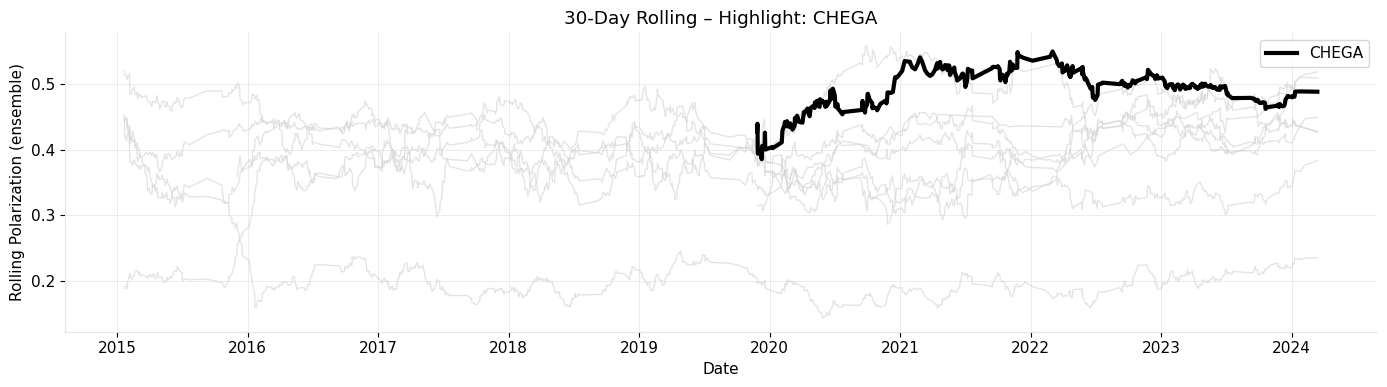

In [39]:
ROLL = 30
FOCUS = "CHEGA"

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=7).mean())
)

plt.figure(figsize=(14,4))

# alle Parteien grau
for party, sub in daily.groupby("party"):
    if party != FOCUS:
        plt.plot(sub["date"], sub[f"roll{ROLL}"], 
                 color="lightgray", linewidth=1, alpha=0.6)

# Fokuspartei stark highlighten
sub = daily[daily["party"] == FOCUS]
plt.plot(sub["date"], sub[f"roll{ROLL}"],
         color=color_for(FOCUS), linewidth=3, label=FOCUS)

plt.title(f"{ROLL}-Day Rolling – Highlight: {FOCUS}")
plt.ylabel("Rolling Polarization (ensemble)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR/f"rolling{ROLL}_chega_highlight.png", dpi=300)
plt.show()


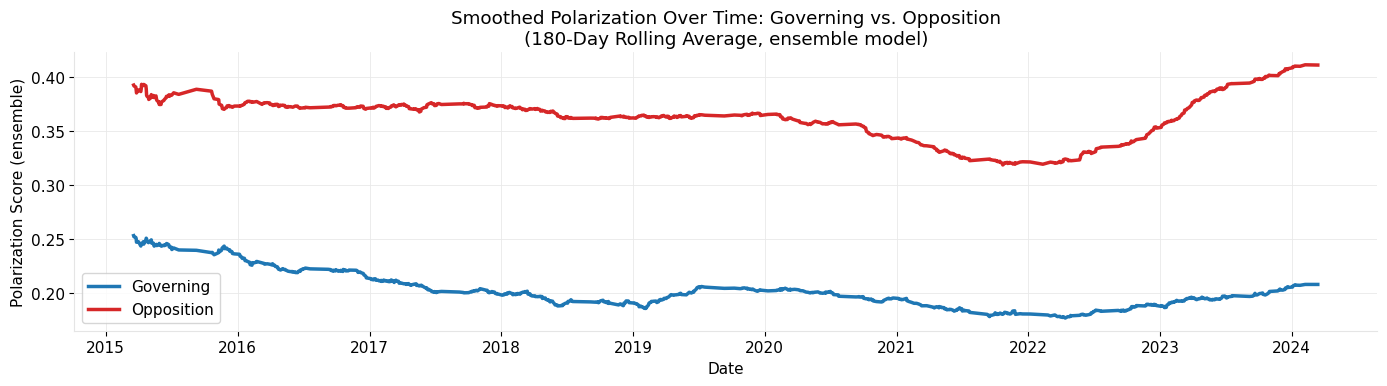

In [52]:
plt.figure(figsize=(14,4))

for bloc, sub in daily_bloc.groupby("bloc"):
    color = "tab:blue" if bloc == "Governing" else "tab:red"
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=bloc, color=color, linewidth=2.5)

plt.title(f"Smoothed Polarization Over Time: Governing vs. Opposition\n({ROLL}-Day Rolling Average, ensemble model)")
plt.ylabel("Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / f"polarization_gov_vs_opp_roll{ROLL}.png", dpi=300)
plt.show()


  Speaker_gender  polarizing_pct Gender
1              M       26.594974    Men
0              F       34.410856  Women


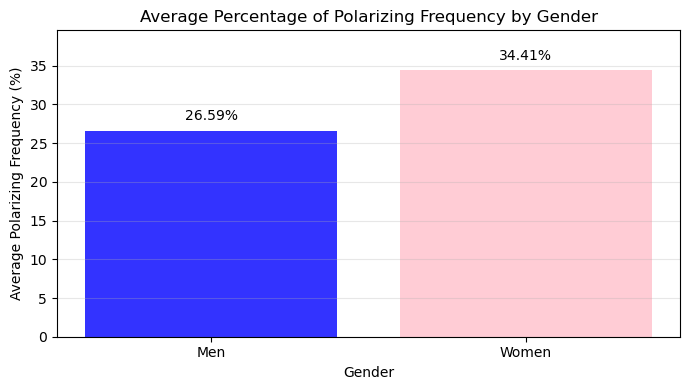

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load / assume existing data ---

# Scores (what you used for the party plots)
df_scores = df  # or: pd.read_csv("all_with_ensemble.csv", parse_dates=["date"])

# Metadata with gender (from your loader script)
# full_df has columns: utt_id, Speaker_gender, ...
# if you're in a new notebook: load it from parquet/CSV if you saved it
# full_df = pd.read_parquet("parlamint_pt_all.parquet")

# --- 2. Merge scores with gender ---

merged = df_scores.merge(
    full_df[["utt_id", "Speaker_gender"]],
    left_on="speech_id",   # from df_scores
    right_on="utt_id",     # from full_df
    how="left",
)

# Keep only rows with known gender
merged = merged[merged["Speaker_gender"].isin(["M", "F"])].copy()

# --- 3. Define "polarizing" and compute percentages ---

THRESH = 0.5  # adjust if you use another cutoff
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

freq = (
    merged.groupby("Speaker_gender")["is_polarizing"]
          .mean()
          .mul(100)   # to %
          .reset_index(name="polarizing_pct")
)

# Map M/F to Men/Women
label_map = {"M": "Men", "F": "Women"}
freq["Gender"] = freq["Speaker_gender"].map(label_map)
freq = freq.sort_values("Gender")

print(freq)
#   Speaker_gender  polarizing_pct Gender
# 0              F           ...   Women
# 1              M           ...   Men

# --- 4. Plot like your example ---

plt.figure(figsize=(7, 4))
colors = ["blue", "pink"]  # Men, Women
bars = plt.bar(freq["Gender"], freq["polarizing_pct"], color=colors, alpha=0.8)

# Labels on top of bars
for bar, val in zip(bars, freq["polarizing_pct"]):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        f"{val:.2f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.ylabel("Average Polarizing Frequency (%)")
plt.xlabel("Gender")
plt.title("Average Percentage of Polarizing Frequency by Gender")
plt.ylim(0, max(freq["polarizing_pct"]) * 1.15)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/polarizing_by_gender.png", dpi=180)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_8680\3711128947.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged.groupby("age_group")


  age_group  polarizing_freq  num_politicians
0     20-30         0.499886               25
1     30-40         0.437029              152
2     40-50         0.394031              264
3     50-60         0.306265              254
4     60-70         0.122652              167
5     70-80         0.047260               38
6     80-90              NaN                0


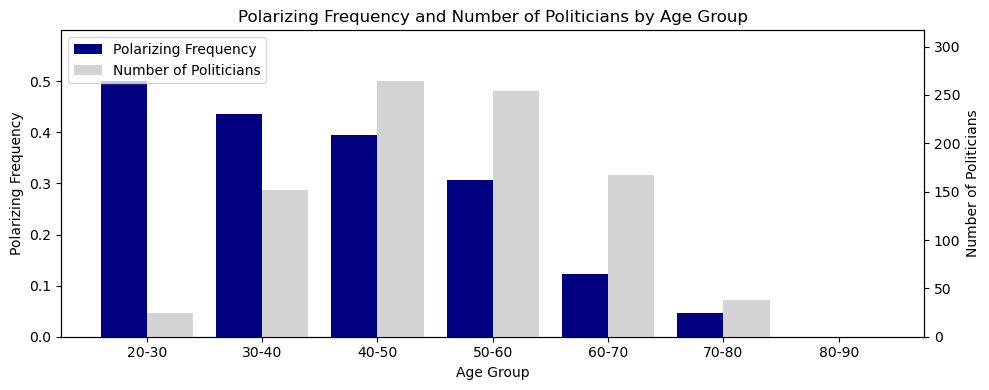

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Merge scores with metadata (as before) ---

df_scores = df  # your all_with_ensemble dataframe

merged = df_scores.merge(
    full_df[["utt_id", "Speaker_ID", "Speaker_birth"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left",
)

# Parse birth year and drop missing
merged["Speaker_birth"] = pd.to_numeric(merged["Speaker_birth"], errors="coerce")
merged = merged.dropna(subset=["Speaker_birth"])

# Age at time of speech (approx, uses year only)
merged["age"] = merged["date"].dt.year - merged["Speaker_birth"]

# Keep reasonable ages
merged = merged[(merged["age"] >= 20) & (merged["age"] <= 90)]

# --- 2. Define polarizing indicator ---

THRESH = 0.5
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

# --- 3. Define age groups ---

bins = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ["20-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90"]

merged["age_group"] = pd.cut(merged["age"], bins=bins, labels=labels, right=False)

# --- 4. Aggregate: polarizing frequency & number of politicians ---

agg = (
    merged.groupby("age_group")
          .agg(
              polarizing_freq=("is_polarizing", "mean"),
              num_politicians=("Speaker_ID", "nunique"),
          )
          .reset_index()
)

print(agg)

# --- 5. Plot dual-axis bar chart ---

x = np.arange(len(agg))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10, 4))

# Left axis: polarizing frequency
bars1 = ax1.bar(
    x - width/2,
    agg["polarizing_freq"],
    width,
    label="Polarizing Frequency",
    color="navy",
)

ax1.set_ylabel("Polarizing Frequency")
ax1.set_xlabel("Age Group")
ax1.set_xticks(x)
ax1.set_xticklabels(agg["age_group"])
ax1.set_ylim(0, agg["polarizing_freq"].max() * 1.2)

# Right axis: number of politicians
ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + width/2,
    agg["num_politicians"],
    width,
    label="Number of Politicians",
    color="lightgray",
)
ax2.set_ylabel("Number of Politicians")
ax2.set_ylim(0, agg["num_politicians"].max() * 1.2)

# Combined legend
handles = [bars1, bars2]
labels_legend = ["Polarizing Frequency", "Number of Politicians"]
ax1.legend(handles, labels_legend, loc="upper left")

plt.title("Polarizing Frequency and Number of Politicians by Age Group")
plt.tight_layout()
plt.savefig("figures/polarizing_by_age_group.png", dpi=180)
plt.show()


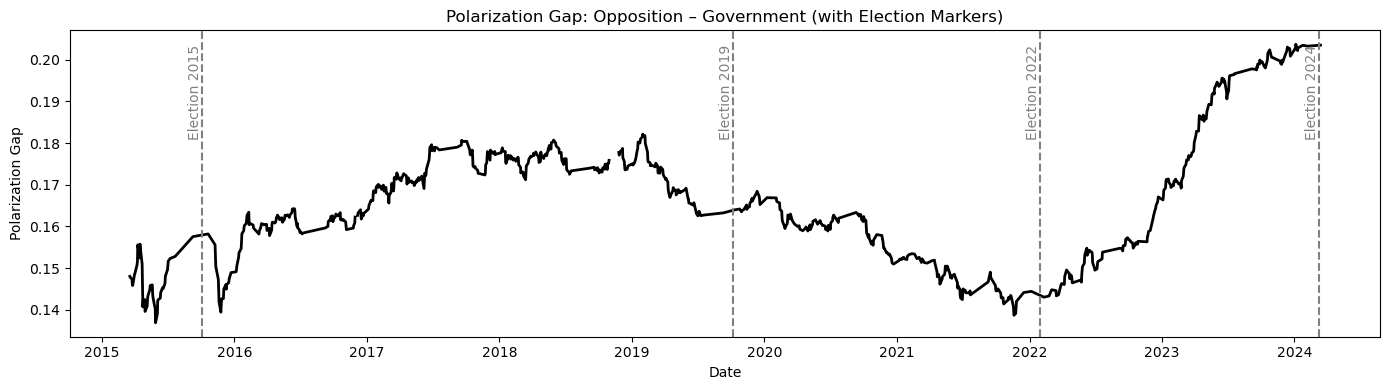

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# ==== 1. Build d_sent with bloc column =====================================

POL_COL = "p_pol_ensemble"   # your polarization score column

# merge in Party_status from full_df
d_sent = df.merge(
    full_df[["utt_id", "Party_status"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left"
)

# make sure date is datetime
d_sent["date"] = pd.to_datetime(d_sent["date"])

# map Party_status -> bloc (Governing vs Opposition)
def map_bloc(status):
    if status in ["Coalition", "Government"]:
        return "Governing"
    elif status == "Opposition":
        return "Opposition"
    else:
        return None  # drop weird / missing entries

d_sent["bloc"] = d_sent["Party_status"].apply(map_bloc)
d_sent = d_sent.dropna(subset=["bloc"]).copy()

# ==== 2. Compute rolling gap ==============================================

ROLL = 180  # days

daily_bloc = (
    d_sent.groupby(["bloc", "date"])[POL_COL]
          .mean()
          .reset_index(name="pol_mean")
)

daily_bloc = daily_bloc.sort_values(["bloc", "date"])
daily_bloc[f"roll{ROLL}"] = (
    daily_bloc.groupby("bloc")["pol_mean"]
              .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

pivot = daily_bloc.pivot(index="date", columns="bloc", values=f"roll{ROLL}")
pivot["gap_opp_minus_gov"] = pivot["Opposition"] - pivot["Governing"]

# ==== 3. Plot with election markers (including 2024) ======================

plt.figure(figsize=(14,4))
plt.plot(pivot.index, pivot["gap_opp_minus_gov"], color="black", linewidth=2)

elections = {
    "2015-10-04": "Election 2015",
    "2019-10-06": "Election 2019",
    "2022-01-30": "Election 2022",
    "2024-03-10": "Election 2024",  # <- new one
}

y_top = pivot["gap_opp_minus_gov"].max()

for date_str, label in elections.items():
    x = pd.to_datetime(date_str)
    plt.axvline(x, linestyle="--", color="gray")
    plt.text(x, y_top, label, rotation=90, va="top", ha="right", color="gray")

plt.title("Polarization Gap: Opposition – Government (with Election Markers)")
plt.ylabel("Polarization Gap")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(SAVE_DIR / "gov_opp_gap_elections.png", dpi=300)
plt.show()


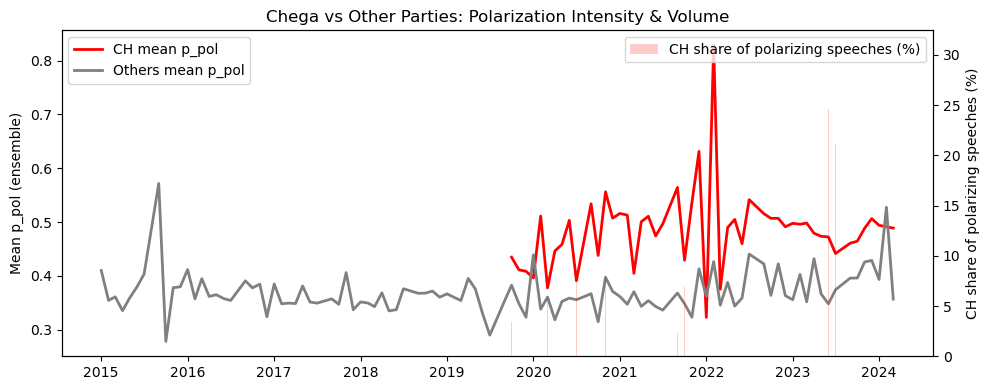

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

d = df.copy()
d["month"] = d["date"].dt.to_period("M").dt.to_timestamp()

CH = "CH"  # adapt if code different

# Mean score per month
mean_by_party = (
    d.groupby(["party", "month"])["p_pol_ensemble"]
     .mean()
     .reset_index()
)

# Aggregate others
ch_series = mean_by_party[mean_by_party["party"] == CH]
others = (
    mean_by_party[mean_by_party["party"] != CH]
    .groupby("month")["p_pol_ensemble"].mean().reset_index()
)

# Share of polarizing speeches from Chega
TH = 0.5
d["is_pol"] = d["p_pol_ensemble"] >= TH
share_ch = (
    d[d["is_pol"]]
    .assign(is_ch=lambda x: x["party"] == CH)
    .groupby("month")["is_ch"]
    .mean().mul(100).reset_index(name="share_ch_pct")
)

fig, ax1 = plt.subplots(figsize=(10,4))
ax2 = ax1.twinx()

ax1.plot(ch_series["month"], ch_series["p_pol_ensemble"], label="CH mean p_pol", lw=2, color="red")
ax1.plot(others["month"], others["p_pol_ensemble"], label="Others mean p_pol", lw=2, color="gray")

ax2.bar(share_ch["month"], share_ch["share_ch_pct"],
        alpha=0.2, color="red", label="CH share of polarizing speeches (%)")

ax1.set_ylabel("Mean p_pol (ensemble)")
ax2.set_ylabel("CH share of polarizing speeches (%)")
ax1.set_title("Chega vs Other Parties: Polarization Intensity & Volume")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.savefig("figures/chega_vs_others.png", dpi=180)
plt.show()


                    Topic  total_speeches  polar_pct  non_polar_pct
16         Macroeconomics           20261  58.881595      41.118405
14                  Labor            8309  55.963413      44.036587
4       Domestic Commerce            4388  52.643573      47.356427
11                Housing            3777  51.231136      48.768864
20         Social Welfare            4838  50.702770      49.297230
12            Immigration            1587  49.968494      50.031506
5               Education            7452  49.570585      50.429415
9   Government Operations            8746  49.165333      50.834667
10                 Health           11633  47.838047      52.161953
22         Transportation            4371  47.014413      52.985587
1            Civil Rights            4522  44.869527      55.130473
8           Foreign Trade             348  44.827586      55.172414
15          Law and Crime            5269  44.391725      55.608275
17                    Mix           11924  43.82

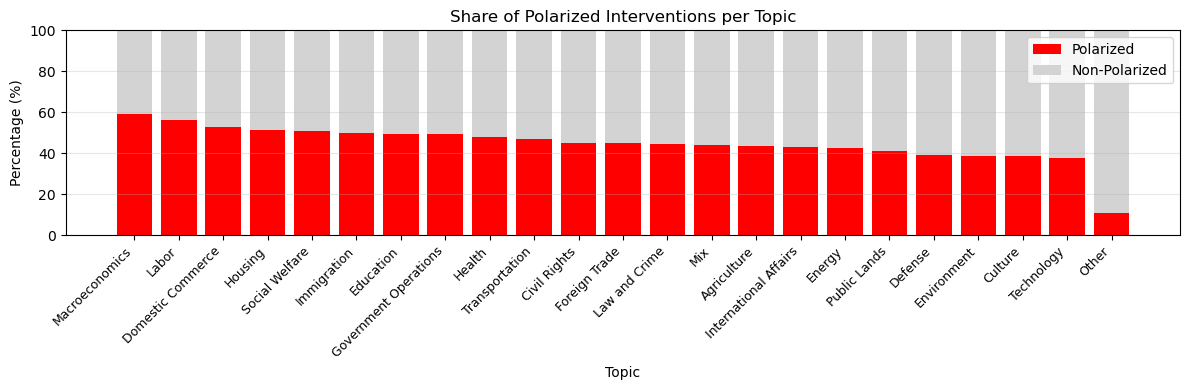

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---------------------------------------------------
# 0) Config
# ---------------------------------------------------
THRESH = 0.5                    # cutoff for "polarizing"
MIN_SPEECHES = 0                # optional: min speeches per topic to keep
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# ---------------------------------------------------
# 1) Merge scores with main topic
# ---------------------------------------------------
merged = df.merge(
    full_df[["utt_id", "Topic"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left"
)

# Drop rows without a topic
merged = merged.dropna(subset=["Topic"]).copy()

# Flag polarizing interventions
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

# ---------------------------------------------------
# 2) Aggregate by topic: polarizing & non-polarizing %
# ---------------------------------------------------
agg = (
    merged.groupby("Topic")
          .agg(
              total_speeches=("is_polarizing", "size"),
              polar_speeches=("is_polarizing", "sum"),
          )
          .reset_index()
)

# Optional: keep only topics with enough speeches
agg = agg[agg["total_speeches"] >= MIN_SPEECHES].copy()

agg["polar_pct"] = agg["polar_speeches"] / agg["total_speeches"] * 100
agg["non_polar_pct"] = 100 - agg["polar_pct"]

# Sort topics by polarizing percentage (descending)
agg = agg.sort_values("polar_pct", ascending=False)

print(agg[["Topic", "total_speeches", "polar_pct", "non_polar_pct"]])

# ---------------------------------------------------
# 3) Plot 100% stacked bar chart (like your picture)
# ---------------------------------------------------
x = np.arange(len(agg))

fig, ax = plt.subplots(figsize=(12, 4))

# Bottom: POLARIZED (red)
ax.bar(
    x,
    agg["polar_pct"],
    color="red",
    label="Polarized"
)

# Top: NON-POLARIZED (light grey) stacked on top
ax.bar(
    x,
    agg["non_polar_pct"],
    bottom=agg["polar_pct"],
    color="lightgrey",
    label="Non-Polarized"
)

ax.set_xticks(x)
ax.set_xticklabels(agg["Topic"], rotation=45, ha="right", fontsize=9)
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Topic")
ax.set_title("Share of Polarized Interventions per Topic")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out_path = SAVE_DIR / "topics_polarized_share_100stack.png"
plt.savefig(out_path, dpi=180)
print("Saved plot →", out_path)

plt.show()


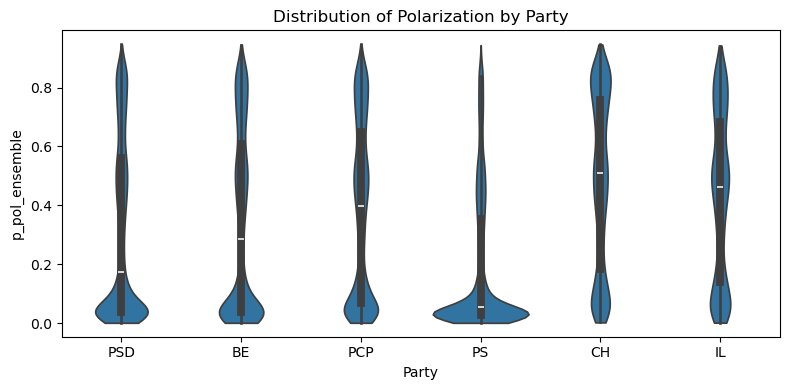

In [18]:
import seaborn as sns

main = df[df["party"].isin(["PS","PSD","CH","IL","BE","PCP"])]

plt.figure(figsize=(8,4))
sns.violinplot(data=main, x="party", y="p_pol_ensemble", cut=0)
plt.ylabel("p_pol_ensemble")
plt.xlabel("Party")
plt.title("Distribution of Polarization by Party")
plt.tight_layout()
plt.savefig("figures/party_violin.png", dpi=180)
plt.show()


Saved → figures\chega_vs_others_by_topic.png


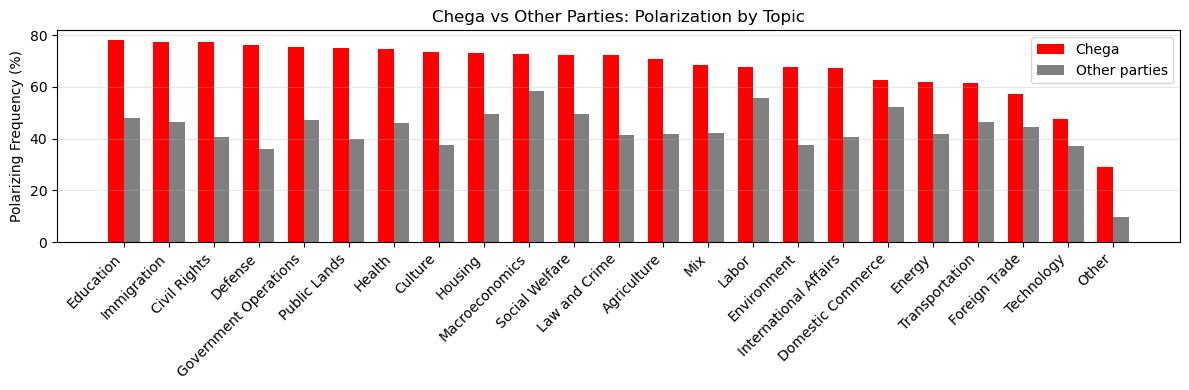

In [23]:
merged_ch = df.merge(
    full_df[["utt_id", "Topic"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_ch = merged_ch.dropna(subset=["Topic","party"]).copy()
merged_ch["is_polarizing"] = merged_ch["p_pol_ensemble"] >= THRESH

CH = "CH"  # adapt if needed
merged_ch["group"] = np.where(merged_ch["party"] == CH, "Chega", "Other parties")

agg_ch = (
    merged_ch.groupby(["Topic", "group"])["is_polarizing"]
             .mean()                         # P(polarizing | topic, group)
             .mul(100).reset_index(name="polar_pct")
)

# pivot to columns Chega / Other
pivot_ch = agg_ch.pivot(index="Topic", columns="group", values="polar_pct").fillna(0)

# keep topics with enough data
counts = merged_ch.groupby("Topic")["is_polarizing"].size()
pivot_ch = pivot_ch.loc[counts[counts >= 200].index]

pivot_ch = pivot_ch.sort_values("Chega", ascending=False)

x = np.arange(len(pivot_ch))
width = 0.35
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(x - width/2, pivot_ch["Chega"], width, label="Chega", color="red")
ax.bar(x + width/2, pivot_ch["Other parties"], width, label="Other parties", color="grey")

ax.set_xticks(x)
ax.set_xticklabels(pivot_ch.index, rotation=45, ha="right")
ax.set_ylabel("Polarizing Frequency (%)")
ax.set_title("Chega vs Other Parties: Polarization by Topic")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "chega_vs_others_by_topic.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


# 6. More results

This final chapter provides additional analyses and robustness checks that complement, but are not central to, the main thesis narrative. It includes extended threshold sweeps, alternative evaluation metrics, and supplementary plots for specific parties or time periods. These results help to validate the stability of the polarization measure and offer further detail for readers interested in the behaviour of the models beyond the headline findings.

<Figure size 1000x400 with 0 Axes>

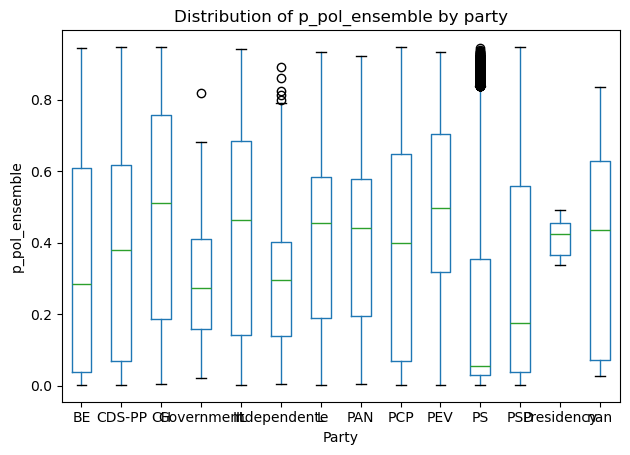

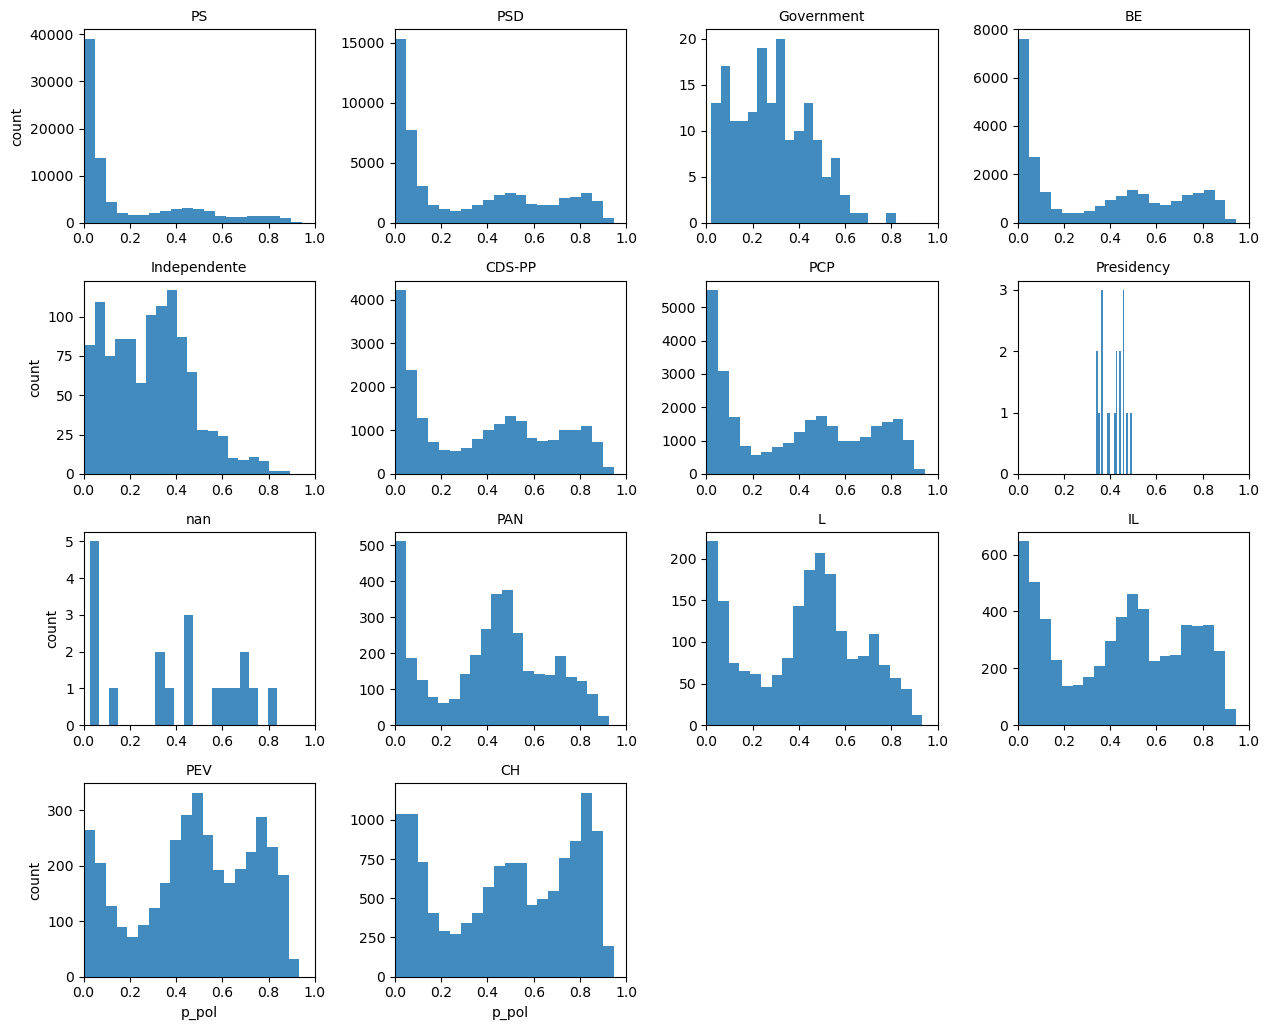

In [7]:
# order parties by median polarization
order = (
    df.groupby("party")["p_pol_ensemble"]
      .median().sort_values().index.tolist()
)

plt.figure(figsize=(10,4))
# pandas boxplot for quick layout
df.boxplot(column="p_pol_ensemble", by="party", grid=False, vert=True)
plt.title("Distribution of p_pol_ensemble by party")
plt.suptitle("")
plt.xlabel("Party")
plt.ylabel("p_pol_ensemble")
plt.tight_layout()
plt.savefig(SAVE_DIR / "party_boxplots.png", dpi=180)
plt.show()

# optional: overlaid histograms (small multiples)
n_parties = len(order)
ncols = min(4, n_parties)
nrows = int(np.ceil(n_parties / ncols))
plt.figure(figsize=(3.2*ncols, 2.6*nrows))
for i, p in enumerate(order, 1):
    ax = plt.subplot(nrows, ncols, i)
    sub = df[df["party"] == p]["p_pol_ensemble"].values
    ax.hist(sub, bins=20, alpha=0.85)
    ax.set_title(p, fontsize=10)
    ax.set_xlim(0,1)
    if i % ncols == 1:
        ax.set_ylabel("count")
    if i > (nrows-1)*ncols:
        ax.set_xlabel("p_pol")
plt.tight_layout()
plt.savefig(SAVE_DIR / "party_histograms.png", dpi=180)
plt.show()


Remaining parties: ['BE', 'CDS-PP', 'CH', 'IL', 'L', 'PAN', 'PCP', 'PS', 'PSD']


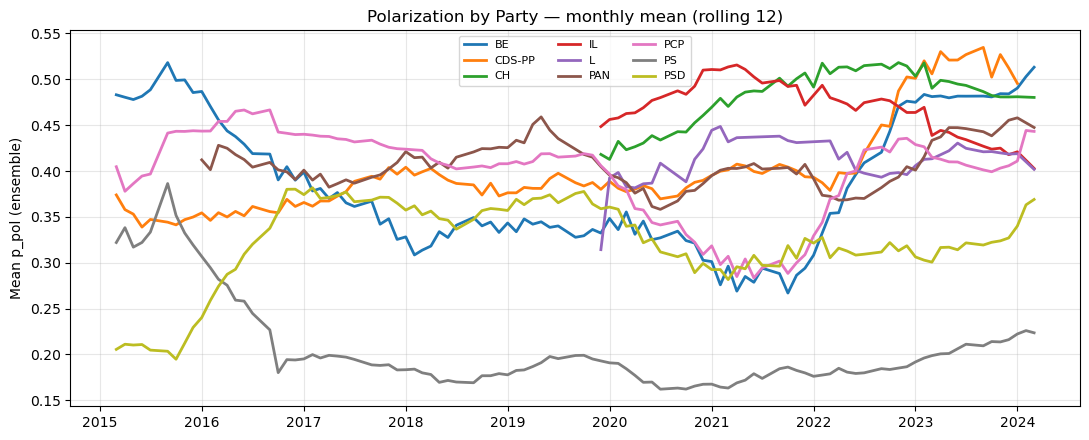

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Copy from your main df (assumes df already loaded)
d = df.copy()

# --- 1. Clean unwanted or empty party labels ---
exclude = {"Independente", "Presidency", "Government", "PEV", "nan", "None", "NaT", ""}
d["party"] = d["party"].astype(str).str.strip()
d = d[~d["party"].isin(exclude)]
d = d[~d["party"].str.lower().isin(["nan","none","nat"])]
print("Remaining parties:", sorted(d["party"].unique()))

# --- 2. Monthly mean ---
d["month"] = d["date"].dt.to_period("M").dt.to_timestamp()
agg = (
    d.groupby(["party","month"])["p_pol_ensemble"]
      .mean()
      .reset_index()
)

# --- 3. Rolling smoothing ---
WINDOW = 12
agg["p_pol_smooth"] = agg.groupby("party")["p_pol_ensemble"].transform(
    lambda s: s.rolling(WINDOW, min_periods=max(3, WINDOW//4)).mean()
)

# --- 4. Plot ---
plt.figure(figsize=(11,4.5))
for party, sub in agg.groupby("party"):
    plt.plot(sub["month"], sub["p_pol_smooth"], label=party, linewidth=2)
plt.legend(ncol=3, fontsize=8)
plt.ylabel("Mean p_pol (ensemble)")
plt.title(f"Polarization by Party — monthly mean (rolling {WINDOW})")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/party_trends_cleaned.png", dpi=180)
plt.show()


In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)

# start from your all-data DataFrame
d0 = df.copy()
drop_parties = ["Independente", "Presidency", "nan", "NaN", "Government", "PEV"]
d0 = d0[~d0["party"].isin(drop_parties)].copy()
d0["party"] = d0["party"].astype(str).str.strip()
d0["month"] = d0["date"].dt.to_period("M").dt.to_timestamp()
d0["year"]  = d0["date"].dt.year

# Party colors (extend/override as needed)
PARTY_COLORS = {
    "PS":"red", "PSD":"orange", "CHEGA":"black", "CH":"black",
    "IL":"blue", "BE":"magenta", "PCP":"green", "PAN":"teal",
    "CDS-PP":"goldenrod", "L":"brown"
}
def color_for(p): return PARTY_COLORS.get(p, "gray")

d0_parties = sorted(d0["party"].unique())
print("Remaining parties:", d0_parties)


Remaining parties: ['BE', 'CDS-PP', 'CH', 'IL', 'L', 'PAN', 'PCP', 'PS', 'PSD']


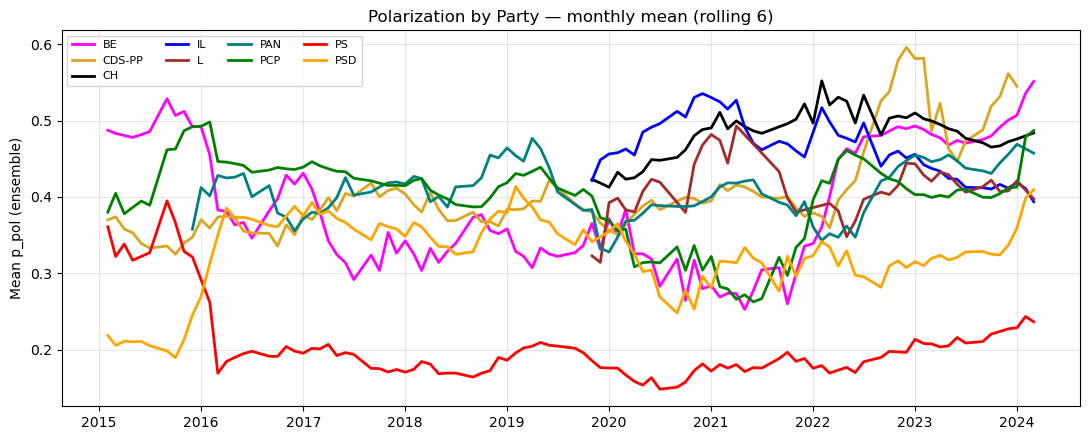

In [11]:
WINDOW = 6
agg = (d0.groupby(["party","month"])["p_pol_ensemble"].mean()
         .reset_index())
agg["p_pol_smooth"] = agg.groupby("party")["p_pol_ensemble"]\
    .transform(lambda s: s.rolling(WINDOW, min_periods=max(2, WINDOW//3)).mean())

plt.figure(figsize=(11,4.5))
for party, sub in agg.groupby("party"):
    plt.plot(sub["month"], sub["p_pol_smooth"], label=party, linewidth=2, color=color_for(party))
plt.legend(ncol=4, fontsize=8)
plt.ylabel("Mean p_pol (ensemble)")
plt.title(f"Polarization by Party — monthly mean (rolling {WINDOW})")
plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig(SAVE_DIR / f"party_trends_roll{WINDOW}.png", dpi=180)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_18292\1288750502.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_by_year, labels=yrs, showfliers=False)


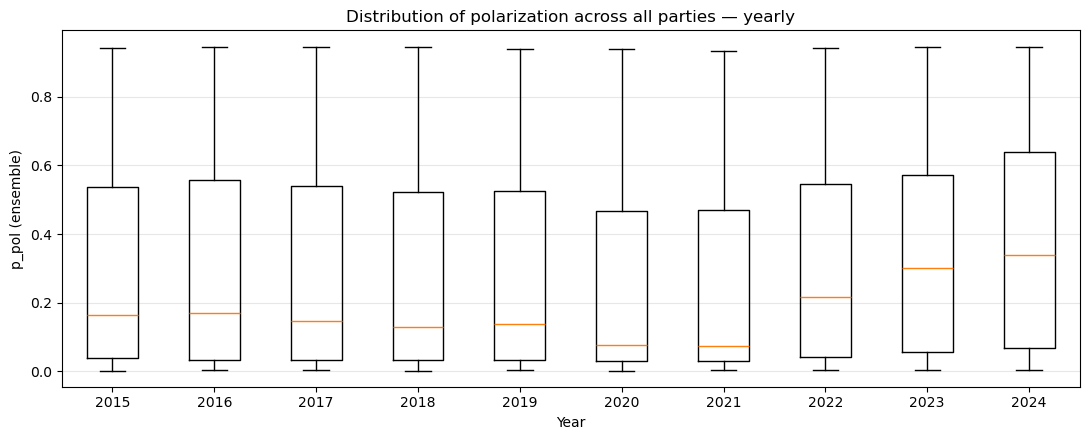

In [15]:
plt.figure(figsize=(11,4.5))
yrs = sorted(d0["year"].unique().tolist())
data_by_year = [d0[d0["year"]==y]["p_pol_ensemble"].values for y in yrs]
plt.boxplot(data_by_year, labels=yrs, showfliers=False)
plt.xlabel("Year"); plt.ylabel("p_pol (ensemble)")
plt.title("Distribution of polarization across all parties — yearly")
plt.grid(axis="y", alpha=0.3); plt.tight_layout()
plt.savefig(SAVE_DIR / "yearly_boxplots_all_parties.png", dpi=180)
plt.show()


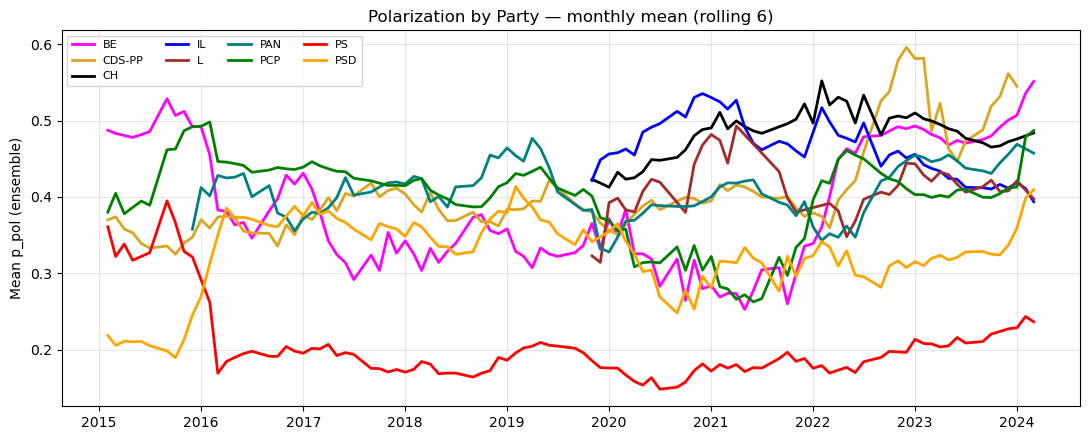

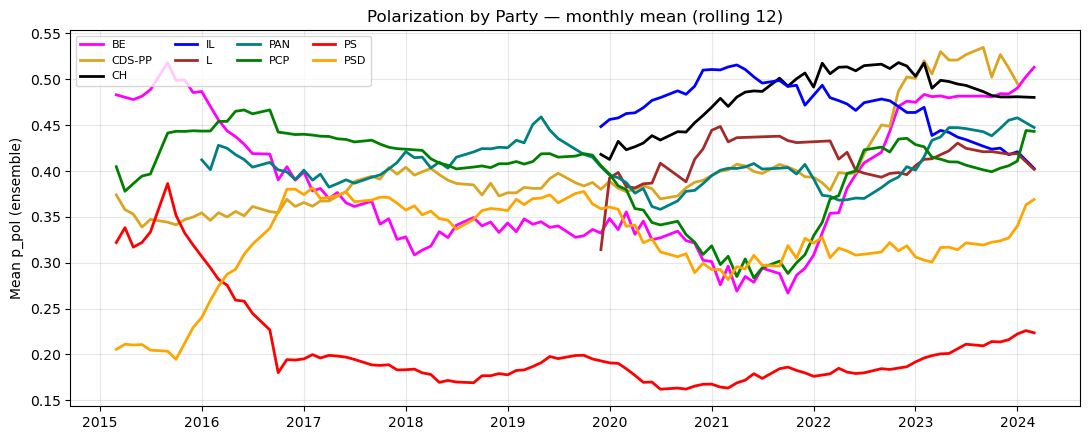

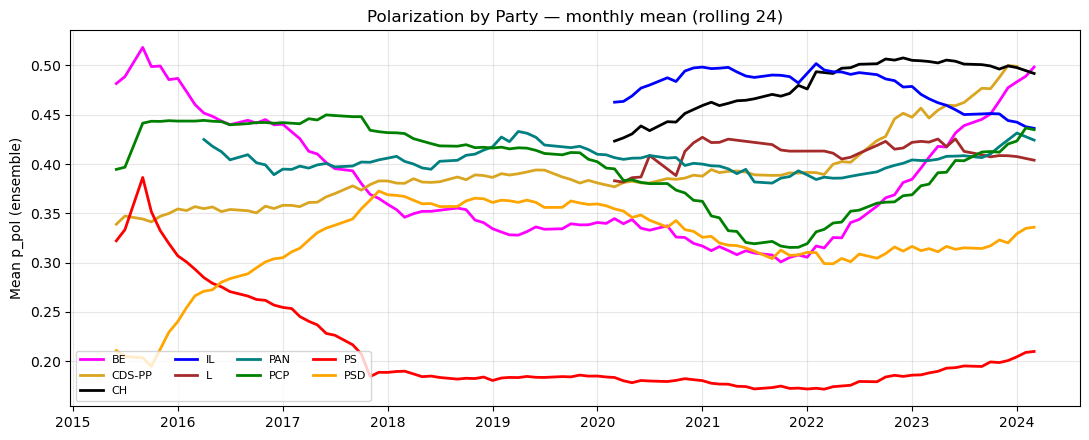

In [16]:
for WINDOW in [6, 12, 24]:
    agg = (d0.groupby(["party","month"])["p_pol_ensemble"].mean()
             .reset_index())
    agg["p_pol_smooth"] = agg.groupby("party")["p_pol_ensemble"]\
        .transform(lambda s: s.rolling(WINDOW, min_periods=max(2, WINDOW//4)).mean())

    plt.figure(figsize=(11,4.5))
    for party, sub in agg.groupby("party"):
        plt.plot(sub["month"], sub["p_pol_smooth"], label=party, linewidth=2, color=color_for(party))
    plt.legend(ncol=4, fontsize=8)
    plt.ylabel("Mean p_pol (ensemble)")
    plt.title(f"Polarization by Party — monthly mean (rolling {WINDOW})")
    plt.grid(alpha=0.3); plt.tight_layout()
    plt.savefig(SAVE_DIR / f"party_trends_roll{WINDOW}.png", dpi=180)
    plt.show()


In [17]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)

# Base DataFrame expected:
# df = pd.read_csv("all_with_ensemble.csv", parse_dates=["date"])

# Clean + filter unwanted parties
drop_parties = {"Independente","Presidency","Government","PEV","nan","NaN"}
d = df.copy()
d = d[~d["party"].isin(drop_parties)].copy()
d["party"] = d["party"].astype(str).str.strip()
d["month"] = d["date"].dt.to_period("M").dt.to_timestamp()

# Party color map (feel free to tweak)
COL = {
    "PS":"red", "PSD":"gold", "CHEGA":"black", "CH":"black",
    "IL":"royalblue", "BE":"hotpink", "PCP":"forestgreen",
    "PAN":"teal", "CDS-PP":"peru", "L":"sienna"
}

# Minimalist style like your example
plt.rcParams.update({
    "axes.edgecolor":"#E5E5E5",
    "axes.linewidth":0.8,
    "axes.grid":True,
    "grid.color":"#E9E9E9",
    "grid.linestyle":"-",
    "grid.linewidth":0.6,
    "axes.spines.top":False,
    "axes.spines.right":False,
    "font.size":11
})


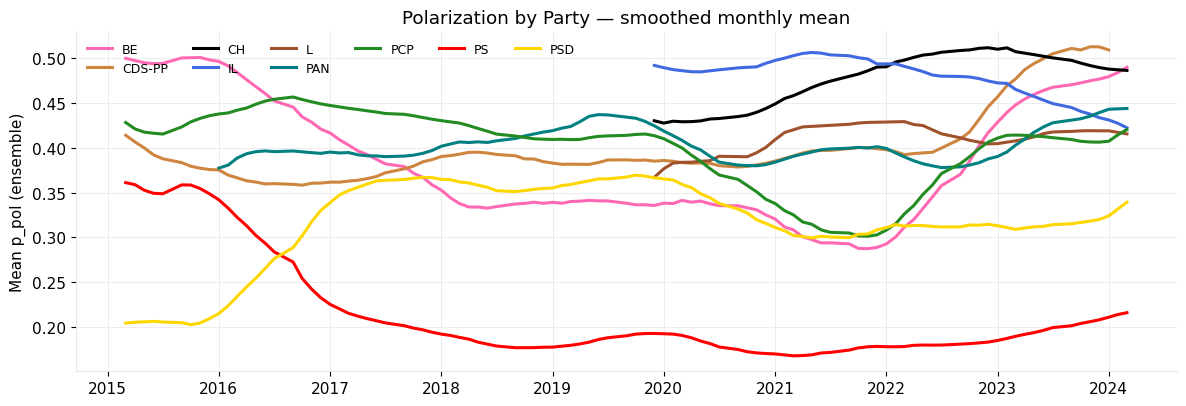

In [18]:
def party_series(df_in, smooth="ewma", span=9, roll=12):
    g = (df_in.groupby(["party","month"])["p_pol_ensemble"]
                .mean().reset_index())
    # EWMA glättet weich; danach optional Rolling für Rest-Rauschen
    if smooth == "ewma":
        g["smooth"] = g.groupby("party")["p_pol_ensemble"].transform(
            lambda s: s.ewm(span=span, adjust=False).mean()
        )
        if roll:
            g["smooth"] = g.groupby("party")["smooth"].transform(
                lambda s: s.rolling(roll, min_periods=max(3,roll//4)).mean()
            )
    else:  # nur Rolling
        g["smooth"] = g.groupby("party")["p_pol_ensemble"].transform(
            lambda s: s.rolling(roll, min_periods=max(3,roll//4)).mean()
        )
    return g

ser = party_series(d, smooth="ewma", span=9, roll=12)

plt.figure(figsize=(12,4.2))
for party, sub in ser.groupby("party"):
    plt.plot(sub["month"], sub["smooth"], lw=2.2,
             color=COL.get(party,"gray"), label=party)
plt.ylabel("Mean p_pol (ensemble)")
plt.title("Polarization by Party — smoothed monthly mean")
plt.legend(ncol=6, frameon=False, fontsize=9)
plt.tight_layout()
plt.savefig(SAVE_DIR/"party_trends_smooth.png", dpi=200)
plt.show()


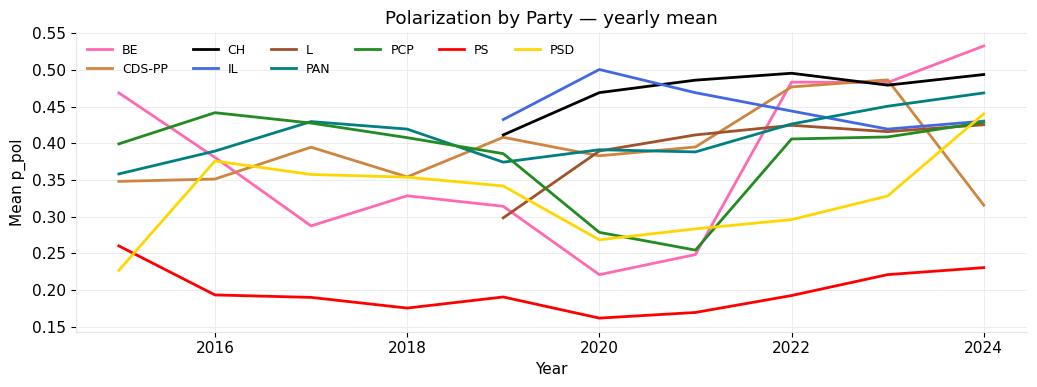

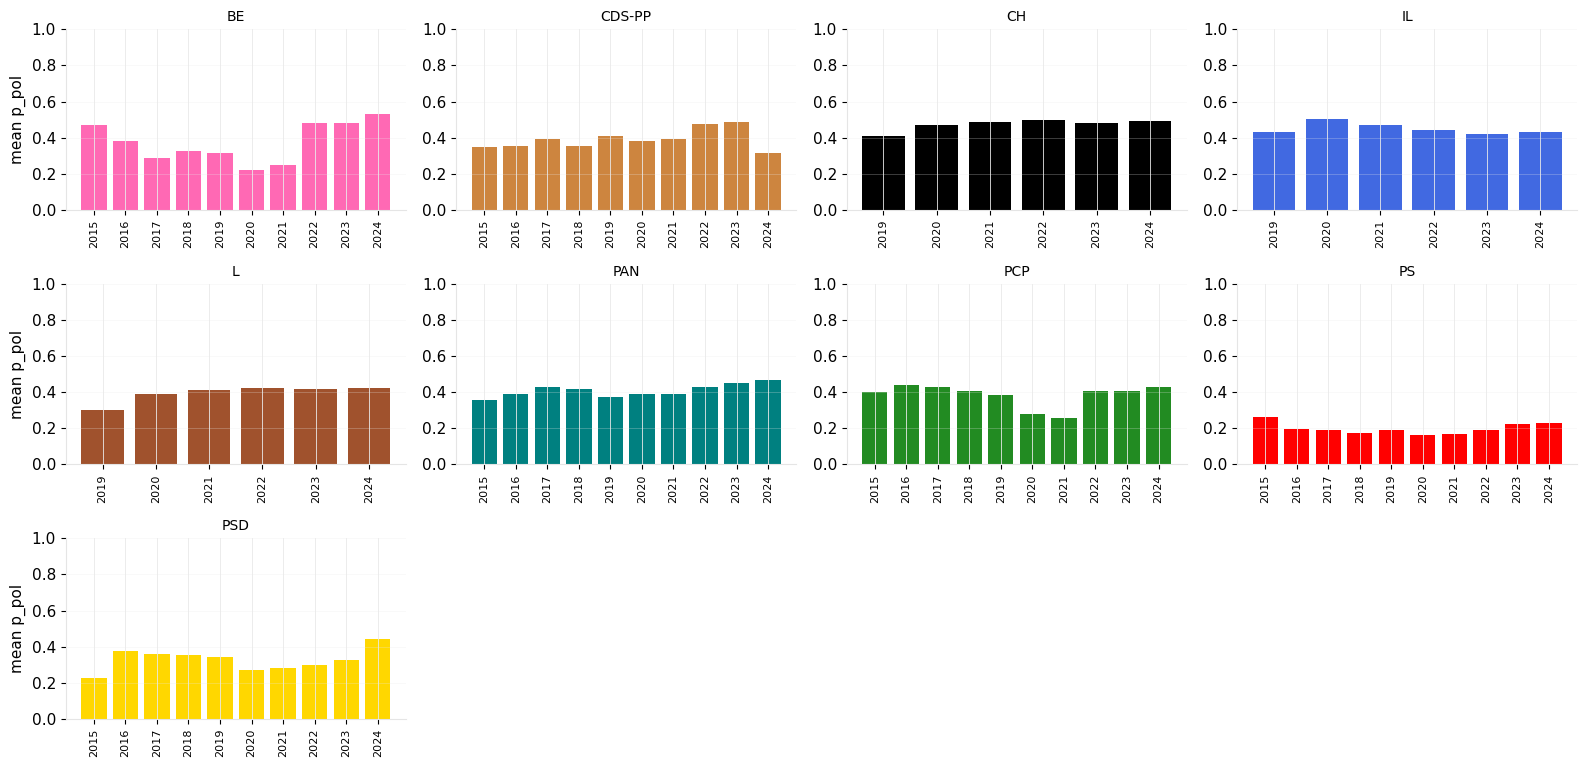

In [19]:
yearly = (d.groupby(["party", d["date"].dt.year])["p_pol_ensemble"]
            .mean().reset_index().rename(columns={"date":"year"}))

# Linien
plt.figure(figsize=(10.5,4.0))
for party, sub in yearly.groupby("party"):
    plt.plot(sub["year"], sub["p_pol_ensemble"], marker=None, lw=2,
             color=COL.get(party,"gray"), label=party)
plt.xlabel("Year"); plt.ylabel("Mean p_pol")
plt.title("Polarization by Party — yearly mean")
plt.legend(ncol=6, frameon=False, fontsize=9)
plt.tight_layout(); plt.savefig(SAVE_DIR/"party_yearly_lines.png", dpi=200); plt.show()

# Gestapelte kleine Facetten mit Balken
parts = sorted(d["party"].unique()); n=len(parts); ncols=min(4,n); nrows=int(np.ceil(n/ncols))
plt.figure(figsize=(4.0*ncols, 2.6*nrows))
for i,p in enumerate(parts,1):
    ax = plt.subplot(nrows,ncols,i)
    sub = yearly[yearly["party"]==p].sort_values("year")
    ax.bar(sub["year"].astype(str), sub["p_pol_ensemble"], color=COL.get(p,"gray"))
    ax.set_title(p, fontsize=10); ax.set_ylim(0,1); ax.grid(axis="y", alpha=0.3)
    if i % ncols == 1: ax.set_ylabel("mean p_pol")
    ax.tick_params(axis="x", labelrotation=90, labelsize=8)
plt.tight_layout(); plt.savefig(SAVE_DIR/"party_yearly_bars_facets.png", dpi=200); plt.show()


In [20]:
from sklearn.linear_model import LinearRegression

# Helper: Ranking-Tabellen
def rank_table(df_in, since=None):
    sub = df_in.copy()
    if since: sub = sub[sub["date"] >= pd.to_datetime(f"{since}-01-01")]
    # Mittel & 75p
    grp = sub.groupby("party")["p_pol_ensemble"]
    mean_ = grp.mean()
    p75  = grp.quantile(0.75)
    # Steigung auf Monatsmitteln (Zeit als fortlaufender Index)
    mon = (sub.groupby(["party","month"])["p_pol_ensemble"]
             .mean().reset_index())
    if since: mon = mon[mon["month"] >= pd.to_datetime(f"{since}-01-01")]
    slopes = {}
    for party, s in mon.groupby("party"):
        if len(s) < 6:
            slopes[party] = np.nan
            continue
        X = (s["month"] - s["month"].min()).dt.days.values.reshape(-1,1)
        y = s["p_pol_ensemble"].values
        slopes[party] = LinearRegression().fit(X,y).coef_[0]  # delta per day
    rk = (pd.DataFrame({"mean":mean_, "p75":p75, "slope_per_yr":pd.Series(slopes)*365})
            .sort_values(["mean","p75","slope_per_yr"], ascending=False))
    return rk

rank_all   = rank_table(d, since=None)
rank_2019  = rank_table(d, since=2019)

print("\n=== Most polarizing (overall) ===")
display(rank_all.round(3).head(10))
print("\n=== Most polarizing (since 2019) ===")
display(rank_2019.round(3).head(10))



=== Most polarizing (overall) ===


mean    p75  slope_per_yr
CH      0.483  0.757         0.010
IL      0.435  0.684        -0.024
L       0.416  0.582        -0.002
PAN     0.409  0.579         0.003
PCP     0.384  0.648        -0.004
CDS-PP  0.374  0.617         0.018
BE      0.340  0.610         0.007
PSD     0.315  0.559         0.004
PS      0.195  0.353        -0.006


=== Most polarizing (since 2019) ===


mean    p75  slope_per_yr
CH      0.483  0.757         0.010
IL      0.435  0.684        -0.024
L       0.416  0.582        -0.002
PAN     0.409  0.583         0.011
CDS-PP  0.402  0.639         0.035
PCP     0.358  0.600         0.021
BE      0.330  0.588         0.051
PSD     0.314  0.558         0.006
PS      0.194  0.354         0.010

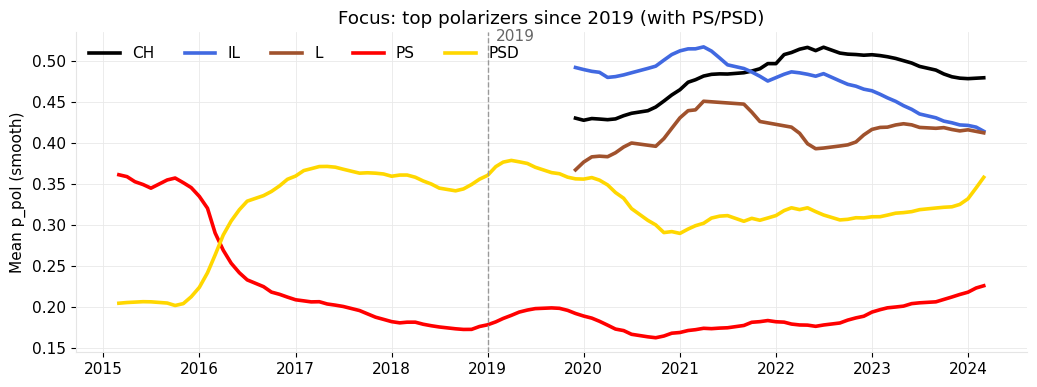

In [21]:
top3 = rank_2019.head(3).index.tolist()
bench = {"PS","PSD"}  # typische Vergleichsparteien
keep = list(dict.fromkeys(top3 + [p for p in d["party"].unique() if p in bench]))

sub = (d[d["party"].isin(keep)]
       .groupby(["party","month"])["p_pol_ensemble"].mean().reset_index())
sub["smooth"] = sub.groupby("party")["p_pol_ensemble"].transform(
    lambda s: s.ewm(span=9, adjust=False).mean().rolling(6, min_periods=3).mean()
)
plt.figure(figsize=(10.5,4.0))
for party, ss in sub.groupby("party"):
    plt.plot(ss["month"], ss["smooth"], lw=2.6, label=party, color=COL.get(party,"gray"))
plt.axvline(pd.to_datetime("2019-01-01"), color="#999", lw=1, ls="--")
plt.text(pd.to_datetime("2019-02-01"), 0.98*plt.ylim()[1], "2019", color="#666")
plt.ylabel("Mean p_pol (smooth)"); plt.title("Focus: top polarizers since 2019 (with PS/PSD)")
plt.legend(ncol=6, frameon=False); plt.tight_layout()
plt.savefig(SAVE_DIR/"focus_top_since2019.png", dpi=200); plt.show()


In [22]:
def winner_sentence(rk, label):
    lead = rk.index[0]
    m, p75, sl = rk.iloc[0].values
    msg = (f"{label}: {lead} has the highest average polarization "
           f"(mean={m:.3f}, 75p={p75:.3f}), "
           f"and an annualized slope of {sl:.3f} points/year.")
    print(msg)

winner_sentence(rank_all,  "Overall")
winner_sentence(rank_2019, "Since 2019")


Overall: CH has the highest average polarization (mean=0.483, 75p=0.757), and an annualized slope of 0.010 points/year.
Since 2019: CH has the highest average polarization (mean=0.483, 75p=0.757), and an annualized slope of 0.010 points/year.


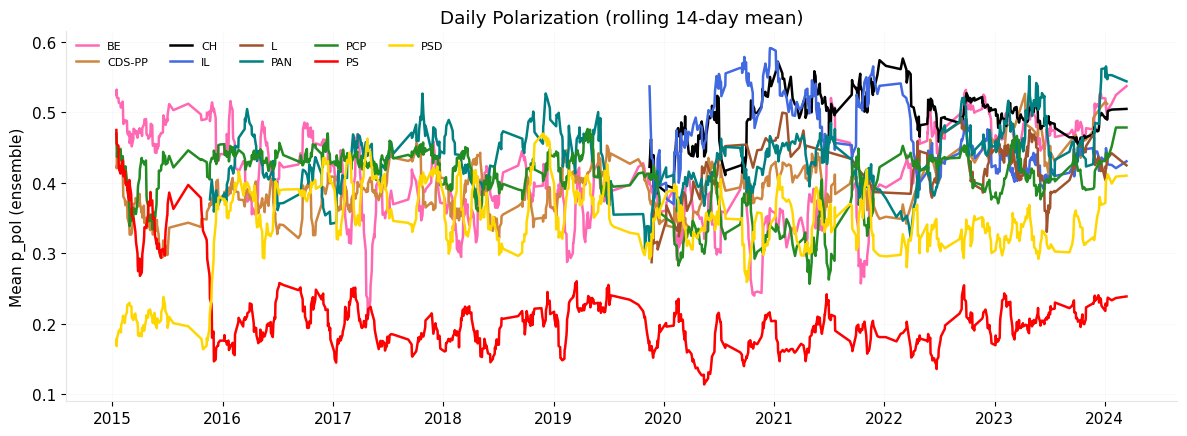

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Use the same cleaned dataframe 'd' and party color map 'COL'
daily = (
    d.groupby(["party", d["date"].dt.date])["p_pol_ensemble"]
     .mean()
     .reset_index()
     .rename(columns={"date": "day"})
)
daily["day"] = pd.to_datetime(daily["day"])

# Smooth using 14-day rolling average (or adjust to 7 for weekly)
WINDOW = 14
daily["p_pol_smooth"] = daily.groupby("party")["p_pol_ensemble"].transform(
    lambda s: s.rolling(WINDOW, min_periods=max(3, WINDOW//3)).mean()
)

plt.figure(figsize=(12,4.5))
for party, sub in daily.groupby("party"):
    plt.plot(
        sub["day"],
        sub["p_pol_smooth"],
        label=party,
        color=COL.get(party, "gray"),
        linewidth=1.8,
    )

plt.ylabel("Mean p_pol (ensemble)")
plt.title(f"Daily Polarization (rolling {WINDOW}-day mean)")
plt.grid(alpha=0.3)
plt.legend(ncol=5, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig(SAVE_DIR / f"daily_polarization_roll{WINDOW}.png", dpi=180)
plt.show()


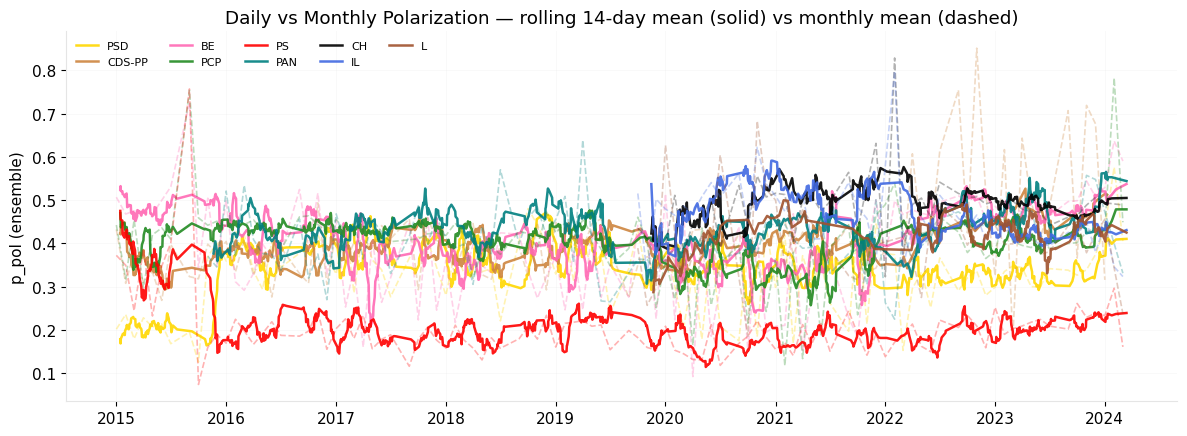

In [24]:
monthly = (
    d.groupby(["party", d["date"].dt.to_period("M").dt.to_timestamp()])["p_pol_ensemble"]
     .mean()
     .reset_index()
)

plt.figure(figsize=(12,4.5))
for party in d["party"].unique():
    daily_sub = daily[daily["party"] == party]
    month_sub = monthly[monthly["party"] == party]

    plt.plot(daily_sub["day"], daily_sub["p_pol_smooth"],
             color=COL.get(party,"gray"), linewidth=1.8, alpha=0.9, label=party)
    plt.plot(month_sub["date"], month_sub["p_pol_ensemble"],
             color=COL.get(party,"gray"), linewidth=1.2, alpha=0.3, linestyle="--")

plt.ylabel("p_pol (ensemble)")
plt.title(f"Daily vs Monthly Polarization — rolling {WINDOW}-day mean (solid) vs monthly mean (dashed)")
plt.grid(alpha=0.3)
plt.legend(ncol=5, fontsize=8, frameon=False)
plt.tight_layout()
plt.savefig(SAVE_DIR / f"daily_vs_monthly_roll{WINDOW}.png", dpi=180)
plt.show()


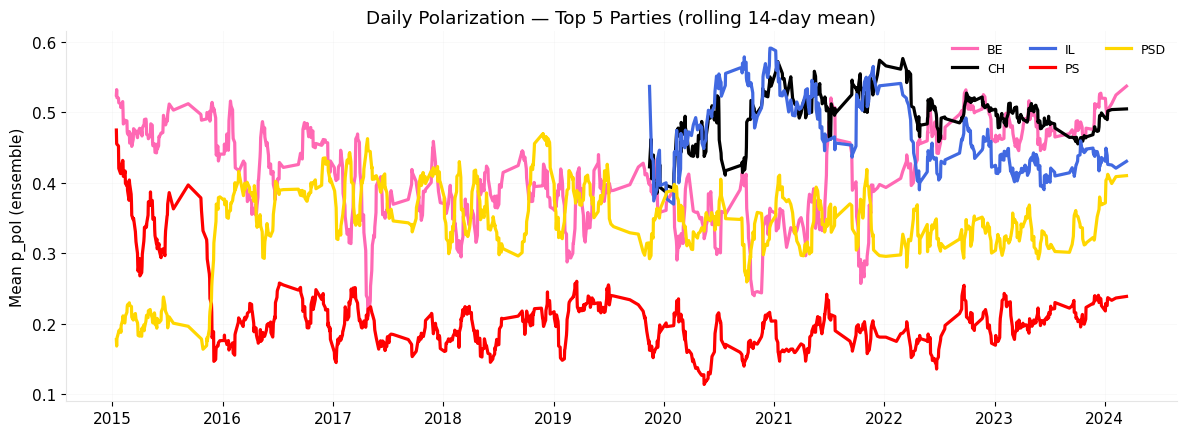

In [27]:
# Filter to those 5 main Portuguese parties
target_parties = ["PSD", "PS", "CH", "IL", "BE"]

daily = (
    d[d["party"].isin(target_parties)]
    .groupby(["party", d["date"].dt.date])["p_pol_ensemble"]
    .mean()
    .reset_index()
    .rename(columns={"date": "day"})
)
daily["day"] = pd.to_datetime(daily["day"])

WINDOW = 14
daily["p_pol_smooth"] = daily.groupby("party")["p_pol_ensemble"].transform(
    lambda s: s.rolling(WINDOW, min_periods=max(3, WINDOW // 3)).mean()
)

plt.figure(figsize=(12, 4.5))
for party, sub in daily.groupby("party"):
    plt.plot(
        sub["day"],
        sub["p_pol_smooth"],
        lw=2.3,
        label=party,
        color=COL.get(party, "gray"),
    )

plt.title(f"Daily Polarization — Top 5 Parties (rolling {WINDOW}-day mean)")
plt.ylabel("Mean p_pol (ensemble)")
plt.grid(alpha=0.3)
plt.legend(ncol=3, fontsize=9, frameon=False)
plt.tight_layout()
plt.savefig(SAVE_DIR / f"daily_polarization_top5_roll{WINDOW}.png", dpi=200)
plt.show()


In [29]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)

d0 = df.copy()
drop_parties = ["Independente", "Presidency", "nan", "NaN", "Government", "PEV"]
d0 = d0[~d0["party"].isin(drop_parties)].copy()
d0["party"] = d0["party"].astype(str).str.strip()
d0["month"] = d0["date"].dt.to_period("M").dt.to_timestamp()
d0["year"]  = d0["date"].dt.year

PARTY_COLORS = {
    "PS":"red", "PSD":"orange", "CHEGA":"black", "CH":"black",
    "IL":"blue", "BE":"magenta", "PCP":"green", "PAN":"teal",
    "CDS-PP":"goldenrod", "L":"brown"
}
def color_for(p): return PARTY_COLORS.get(p, "gray")


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# Welche Polarizations-Spalte wir nutzen
POL_COL = "p_pol_ensemble"

# Kopie + Grund-Cleaning
d0 = df.copy()

# Parteien, die du rauswerfen wolltest
drop_parties = ["Independente", "Presidency", "nan", "NaN", "Government", "PEV"]
d0 = d0[~d0["party"].isin(drop_parties)].copy()

# Party-Namen aufräumen
d0["party"] = d0["party"].astype(str).str.strip()

# Zeitspalten
d0["month"] = d0["date"].dt.to_period("M").dt.to_timestamp()
d0["year"]  = d0["date"].dt.year

# Optional: CHEGA vereinheitlichen (falls "CH" und "CHEGA" existieren)
d0["party"] = d0["party"].replace({"CH": "CHEGA"})

# Party-Farben
PARTY_COLORS = {
    "PS":"red", "PSD":"orange", "CHEGA":"black",
    "IL":"blue", "BE":"magenta", "PCP":"green", "PAN":"teal",
    "CDS-PP":"goldenrod", "L":"brown"
}
def color_for(p): 
    return PARTY_COLORS.get(p, "gray")

print("Spalten:", d0.columns.tolist())
print("Parteien:", sorted(d0["party"].unique()))


Spalten: ['speech_id', 'date', 'intervention_id', 'speaker_id', 'speaker_name', 'party', 'role', 'text', 'text_length', 'topic', 'addressed_to', 'u_num', 'speech_doc', 'gpt5nano_p_pol', 'xlmr_p_pol', 'p_pol_ensemble', 'month', 'year']
Parteien: ['BE', 'CDS-PP', 'CHEGA', 'IL', 'L', 'PAN', 'PCP', 'PS', 'PSD']


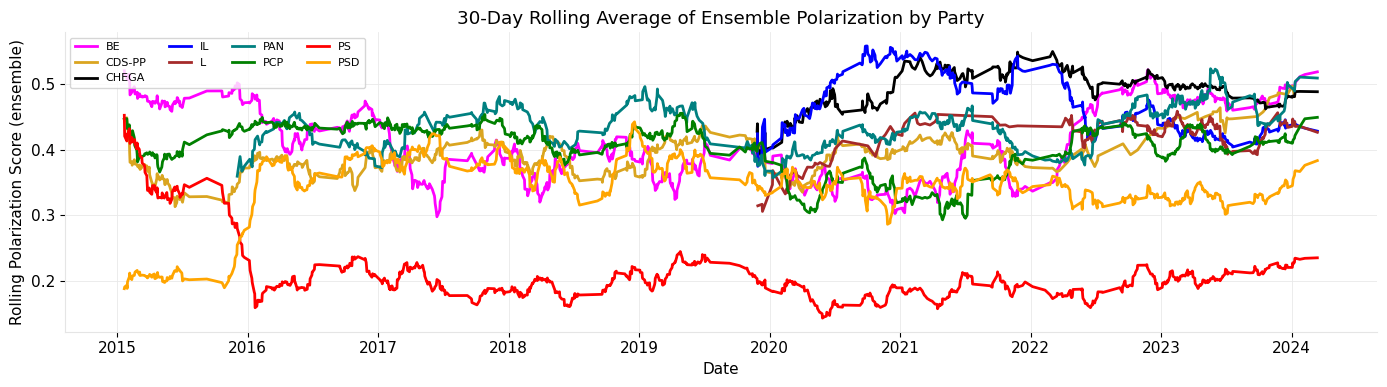

In [32]:
d = d0.copy()

# täglicher Mittelwert je Partei
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])

# 30-Tage Rolling
daily["pol_roll30"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(30, min_periods=7).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub["pol_roll30"],
             label=party, color=color_for(party), linewidth=2)

plt.title("30-Day Rolling Average of Ensemble Polarization by Party")
plt.ylabel("Rolling Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling30_p_pol_ensemble_by_party.png", dpi=300)
plt.show()


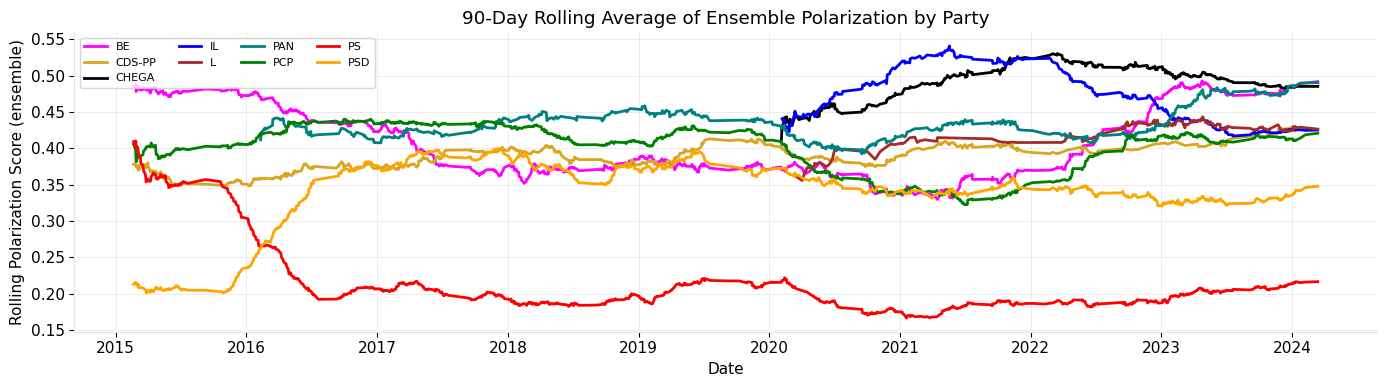

In [33]:
d = d0.copy()

daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])

daily["pol_roll90"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(90, min_periods=20).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub["pol_roll90"],
             label=party, color=color_for(party), linewidth=2)

plt.title("90-Day Rolling Average of Ensemble Polarization by Party")
plt.ylabel("Rolling Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling90_p_pol_ensemble_by_party.png", dpi=300)
plt.show()


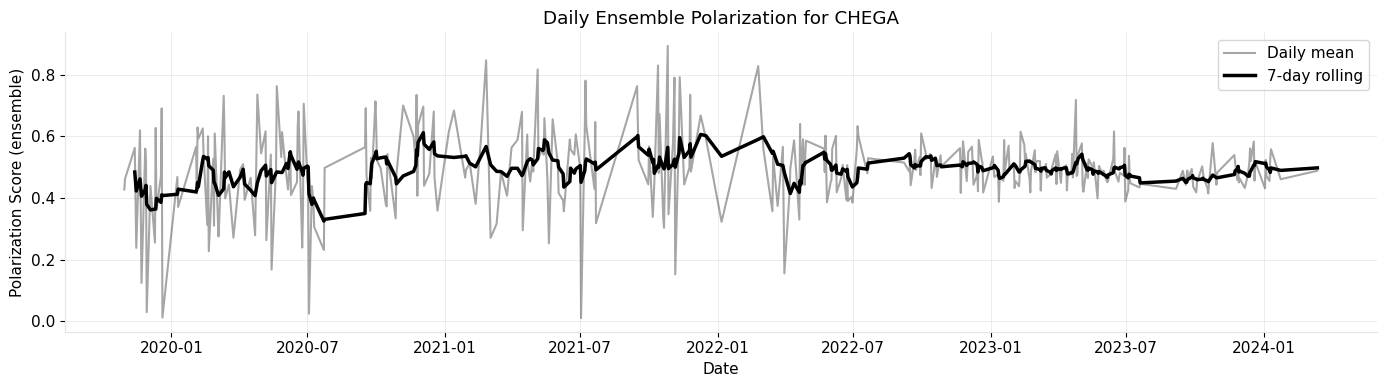

In [34]:
FOCUS = "CHEGA"

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily["pol_roll7"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(7, min_periods=3).mean())
)

sub = daily[daily["party"] == FOCUS]

plt.figure(figsize=(14,4))
plt.plot(sub["date"], sub["pol_mean"],
         alpha=0.35, label="Daily mean", color=color_for(FOCUS))
plt.plot(sub["date"], sub["pol_roll7"],
         linewidth=2.5, label="7-day rolling", color=color_for(FOCUS))

plt.title(f"Daily Ensemble Polarization for {FOCUS}")
plt.ylabel("Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR/f"chega_daily_7day_p_pol_ensemble.png", dpi=300)
plt.show()


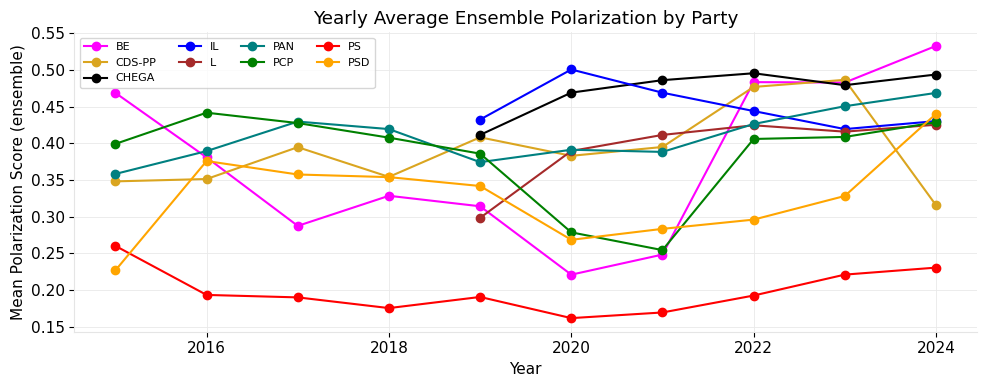

In [35]:
d = d0.copy()

yearly = (
    d.groupby(["party", "year"])[POL_COL]
     .mean()
     .reset_index(name="pol_year")
)

plt.figure(figsize=(10,4))
for party, sub in yearly.groupby("party"):
    plt.plot(sub["year"], sub["pol_year"], marker="o",
             label=party, color=color_for(party))

plt.title("Yearly Average Ensemble Polarization by Party")
plt.xlabel("Year")
plt.ylabel("Mean Polarization Score (ensemble)")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"yearly_p_pol_ensemble_by_party.png", dpi=300)
plt.show()


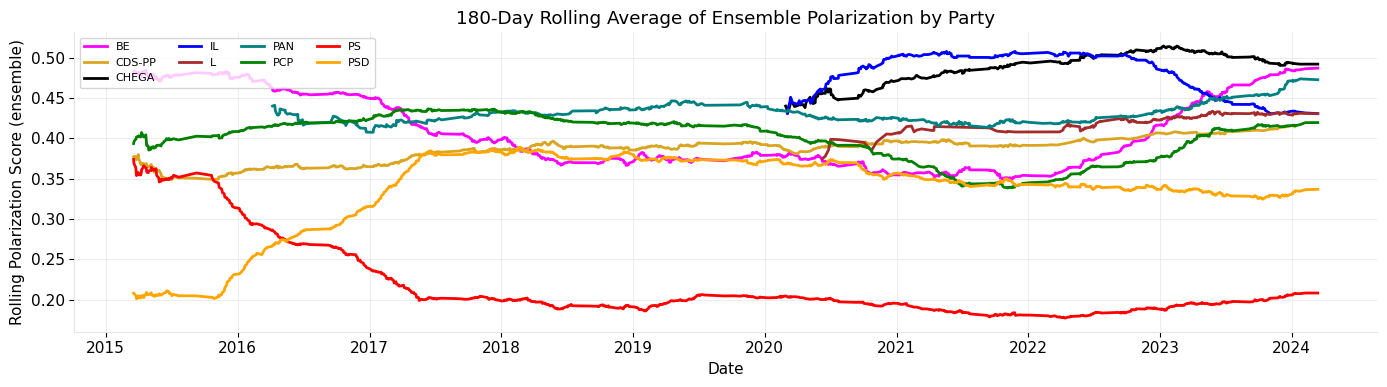

In [37]:
ROLL = 180  # Window length

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, color=color_for(party), linewidth=2)

plt.title(f"{ROLL}-Day Rolling Average of Ensemble Polarization by Party")
plt.ylabel("Rolling Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/f"rolling{ROLL}_ensemble_by_party.png", dpi=300)
plt.show()


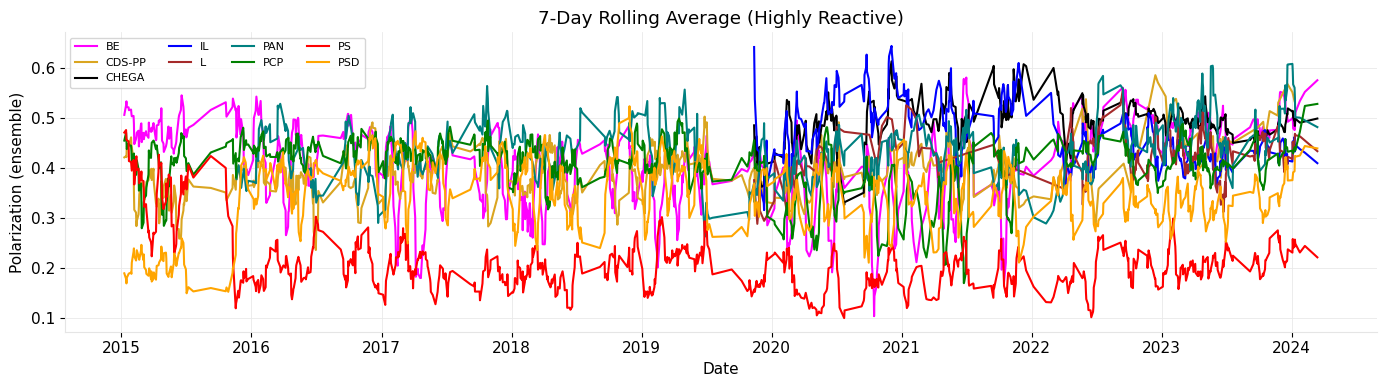

In [38]:
ROLL = 7

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=3).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, color=color_for(party), linewidth=1.5)

plt.title(f"{ROLL}-Day Rolling Average (Highly Reactive)")
plt.ylabel("Polarization (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/f"rolling{ROLL}_ensemble_reactive.png", dpi=300)
plt.show()


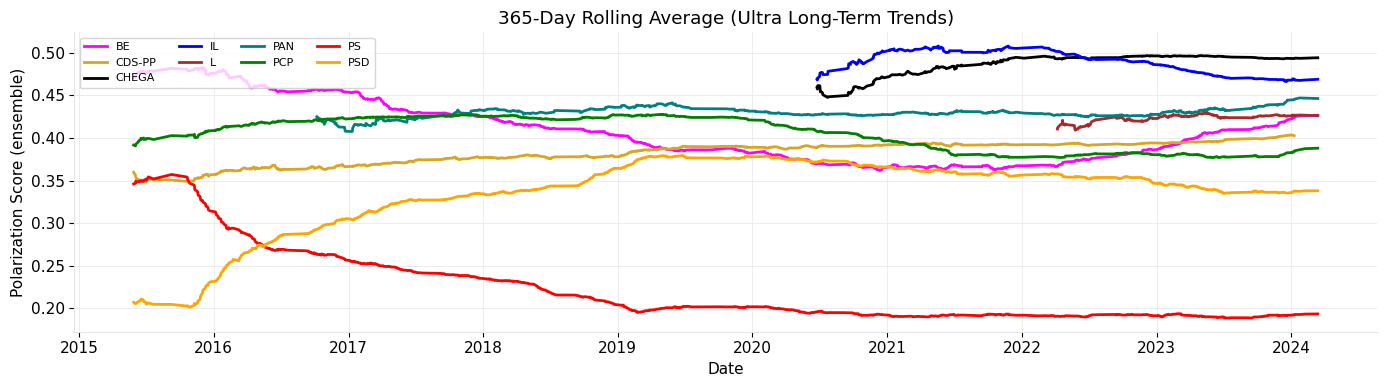

In [40]:
ROLL = 365

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=60).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, color=color_for(party), linewidth=2)

plt.title(f"{ROLL}-Day Rolling Average (Ultra Long-Term Trends)")
plt.ylabel("Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/f"rolling{ROLL}_longterm.png", dpi=300)
plt.show()


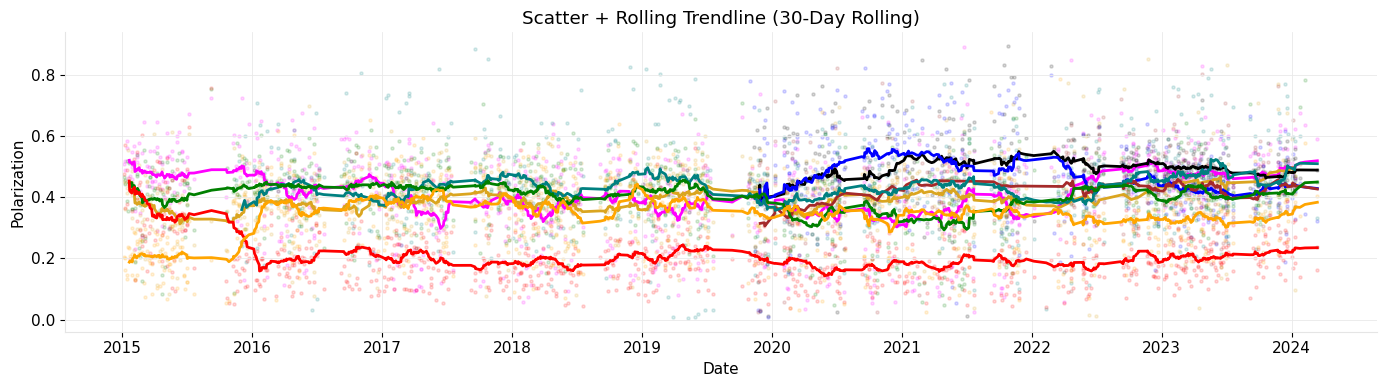

In [41]:
ROLL = 30

d = d0.copy()
daily_raw = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)

daily_raw = daily_raw.sort_values(["party", "date"])
daily_raw[f"roll{ROLL}"] = (
    daily_raw.groupby("party")["pol_mean"]
             .transform(lambda s: s.rolling(ROLL, min_periods=7).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily_raw.groupby("party"):
    # raw scatter
    plt.scatter(sub["date"], sub["pol_mean"], 
                color=color_for(party), s=5, alpha=0.15)
    # rolling line
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             color=color_for(party), linewidth=2)

plt.title("Scatter + Rolling Trendline (30-Day Rolling)")
plt.ylabel("Polarization")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(SAVE_DIR/f"scatter_plus_roll{ROLL}.png", dpi=300)
plt.show()


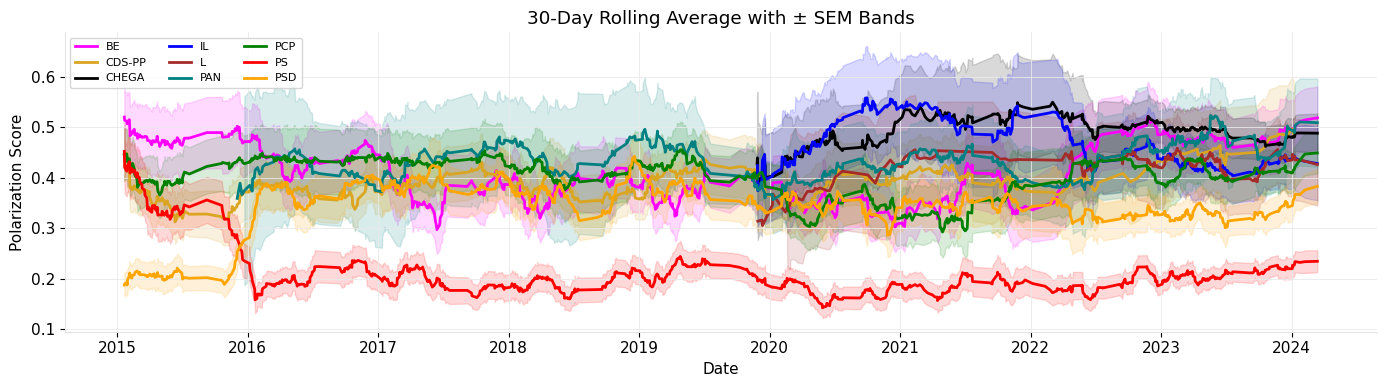

In [42]:
ROLL = 30

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .agg(["mean", "std", "count"])
     .reset_index()
)
daily = daily.sort_values(["party", "date"])

daily["sem"] = daily["std"] / np.sqrt(daily["count"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=7).mean())
)
daily[f"sem_roll{ROLL}"] = (
    daily.groupby("party")["sem"]
         .transform(lambda s: s.rolling(ROLL, min_periods=7).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    mean_line = sub[f"roll{ROLL}"]
    sem_line  = sub[f"sem_roll{ROLL}"]
    plt.plot(sub["date"], mean_line,
             color=color_for(party), linewidth=2, label=party)
    plt.fill_between(sub["date"], 
                     mean_line - sem_line, 
                     mean_line + sem_line,
                     color=color_for(party),
                     alpha=0.15)

plt.title("30-Day Rolling Average with ± SEM Bands")
plt.ylabel("Polarization Score")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling30_with_sem_bands.png", dpi=300)
plt.show()


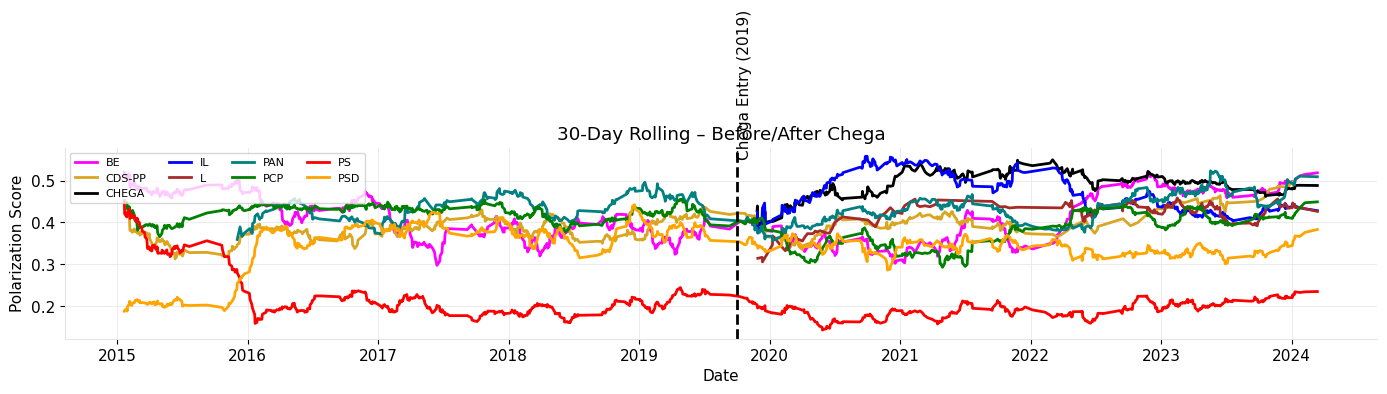

In [43]:
ROLL = 30
CHEGA_ENTRY = "2019-10-01"

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=7).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, color=color_for(party), linewidth=2)

# vertical line
plt.axvline(pd.to_datetime(CHEGA_ENTRY), color="black", linestyle="--", linewidth=2)
plt.text(pd.to_datetime(CHEGA_ENTRY), 0.55, "Chega Entry (2019)", 
         rotation=90, va="bottom")

plt.title(f"{ROLL}-Day Rolling – Before/After Chega")
plt.ylabel("Polarization Score")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling30_before_after_chega.png", dpi=300)
plt.show()


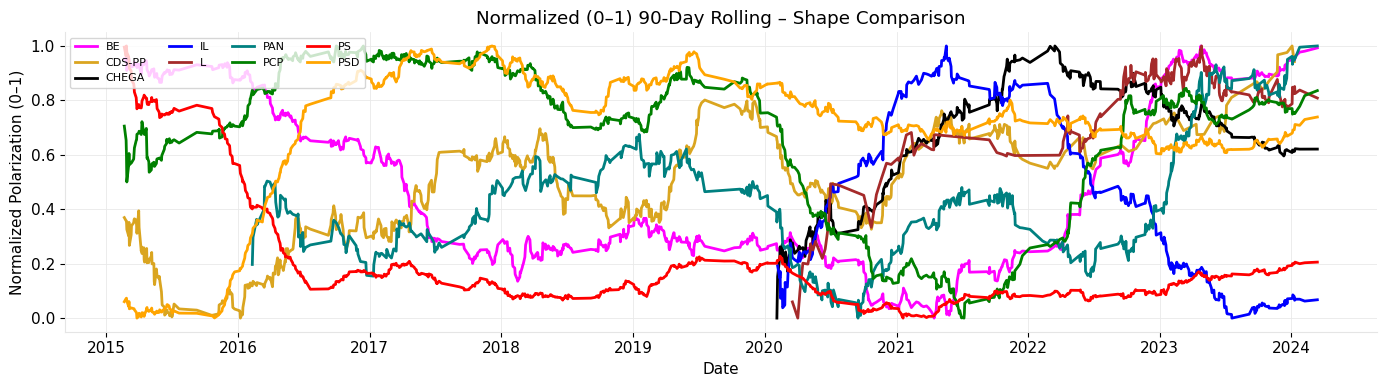

In [44]:
ROLL = 90

d = d0.copy()
daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])
daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=20).mean())
)

# normalisieren
daily["norm"] = daily.groupby("party")[f"roll{ROLL}"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub["norm"],
             label=party, linewidth=2, color=color_for(party))

plt.title("Normalized (0–1) 90-Day Rolling – Shape Comparison")
plt.ylabel("Normalized Polarization (0–1)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=4, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling90_normalized.png", dpi=300)
plt.show()


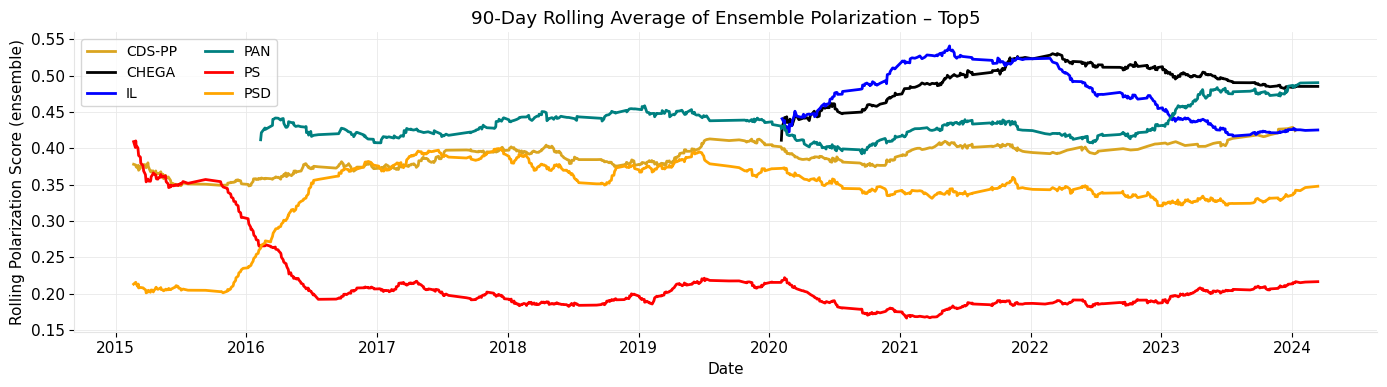

In [48]:
# Vorausgesetzt: dein d0 DataFrame existiert und POL_COL = "p_pol_ensemble"
import matplotlib.pyplot as plt
from pathlib import Path

SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# Liste der Top5 Parteien
top5 = ["CDS-PP", "PS", "CHEGA", "IL", "PSD","PAN"]

# Falls dein Dataset andere Kürzel nutzt, hier anpassen:
# z.B. wenn "AD" nicht direkt in df["party"] existiert sondern "PSD/CDS-PP/AD", etc.

ROLL = 90

d = d0.copy()
# Filter für Top5
d = d[d["party"].isin(top5)].copy()

daily = (
    d.groupby(["party", "date"])[POL_COL]
     .mean()
     .reset_index(name="pol_mean")
)
daily = daily.sort_values(["party", "date"])

daily[f"roll{ROLL}"] = (
    daily.groupby("party")["pol_mean"]
         .transform(lambda s: s.rolling(ROLL, min_periods=20).mean())
)

plt.figure(figsize=(14,4))
for party, sub in daily.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, color=color_for(party), linewidth=2)

plt.title(f"{ROLL}-Day Rolling Average of Ensemble Polarization – Top5")
plt.ylabel("Rolling Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=2, fontsize=10)
plt.tight_layout()
plt.savefig(SAVE_DIR/f"rolling{ROLL}_top5_portugal.png", dpi=300)
plt.show()


In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

POL_COL = "p_pol_ensemble"

d_sent = d0.copy()

# Regierungsperioden Portugal (vereinfachtes Modell für 2015–2024)
# 2015–2024 = PS-Regierung
# Vor 26.11.2015 = PSD/CDS-PP Regierung
periods = [
    {
        "start": pd.Timestamp("2011-06-21"),
        "end":   pd.Timestamp("2015-11-26"),
        "gov_parties": ["PSD", "CDS-PP"]
    },
    {
        "start": pd.Timestamp("2015-11-26"),
        "end":   pd.Timestamp("2019-10-26"),
        "gov_parties": ["PS"]
    },
    {
        "start": pd.Timestamp("2019-10-26"),
        "end":   pd.Timestamp("2022-03-30"),
        "gov_parties": ["PS"]
    },
    {
        "start": pd.Timestamp("2022-03-30"),
        "end":   pd.Timestamp("2024-04-02"),
        "gov_parties": ["PS"]
    },
]

def classify_bloc(row):
    dt = row["date"]
    party = row["party"]
    for p in periods:
        if p["start"] <= dt < p["end"]:
            return "Governing" if party in p["gov_parties"] else "Opposition"
    return np.nan

d_sent["bloc"] = d_sent.apply(classify_bloc, axis=1)
d_sent = d_sent.dropna(subset=["bloc"]).copy()

print(d_sent[["date","party","bloc",POL_COL]].head())


        date   party       bloc  p_pol_ensemble
0 2015-01-07     PSD  Governing        0.044001
1 2015-01-07     PSD  Governing        0.028455
2 2015-01-07     PSD  Governing        0.022303
3 2015-01-07  CDS-PP  Governing        0.029728
4 2015-01-07     PSD  Governing        0.246363


In [51]:
ROLL = 180  # Window kannst du anpassen (180/365/90)

daily_bloc = (
    d_sent.groupby(["bloc", "date"])[POL_COL]
          .mean()
          .reset_index(name="pol_mean")
)

daily_bloc = daily_bloc.sort_values(["bloc", "date"])

daily_bloc[f"roll{ROLL}"] = (
    daily_bloc.groupby("bloc")["pol_mean"]
              .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)


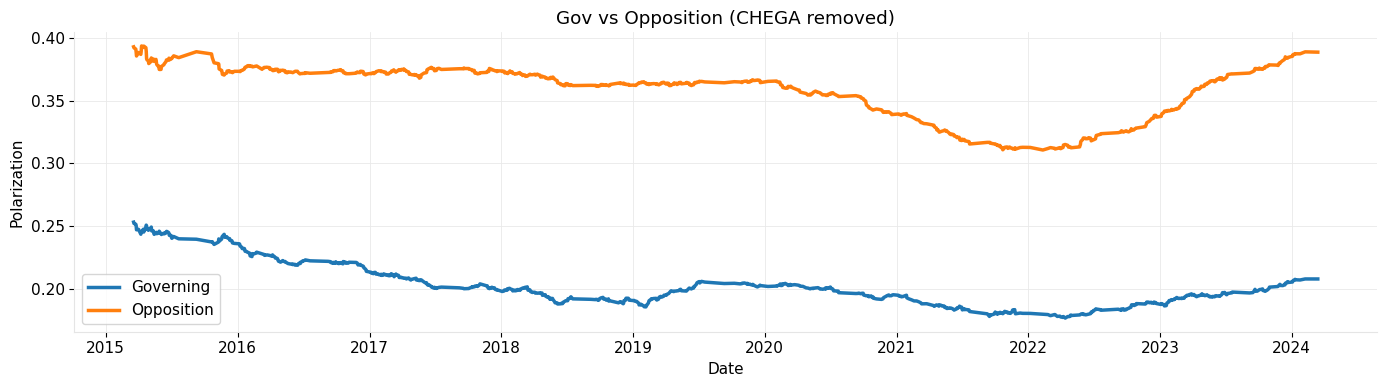

In [53]:
ROLL = 180

d_filt = d_sent.copy()
d_filt = d_filt[~((d_filt["bloc"]=="Opposition") & (d_filt["party"]=="CHEGA"))]

daily_bloc_no_ch = (
    d_filt.groupby(["bloc", "date"])[POL_COL]
          .mean()
          .reset_index(name="pol_mean")
)

daily_bloc_no_ch = daily_bloc_no_ch.sort_values(["bloc","date"])
daily_bloc_no_ch[f"roll{ROLL}"] = (
    daily_bloc_no_ch.groupby("bloc")["pol_mean"]
                     .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

plt.figure(figsize=(14,4))
for bloc, sub in daily_bloc_no_ch.groupby("bloc"):
    color = "tab:blue" if bloc=="Governing" else "tab:orange"
    plt.plot(sub["date"], sub[f"roll{ROLL}"], label=bloc, color=color, linewidth=2.5)

plt.title("Gov vs Opposition (CHEGA removed)")
plt.ylabel("Polarization")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR/f"gov_vs_opposition_no_chega_roll{ROLL}.png", dpi=300)
plt.show()


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Falls noch nicht gesetzt:
# SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)
# POL_COL = "p_pol_ensemble"

d_sent = d0.copy()
d_sent["date"] = pd.to_datetime(d_sent["date"])

periods = [
    {"start": pd.Timestamp("2011-06-21"), "end": pd.Timestamp("2015-11-26"),
     "gov_parties": ["PSD", "CDS-PP"]},
    {"start": pd.Timestamp("2015-11-26"), "end": pd.Timestamp("2019-10-26"),
     "gov_parties": ["PS"]},
    {"start": pd.Timestamp("2019-10-26"), "end": pd.Timestamp("2022-03-30"),
     "gov_parties": ["PS"]},
    {"start": pd.Timestamp("2022-03-30"), "end": pd.Timestamp("2024-04-02"),
     "gov_parties": ["PS"]},
]

def classify_bloc(row):
    dt = row["date"]
    party = row["party"]
    for p in periods:
        if p["start"] <= dt < p["end"]:
            return "Governing" if party in p["gov_parties"] else "Opposition"
    return np.nan

d_sent["bloc"] = d_sent.apply(classify_bloc, axis=1)
d_sent = d_sent.dropna(subset=["bloc"]).copy()
print(d_sent[["date","party","bloc",POL_COL]].head())


        date   party       bloc  p_pol_ensemble
0 2015-01-07     PSD  Governing        0.044001
1 2015-01-07     PSD  Governing        0.028455
2 2015-01-07     PSD  Governing        0.022303
3 2015-01-07  CDS-PP  Governing        0.029728
4 2015-01-07     PSD  Governing        0.246363


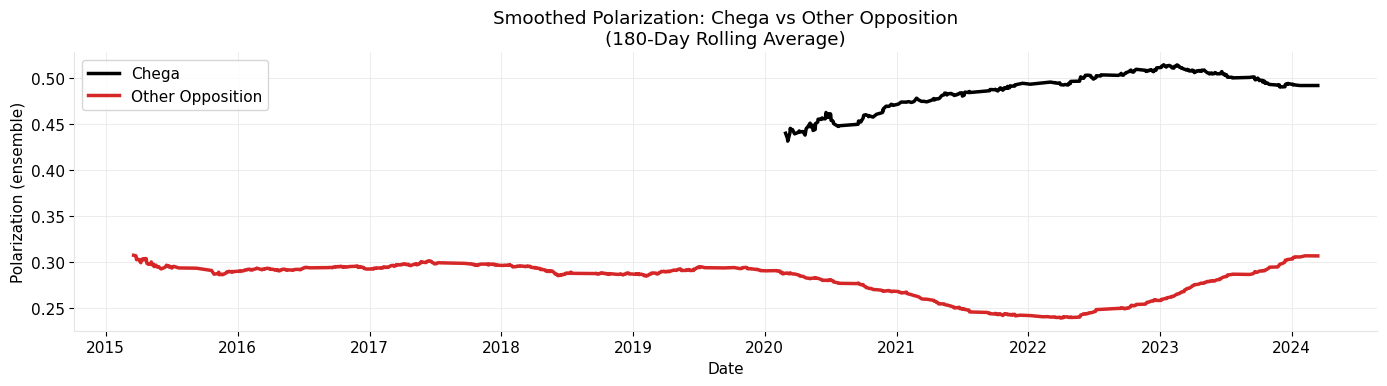

In [57]:
ROLL = 180

d_chega = d_sent.copy()
d_chega["bloc2"] = np.where(
    (d_chega["bloc"]=="Opposition") & (d_chega["party"]=="CHEGA"),
    "Chega",
    "Other Opposition"
)

daily_ce = (
    d_chega.groupby(["bloc2", "date"])[POL_COL]
            .mean()
            .reset_index(name="pol_mean")
)
daily_ce = daily_ce.sort_values(["bloc2","date"])
daily_ce[f"roll{ROLL}"] = (
    daily_ce.groupby("bloc2")["pol_mean"]
            .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

plt.figure(figsize=(14,4))
colors = {"Chega":"black", "Other Opposition":"tab:red"}

for bloc, sub in daily_ce.groupby("bloc2"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=bloc, color=colors[bloc], linewidth=2.5)

plt.title(f"Smoothed Polarization: Chega vs Other Opposition\n({ROLL}-Day Rolling Average)")
plt.ylabel("Polarization (ensemble)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / f"chega_vs_other_opp_roll{ROLL}.png", dpi=300)
plt.show()


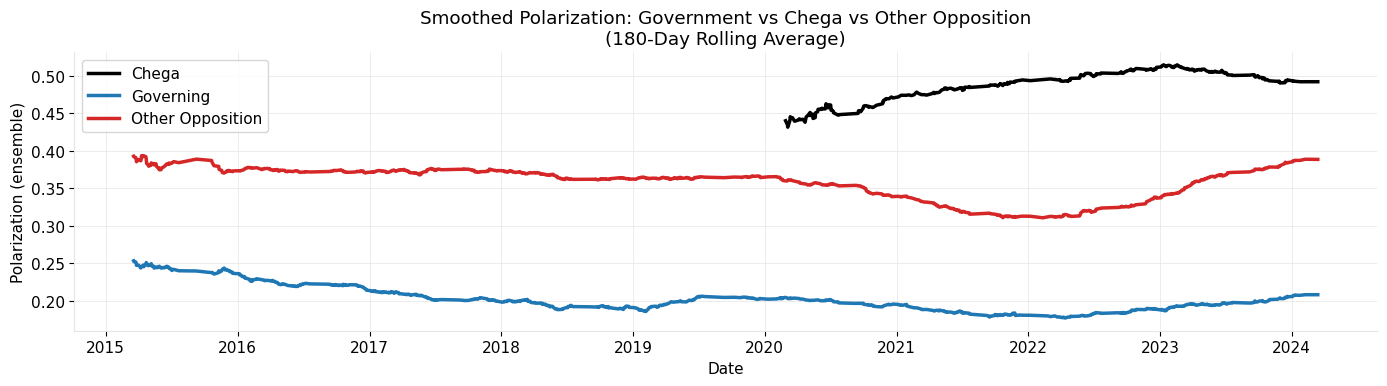

In [58]:
ROLL = 180

d3 = d_sent.copy()
d3["bloc3"] = d3["bloc"]
d3.loc[(d3["bloc"]=="Opposition") & (d3["party"]=="CHEGA"), "bloc3"] = "Chega"
d3.loc[(d3["bloc"]=="Opposition") & (d3["party"]!="CHEGA"), "bloc3"] = "Other Opposition"

daily3 = (
    d3.groupby(["bloc3","date"])[POL_COL]
       .mean()
       .reset_index(name="pol_mean")
)
daily3 = daily3.sort_values(["bloc3","date"])
daily3[f"roll{ROLL}"] = (
    daily3.groupby("bloc3")["pol_mean"]
          .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

plt.figure(figsize=(14,4))
colors = {"Governing":"tab:blue", "Chega":"black", "Other Opposition":"tab:red"}

for bloc, sub in daily3.groupby("bloc3"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=bloc, color=colors[bloc], linewidth=2.5)

plt.title(f"Smoothed Polarization: Government vs Chega vs Other Opposition\n({ROLL}-Day Rolling Average)")
plt.ylabel("Polarization (ensemble)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.savefig(SAVE_DIR / f"gov_chega_other_opp_roll{ROLL}.png", dpi=300)
plt.show()


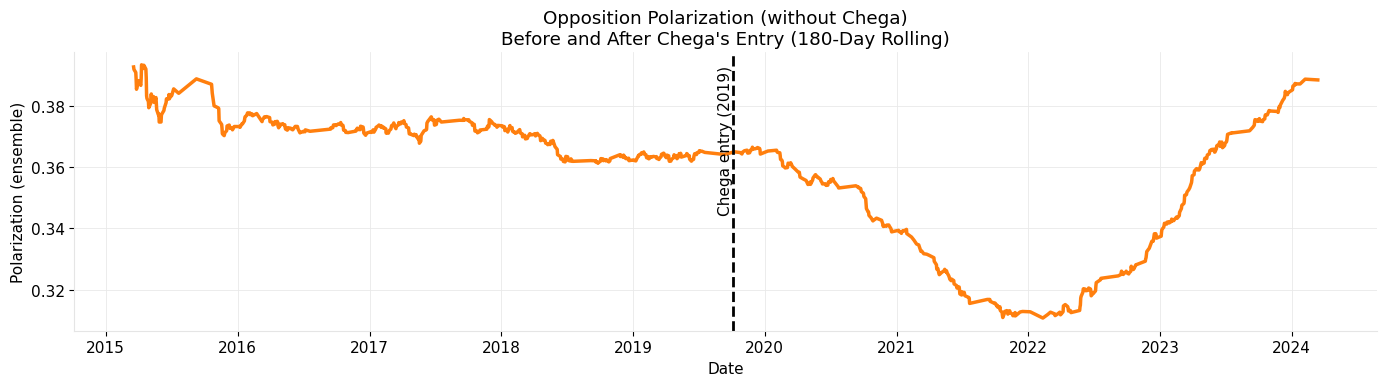

In [59]:
ROLL = 180
CHEGA_ENTRY = pd.Timestamp("2019-10-06")  # Wahl 2019

# Opposition ohne Chega
d_opp_no_ch = d_sent[(d_sent["bloc"]=="Opposition") & (d_sent["party"]!="CHEGA")].copy()

daily_opp = (
    d_opp_no_ch.groupby("date")[POL_COL]
               .mean()
               .reset_index(name="pol_mean")
)
daily_opp = daily_opp.sort_values("date")
daily_opp[f"roll{ROLL}"] = daily_opp["pol_mean"].rolling(ROLL, min_periods=30).mean()

plt.figure(figsize=(14,4))
plt.plot(daily_opp["date"], daily_opp[f"roll{ROLL}"], color="tab:orange", linewidth=2.5)
plt.axvline(CHEGA_ENTRY, color="black", linestyle="--", linewidth=2)
plt.text(CHEGA_ENTRY, daily_opp[f"roll{ROLL}"].max(),
         "Chega entry (2019)", rotation=90, va="top", ha="right")

plt.title(f"Opposition Polarization (without Chega)\nBefore and After Chega's Entry ({ROLL}-Day Rolling)")
plt.ylabel("Polarization (ensemble)")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(SAVE_DIR / f"opp_no_chega_before_after_2019_roll{ROLL}.png", dpi=300)
plt.show()


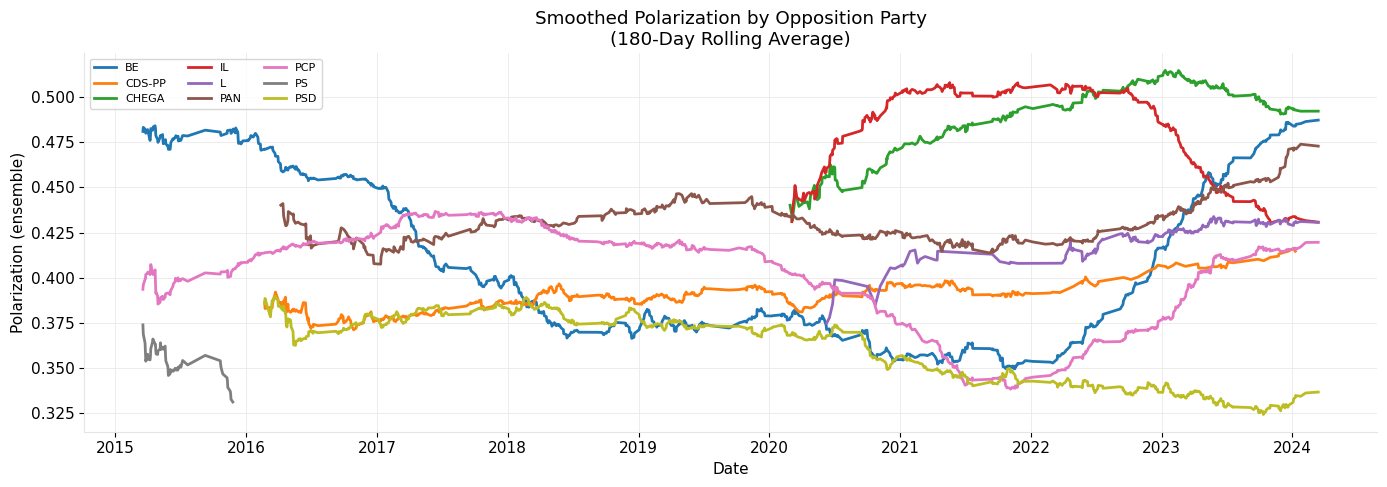

In [60]:
ROLL = 180

d_opp = d_sent[d_sent["bloc"]=="Opposition"].copy()

daily_opp_party = (
    d_opp.groupby(["party","date"])[POL_COL]
         .mean()
         .reset_index(name="pol_mean")
)
daily_opp_party = daily_opp_party.sort_values(["party","date"])
daily_opp_party[f"roll{ROLL}"] = (
    daily_opp_party.groupby("party")["pol_mean"]
                   .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

plt.figure(figsize=(14,5))
for party, sub in daily_opp_party.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party, linewidth=2)

plt.title(f"Smoothed Polarization by Opposition Party\n({ROLL}-Day Rolling Average)")
plt.ylabel("Polarization (ensemble)")
plt.xlabel("Date")
plt.legend(loc="upper left", ncol=3, fontsize=8)
plt.tight_layout()
plt.savefig(SAVE_DIR / f"opposition_parties_roll{ROLL}.png", dpi=300)
plt.show()


In [61]:
from scipy import stats

gov_vals = d_sent.loc[d_sent["bloc"]=="Governing", POL_COL].dropna()
opp_vals = d_sent.loc[d_sent["bloc"]=="Opposition", POL_COL].dropna()

print("N Governing:", len(gov_vals), "N Opposition:", len(opp_vals))
print("Mean Governing:", gov_vals.mean())
print("Mean Opposition:", opp_vals.mean())

# Welch t-test (ungleiche Varianzen)
t_stat, p_val = stats.ttest_ind(opp_vals, gov_vals, equal_var=False)
print("\nWelch t-test Opposition vs Governing")
print("t =", t_stat, " p =", p_val)

# Effect size (Cohen's d)
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / (nx+ny-2))
    return (x.mean() - y.mean()) / pooled_std

d_effect = cohens_d(opp_vals, gov_vals)
print("Cohen's d (Opp - Gov):", d_effect)


N Governing: 94586 N Opposition: 148903
Mean Governing: 0.19770916281638704
Mean Opposition: 0.36808252465238145

Welch t-test Opposition vs Governing
t = 154.64092065520944  p = 0.0
Cohen's d (Opp - Gov): 0.6135012539433181


In [62]:
import pandas as pd
import matplotlib.pyplot as plt

POL_COL = "p_pol_ensemble"

d = d0.copy()
d["month"] = d["date"].dt.to_period("M").dt.to_timestamp()

monthly = (
    d.groupby(["party", "month"])[POL_COL]
      .mean()
      .reset_index(name="monthly_mean")
)


In [63]:
monthly = monthly.sort_values(["party","month"])

monthly["smooth"] = (
    monthly.groupby("party")["monthly_mean"]
           .transform(lambda s: s.rolling(6, min_periods=2).mean())
)


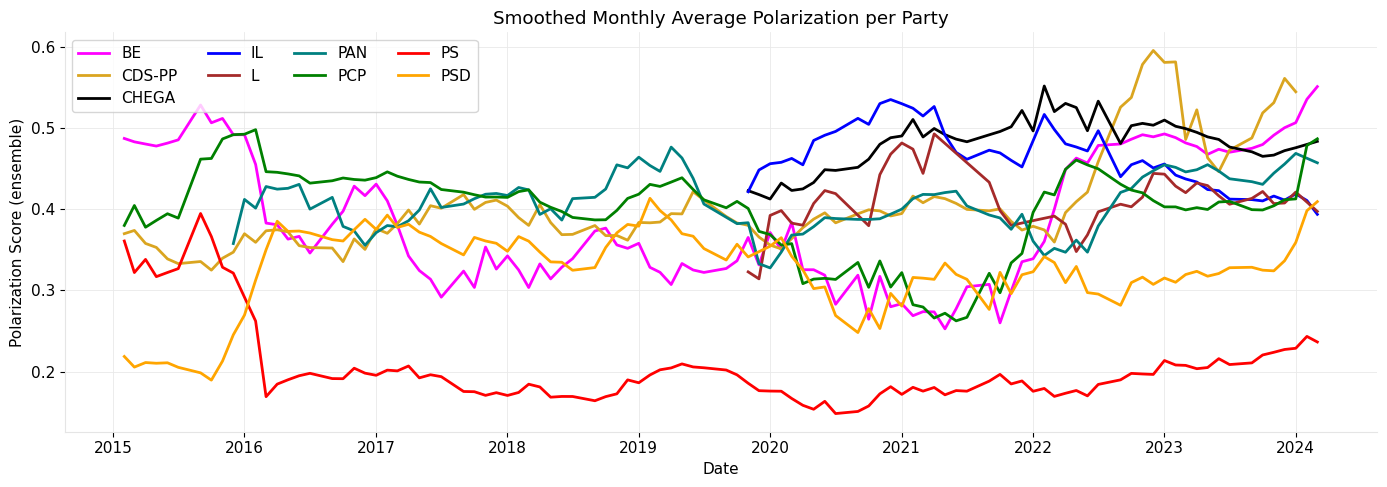

In [64]:
plt.figure(figsize=(14,5))

for party, sub in monthly.groupby("party"):
    plt.plot(sub["month"], sub["smooth"],
             label=party, linewidth=2, color=color_for(party))

plt.title("Smoothed Monthly Average Polarization per Party")
plt.ylabel("Polarization Score (ensemble)")
plt.xlabel("Date")
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig(SAVE_DIR/"monthly_smoothed_polarization.png", dpi=300)
plt.show()


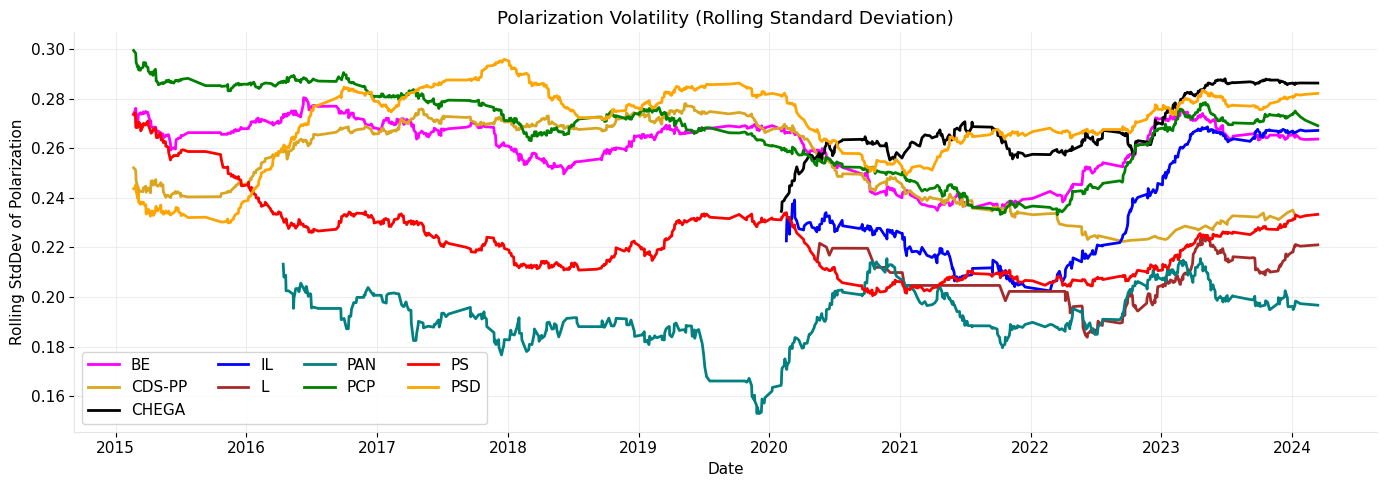

In [65]:
ROLL = 90

vol = (
    d0.groupby(["party", "date"])[POL_COL]
      .std()
      .reset_index(name="std_dev")
)

vol = vol.sort_values(["party","date"])
vol[f"roll{ROLL}"] = (
    vol.groupby("party")["std_dev"]
       .transform(lambda s: s.rolling(ROLL, min_periods=20).mean())
)

plt.figure(figsize=(14,5))
for party, sub in vol.groupby("party"):
    plt.plot(sub["date"], sub[f"roll{ROLL}"], label=party, linewidth=2, color=color_for(party))

plt.title("Polarization Volatility (Rolling Standard Deviation)")
plt.ylabel("Rolling StdDev of Polarization")
plt.xlabel("Date")
plt.legend(ncol=4)
plt.tight_layout()
plt.savefig(SAVE_DIR/"rolling_volatility.png", dpi=300)
plt.show()


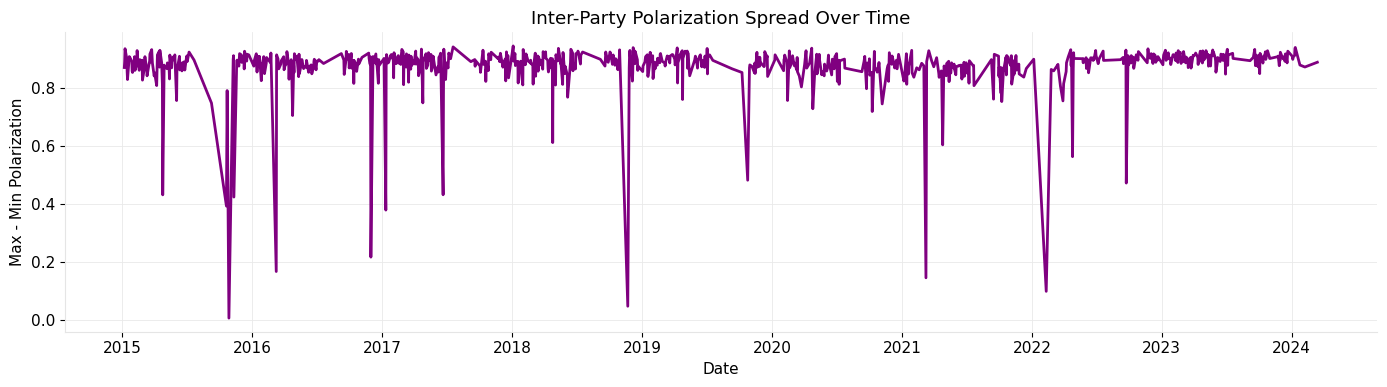

In [66]:
spread = (
    d0.groupby("date")[POL_COL].agg(["mean","min","max"])
)
spread["range"] = spread["max"] - spread["min"]

plt.figure(figsize=(14,4))
plt.plot(spread.index, spread["range"], color="purple", linewidth=2)
plt.title("Inter-Party Polarization Spread Over Time")
plt.ylabel("Max - Min Polarization")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(SAVE_DIR/"spread_polarization.png", dpi=300)
plt.show()


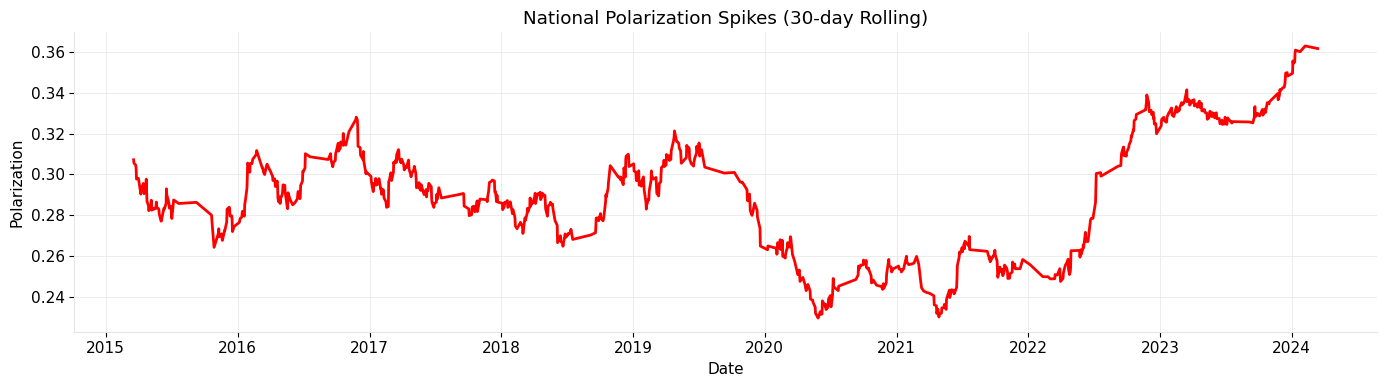

In [69]:
event = (
    d0.groupby("date")[POL_COL].mean()
).rolling(30).mean()

plt.figure(figsize=(14,4))
plt.plot(event.index, event, color="red", linewidth=2)
plt.title("National Polarization Spikes (30-day Rolling)")
plt.ylabel("Polarization")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


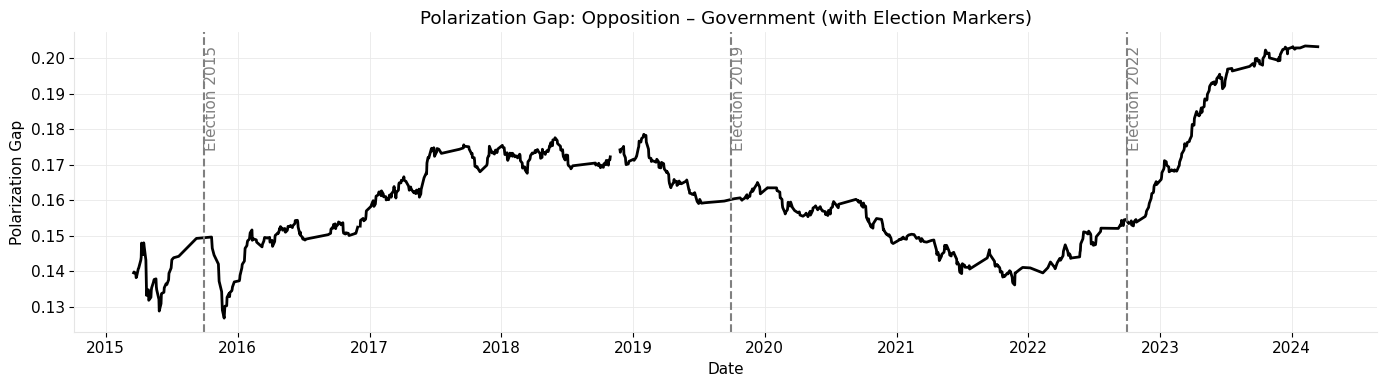

In [70]:
# BUILD pivot (NEEDED!)
ROLL = 180

daily_bloc = (
    d_sent.groupby(["bloc", "date"])[POL_COL]
          .mean()
          .reset_index(name="pol_mean")
)

daily_bloc = daily_bloc.sort_values(["bloc","date"])
daily_bloc[f"roll{ROLL}"] = (
    daily_bloc.groupby("bloc")["pol_mean"]
              .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

pivot = daily_bloc.pivot(index="date", columns="bloc", values=f"roll{ROLL}")
pivot["gap_opp_minus_gov"] = pivot["Opposition"] - pivot["Governing"]

# NOW plot
plt.figure(figsize=(14,4))
plt.plot(pivot.index, pivot["gap_opp_minus_gov"], color="black", linewidth=2)

for year in [2015, 2019, 2022]:
    plt.axvline(pd.to_datetime(f"{year}-10-01"), linestyle="--", color="gray")
    plt.text(pd.to_datetime(f"{year}-10-01"), pivot["gap_opp_minus_gov"].max(),
             f"Election {year}", rotation=90, va="top", color="gray")

plt.title("Polarization Gap: Opposition – Government (with Election Markers)")
plt.ylabel("Polarization Gap")
plt.xlabel("Date")
plt.tight_layout()
plt.savefig(SAVE_DIR/"gov_opp_gap_elections.png", dpi=300)
plt.show()


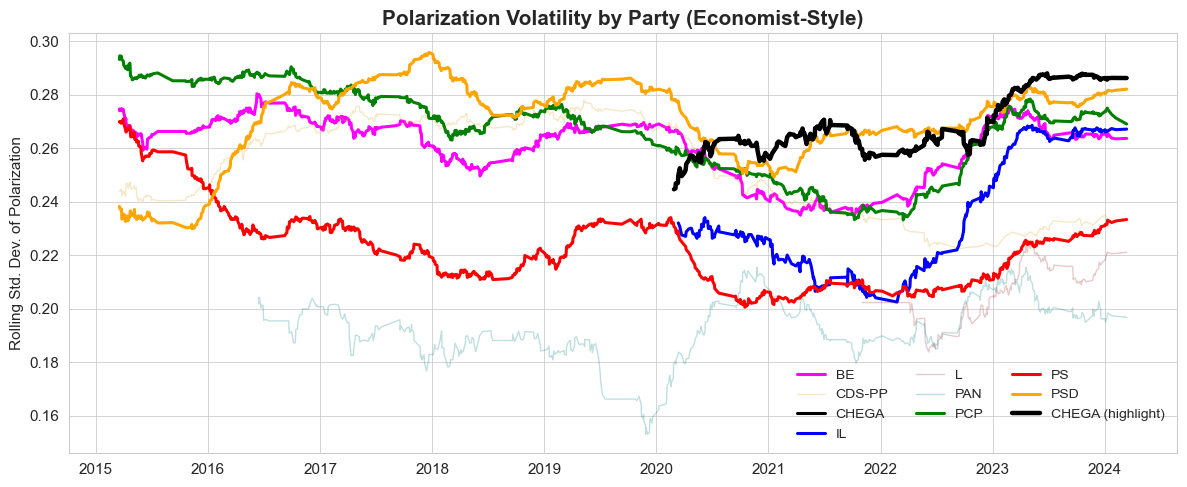

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- SETTINGS ---
ROLL = 90
major_parties = ["PS", "PSD", "CHEGA", "BE", "PCP", "IL"]  # Fokus auf die wichtigen
sns.set_style("whitegrid")

# --- CALCULATE VOLATILITY ---
vol = (
    d0.groupby(["party", "date"])[POL_COL]
      .std()
      .reset_index(name="std_dev")
)

vol = vol.sort_values(["party","date"])
vol[f"roll{ROLL}"] = (
    vol.groupby("party")["std_dev"]
       .transform(lambda s: s.rolling(ROLL, min_periods=30).mean())
)

# --- PLOTTING ---
plt.figure(figsize=(12,5))

for party, sub in vol.groupby("party"):
    if party in major_parties:
        lw = 2.2
        alpha = 1.0
    else:
        lw = 1.0
        alpha = 0.25
    
    plt.plot(sub["date"], sub[f"roll{ROLL}"],
             label=party,
             color=color_for(party),
             linewidth=lw,
             alpha=alpha)

# --- HIGHLIGHT CHEGA ---
chega = vol[vol["party"]=="CHEGA"]
plt.plot(
    chega["date"], chega[f"roll{ROLL}"],
    color="black", linewidth=3.2, label="CHEGA (highlight)"
)

# --- TITLES AND STYLE ---
plt.title("Polarization Volatility by Party (Economist-Style)", fontsize=15, weight="bold")
plt.ylabel("Rolling Std. Dev. of Polarization")
plt.xlabel("")
plt.legend(ncol=3, fontsize=10, frameon=False)
plt.tight_layout()

plt.savefig(SAVE_DIR/"volatility_economist_style.png", dpi=300)
plt.show()



In [83]:
d0["addressed_to"].astype(str).str.upper().str.strip().value_counts().head(40)


addressed_to
NAN                      134843
DEPUTADOS                 53265
PRESIDENTE                50654
MINISTRO/MINISTRA          3136
SECRETÁRIO/SECRETÁRIA      1525
DEPUTADO/DEPUTADA            66
Name: count, dtype: int64

In [5]:
import pandas as pd

df = pd.read_csv("all_with_ensemble.csv")

if "p_pol_ensemble" not in df.columns:
    raise ValueError("Column 'p_pol_ensemble' not found. Did the ensemble script run correctly?")

# --- Choose a threshold ---
# If you know your tuned threshold from the labelled experiment, put it here:
THR = 0.5  # TODO: replace with your best threshold if you have one

# Create binary labels from ensemble probabilities
df["ensemble_label_tmp"] = (df["p_pol_ensemble"] >= THR).astype(int)

# Count + proportions
pred_counts = df["ensemble_label_tmp"].value_counts().sort_index()
pred_props  = pred_counts / pred_counts.sum()

print(f"Using threshold THR = {THR}")
print("\nCounts (0 = non-polarized, 1 = polarized):")
print(pred_counts.rename(index={0: "non-polarized (0)", 1: "polarized (1)"}))

print("\nProportions:")
print(pred_props.rename(index={0: "non-polarized (0)", 1: "polarized (1)"}))


Using threshold THR = 0.5

Counts (0 = non-polarized, 1 = polarized):
ensemble_label_tmp
non-polarized (0)    177513
polarized (1)         71064
Name: count, dtype: int64

Proportions:
ensemble_label_tmp
non-polarized (0)    0.714117
polarized (1)        0.285883
Name: count, dtype: float64


In [6]:
import pandas as pd

df = pd.read_csv("all_with_ensemble.csv")
print(df.columns.tolist())


['speech_id', 'date', 'intervention_id', 'speaker_id', 'speaker_name', 'party', 'role', 'text', 'text_length', 'topic', 'addressed_to', 'u_num', 'speech_doc', 'gpt5nano_p_pol', 'xlmr_p_pol', 'p_pol_ensemble']


In [2]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# ===== CONFIG =====
OUT_DIR   = r"C:\Users\Nomis\Desktop\splits_balanced_train_70_15_15"
TEST_CSV  = os.path.join(OUT_DIR, "test.csv")

TEXT_COL  = "text"
LABEL_COL = "intervention_polarized_label"   # 0/1

MODEL_NAME = "xlm-roberta-base"
MAX_LEN    = 256

# ===== LOAD TEST DATA =====
df_test = pd.read_csv(TEST_CSV)
print("Columns:", list(df_test.columns))
print("n_test :", len(df_test))

texts  = df_test[TEXT_COL].astype(str).tolist()
labels = df_test[LABEL_COL].astype(int).tolist()

# ===== LOAD BASELINE XLM-R (NO FINE-TUNING) =====
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# ===== TOKENIZE & RUN =====
encodings = tokenizer(
    texts,
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

input_ids      = encodings["input_ids"].to(device)
attention_mask = encodings["attention_mask"].to(device)

with torch.no_grad():
    logits = model(input_ids=input_ids, attention_mask=attention_mask).logits

preds = torch.argmax(logits, dim=-1).cpu().numpy()

# ===== METRICS =====
acc = accuracy_score(labels, preds)
f1  = f1_score(labels, preds, average="macro")
cm  = confusion_matrix(labels, preds)

print("\n=== XLM-R BASELINE (no fine-tuning) on TEST ===")
print(f"Accuracy : {acc:.4f}")
print(f"Macro F1 : {f1:.4f}")

print("\nConfusion matrix [rows=true, cols=pred]:")
print(cm)

print("\nClassification report:")
print(classification_report(labels, preds, digits=4))


Columns: ['speech_id', 'intervention_id', 'party', 'speaker_name', 'text', 'text_length', 'intervention_polarized_label', 'intervention_label']
n_test : 225


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== XLM-R BASELINE (no fine-tuning) on TEST ===
Accuracy : 0.4000
Macro F1 : 0.2857

Confusion matrix [rows=true, cols=pred]:
[[  0 135]
 [  0  90]]

Classification report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       135
           1     0.4000    1.0000    0.5714        90

    accuracy                         0.4000       225
   macro avg     0.2000    0.5000    0.2857       225
weighted avg     0.1600    0.4000    0.2286       225



C:\Users\Nomis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Nomis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Nomis\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Top parties used in daily chart: ['PS', 'PSD', 'PCP', 'BE', 'CDS-PP', 'CH', 'IL', 'PAN', 'L']
Saved daily trend plot → figures\party_trends_daily_top10.png


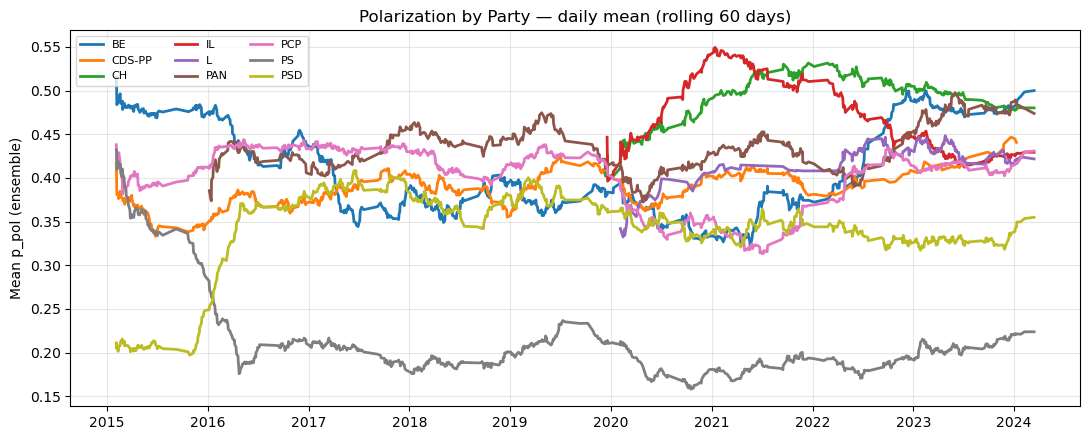

In [6]:
# ---------- Daily smoothed polarization for top parties ----------

# 1. Copy & clean
d = df.copy()

exclude = {"Independente", "Presidency", "Government", "PEV", "nan", "None", "NaT", ""}
d["party"] = d["party"].astype(str).str.strip()
d = d[~d["party"].isin(exclude)]
d = d[~d["party"].str.lower().isin(["nan", "none", "nat"])]

# 2. Pick top N parties by number of interventions (you can hardcode your own list if you prefer)
TOP_N = 10
top_parties = (
    d["party"]
    .value_counts()
    .head(TOP_N)
    .index
    .tolist()
)
print("Top parties used in daily chart:", top_parties)

d = d[d["party"].isin(top_parties)]

# 3. Daily mean
d["day"] = d["date"].dt.floor("D")
agg_day = (
    d.groupby(["party", "day"])["p_pol_ensemble"]
      .mean()
      .reset_index()
)

# 4. Rolling smoothing (e.g. 60-day window)
WINDOW_DAYS = 60
agg_day["p_pol_smooth"] = agg_day.groupby("party")["p_pol_ensemble"].transform(
    lambda s: s.rolling(WINDOW_DAYS, min_periods=max(7, WINDOW_DAYS // 5)).mean()
)

# 5. Plot
plt.figure(figsize=(11, 4.5))
for party, sub in agg_day.groupby("party"):
    plt.plot(sub["day"], sub["p_pol_smooth"], label=party, linewidth=2)

plt.legend(ncol=3, fontsize=8)
plt.ylabel("Mean p_pol (ensemble)")
plt.title(f"Polarization by Party — daily mean (rolling {WINDOW_DAYS} days)")
plt.grid(alpha=0.3)
plt.tight_layout()

out_path = SAVE_DIR / f"party_trends_daily_top{TOP_N}.png"
plt.savefig(out_path, dpi=180)
print("Saved daily trend plot →", out_path)

plt.show()


  Gender Speaker_gender  share_pct
0    Men              M  69.592884
1  Women              F  30.407116
Total: 100.0


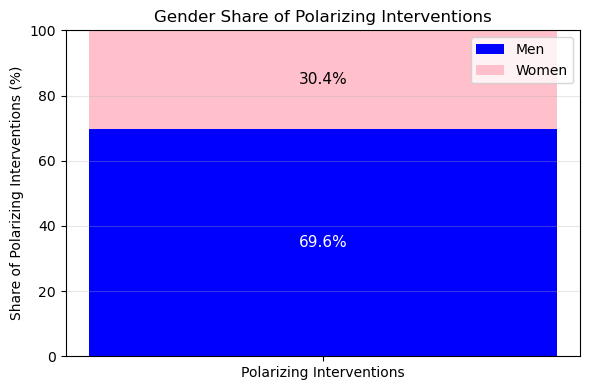

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 0) Assumptions
# ---------------------------------------------------
# - df         : your scored dataframe (one row per intervention)
#                columns: ["speech_id", "date", "p_pol_ensemble", ...]
# - full_df    : metadata from the loader
#                columns: ["utt_id", "Speaker_gender", ...]
# If they’re not in memory, load them here instead.

# ---------------------------------------------------
# 1) Merge scores with gender
# ---------------------------------------------------
merged = df.merge(
    full_df[["utt_id", "Speaker_gender"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left"
)

# Keep only M/F
merged = merged[merged["Speaker_gender"].isin(["M", "F"])].copy()

# ---------------------------------------------------
# 2) Mark polarizing interventions
# ---------------------------------------------------
THRESH = 0.5  # your cutoff for "polarizing"
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

# ---------------------------------------------------
# 3) Among polarizing interventions, compute gender shares
# ---------------------------------------------------
polar = merged[merged["is_polarizing"]].copy()

shares = (
    polar["Speaker_gender"]
    .value_counts(normalize=True)  # proportions
    .mul(100)                      # to %
    .rename_axis("Speaker_gender")
    .reset_index(name="share_pct")
)

label_map = {"M": "Men", "F": "Women"}
shares["Gender"] = shares["Speaker_gender"].map(label_map)

# Ensure consistent order Men, Women
shares = shares.set_index("Gender").reindex(["Men", "Women"]).reset_index()

print(shares)
#   Gender Speaker_gender  share_pct
# 0   Men              M   ...
# 1 Women              F   ...

men_pct    = shares.loc[shares["Gender"] == "Men", "share_pct"].iloc[0]
women_pct  = shares.loc[shares["Gender"] == "Women", "share_pct"].iloc[0]

# Sanity check: should be ~100
print("Total:", men_pct + women_pct)

# ---------------------------------------------------
# 4) Plot 100% stacked bar
# ---------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

x_label = ["Polarizing Interventions"]

# Men segment (bottom)
ax.bar(x_label, [men_pct], label="Men", color="blue")

# Women segment stacked on top
ax.bar(x_label, [women_pct], bottom=[men_pct], label="Women", color="pink")

# Percentage labels inside the bar
ax.text(
    0, men_pct / 2,
    f"{men_pct:.1f}%",
    ha="center", va="center", color="white", fontsize=11
)
ax.text(
    0, men_pct + women_pct / 2,
    f"{women_pct:.1f}%",
    ha="center", va="center", color="black", fontsize=11
)

ax.set_ylim(0, 100)
ax.set_ylabel("Share of Polarizing Interventions (%)")
ax.set_title("Gender Share of Polarizing Interventions")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("figures/polarizing_gender_share_100stack.png", dpi=180)
plt.show()


Raw within-gender percentages:
  Gender Speaker_gender  polarizing_pct
0    Men              M       26.594974
1  Women              F       34.410856

Normalized (sums to 100%):
  Gender  relative_pct
0    Men     43.594152
1  Women     56.405848


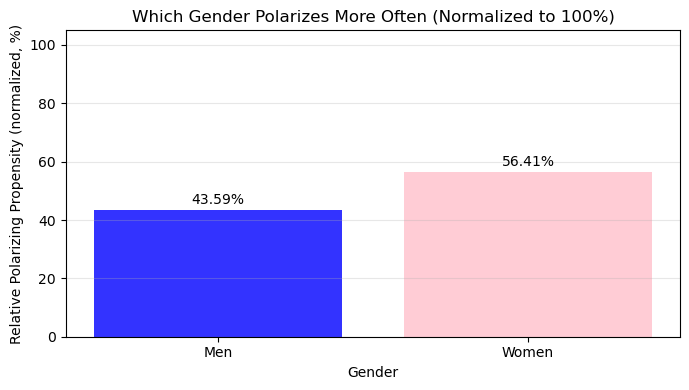

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------
# 0) Assumptions: df and full_df already exist
#    - df: has columns ["speech_id", "date", "p_pol_ensemble", ...]
#    - full_df: has columns ["utt_id", "Speaker_gender", ...]
# ---------------------------------------------------

# 1) Merge scores with gender
merged = df.merge(
    full_df[["utt_id", "Speaker_gender"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left"
)

# Keep only M/F
merged = merged[merged["Speaker_gender"].isin(["M", "F"])].copy()

# 2) Flag polarizing interventions
THRESH = 0.5   # your chosen cutoff
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

# 3) Within-gender polarizing rates: P(polarizing | gender)
freq = (
    merged.groupby("Speaker_gender")["is_polarizing"]
          .mean()
          .mul(100)                # to %
          .reset_index(name="polarizing_pct")
)

label_map = {"M": "Men", "F": "Women"}
freq["Gender"] = freq["Speaker_gender"].map(label_map)

# Optional: sort Men, Women
freq = freq.set_index("Gender").reindex(["Men", "Women"]).reset_index()

print("Raw within-gender percentages:")
print(freq)

# 4) Normalize those two percentages so they sum to 100
total = freq["polarizing_pct"].sum()
freq["relative_pct"] = freq["polarizing_pct"] / total * 100

print("\nNormalized (sums to 100%):")
print(freq[["Gender", "relative_pct"]])

# 5) Plot normalized percentages
plt.figure(figsize=(7, 4))
colors = ["blue", "pink"]  # Men, Women
bars = plt.bar(freq["Gender"], freq["relative_pct"], color=colors, alpha=0.8)

# Labels on top
for bar, val in zip(bars, freq["relative_pct"]):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        f"{val:.2f}%",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.ylabel("Relative Polarizing Propensity (normalized, %)")
plt.xlabel("Gender")
plt.title("Which Gender Polarizes More Often (Normalized to 100%)")
plt.ylim(0, 105)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig("figures/polarizing_by_gender_normalized_100.png", dpi=180)
plt.show()


                    Topic  total_speeches  polar_pct  non_polar_pct
16         Macroeconomics           20261  58.881595      41.118405
14                  Labor            8309  55.963413      44.036587
4       Domestic Commerce            4388  52.643573      47.356427
11                Housing            3777  51.231136      48.768864
20         Social Welfare            4838  50.702770      49.297230
12            Immigration            1587  49.968494      50.031506
5               Education            7452  49.570585      50.429415
9   Government Operations            8746  49.165333      50.834667
10                 Health           11633  47.838047      52.161953
22         Transportation            4371  47.014413      52.985587
1            Civil Rights            4522  44.869527      55.130473
8           Foreign Trade             348  44.827586      55.172414
15          Law and Crime            5269  44.391725      55.608275
17                    Mix           11924  43.82

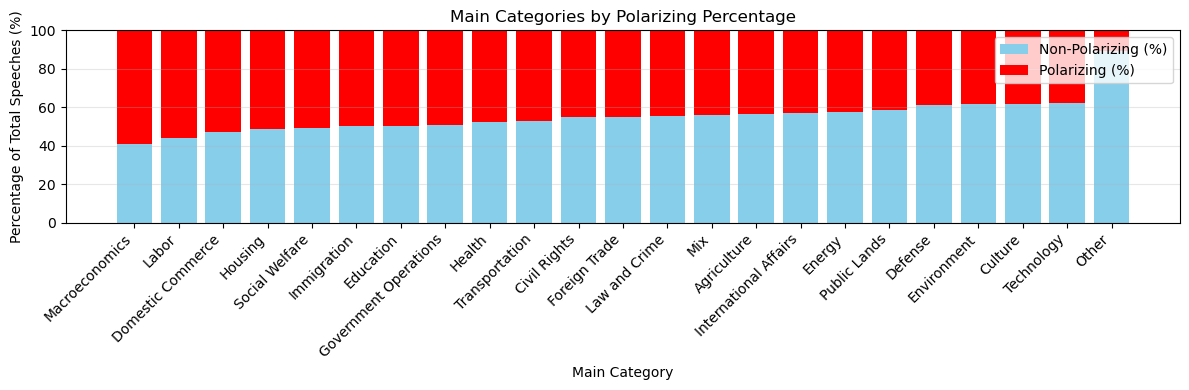

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ---------------------------------------------------
# 0) Config
# ---------------------------------------------------
THRESH = 0.5                    # cutoff for "polarizing"
MIN_SPEECHES = 0                # optional: min speeches per topic to keep
SAVE_DIR = Path("figures")
SAVE_DIR.mkdir(exist_ok=True)

# ---------------------------------------------------
# 1) Merge scores with main topic
# ---------------------------------------------------
merged = df.merge(
    full_df[["utt_id", "Topic"]],
    left_on="speech_id",
    right_on="utt_id",
    how="left"
)

# Drop rows without a topic
merged = merged.dropna(subset=["Topic"]).copy()

# Flag polarizing interventions
merged["is_polarizing"] = merged["p_pol_ensemble"] >= THRESH

# ---------------------------------------------------
# 2) Aggregate by topic: polarizing & non-polarizing %
# ---------------------------------------------------
agg = (
    merged.groupby("Topic")
          .agg(
              total_speeches=("is_polarizing", "size"),
              polar_speeches=("is_polarizing", "sum"),
          )
          .reset_index()
)

# Optional: keep only topics with enough speeches
agg = agg[agg["total_speeches"] >= MIN_SPEECHES].copy()

agg["polar_pct"] = agg["polar_speeches"] / agg["total_speeches"] * 100
agg["non_polar_pct"] = 100 - agg["polar_pct"]

# Sort topics by polarizing percentage (descending) so red bars go from high to low
agg = agg.sort_values("polar_pct", ascending=False)

print(agg[["Topic", "total_speeches", "polar_pct", "non_polar_pct"]])

# ---------------------------------------------------
# 3) Plot 100% stacked bar chart
# ---------------------------------------------------
x = np.arange(len(agg))

fig, ax = plt.subplots(figsize=(12, 4))

# Bottom: non-polarizing %
ax.bar(
    x,
    agg["non_polar_pct"],
    color="skyblue",
    label="Non-Polarizing (%)"
)

# Top: polarizing %
ax.bar(
    x,
    agg["polar_pct"],
    bottom=agg["non_polar_pct"],
    color="red",
    label="Polarizing (%)"
)

ax.set_xticks(x)
ax.set_xticklabels(agg["Topic"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage of Total Speeches (%)")
ax.set_xlabel("Main Category")
ax.set_title("Main Categories by Polarizing Percentage")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out_path = SAVE_DIR / "main_categories_polarizing_100stack.png"
plt.savefig(out_path, dpi=180)
print("Saved plot →", out_path)

plt.show()


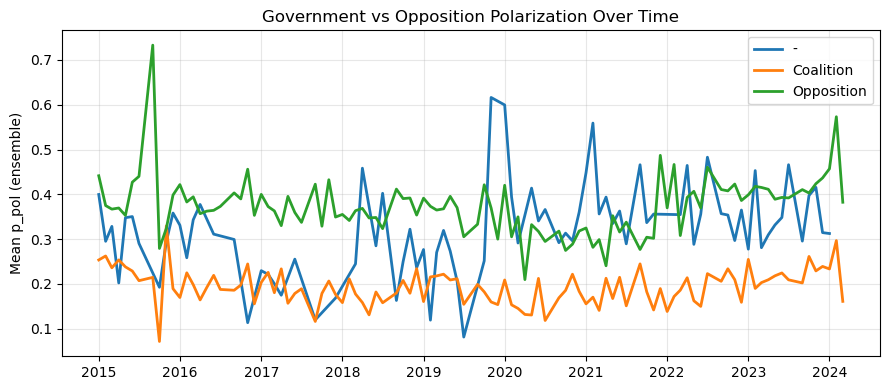

In [14]:
m = df.merge(full_df[["utt_id", "Party_status"]],
             left_on="speech_id", right_on="utt_id", how="left")

m["month"] = m["date"].dt.to_period("M").dt.to_timestamp()
cur = (
    m.dropna(subset=["Party_status"])
     .groupby(["Party_status", "month"])["p_pol_ensemble"]
     .mean().reset_index()
)

import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
for status, sub in cur.groupby("Party_status"):
    plt.plot(sub["month"], sub["p_pol_ensemble"], label=status, lw=2)

plt.ylabel("Mean p_pol (ensemble)")
plt.title("Government vs Opposition Polarization Over Time")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figures/gov_vs_opp.png", dpi=180)
plt.show()


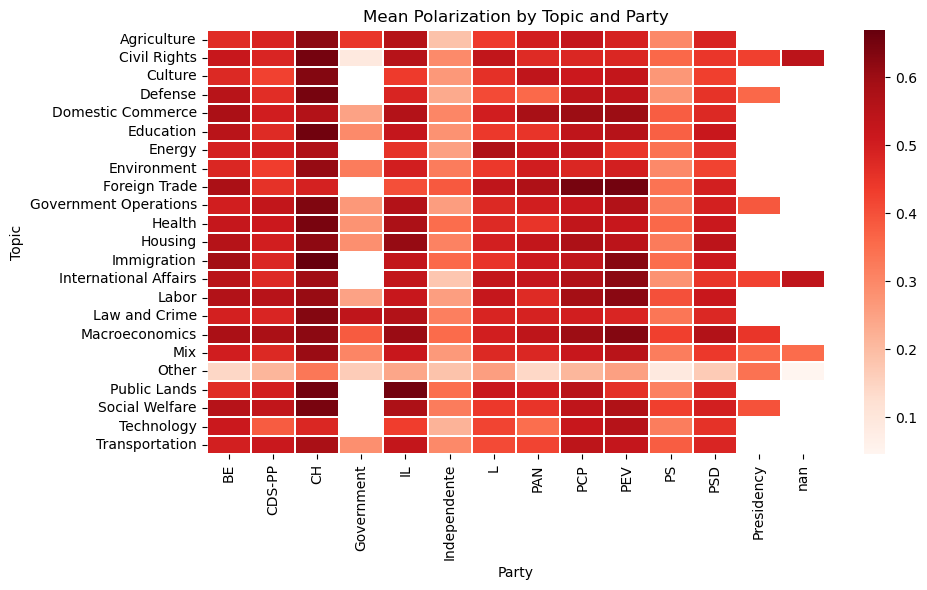

In [15]:
m = df.merge(full_df[["utt_id", "Topic"]],
             left_on="speech_id", right_on="utt_id", how="left")
m = m.dropna(subset=["Topic", "party"])

pivot = (
    m.groupby(["Topic", "party"])["p_pol_ensemble"]
     .mean()
     .unstack("party")
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(pivot, cmap="Reds", linewidths=0.3)
plt.title("Mean Polarization by Topic and Party")
plt.xlabel("Party")
plt.ylabel("Topic")
plt.tight_layout()
plt.savefig("figures/topic_party_heatmap.png", dpi=180)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_8680\884069878.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub["label"] = sub["Speaker_name"].str.split(",").str[0]  # shorter


<Figure size 1000x500 with 0 Axes>

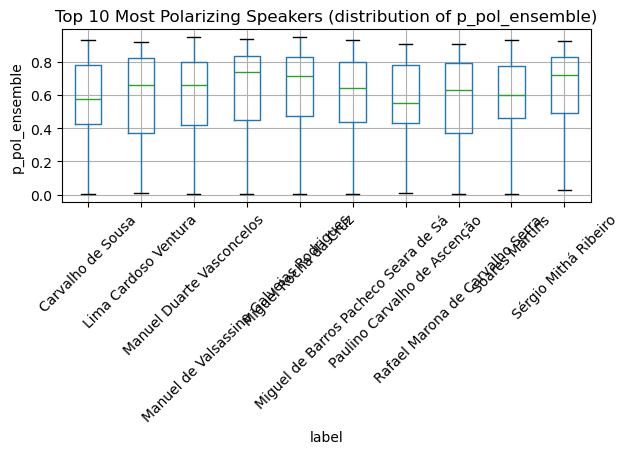

In [16]:
m = df.merge(full_df[["utt_id", "Speaker_ID", "Speaker_name"]],
             left_on="speech_id", right_on="utt_id", how="left")

speaker_stats = (
    m.groupby(["Speaker_ID", "Speaker_name"])["p_pol_ensemble"]
     .agg(["mean", "count"])
     .reset_index()
)

top = speaker_stats[speaker_stats["count"] >= 50].nlargest(10, "mean")  # require min speeches
top_ids = top["Speaker_ID"].tolist()

sub = m[m["Speaker_ID"].isin(top_ids)]

plt.figure(figsize=(10,5))
sub["label"] = sub["Speaker_name"].str.split(",").str[0]  # shorter
sub.boxplot(column="p_pol_ensemble", by="label", rot=45)
plt.suptitle("")
plt.title("Top 10 Most Polarizing Speakers (distribution of p_pol_ensemble)")
plt.ylabel("p_pol_ensemble")
plt.tight_layout()
plt.savefig("figures/top_speakers_boxplot.png", dpi=180)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_8680\3686154714.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["age_group", "Term"])["p_pol_ensemble"]


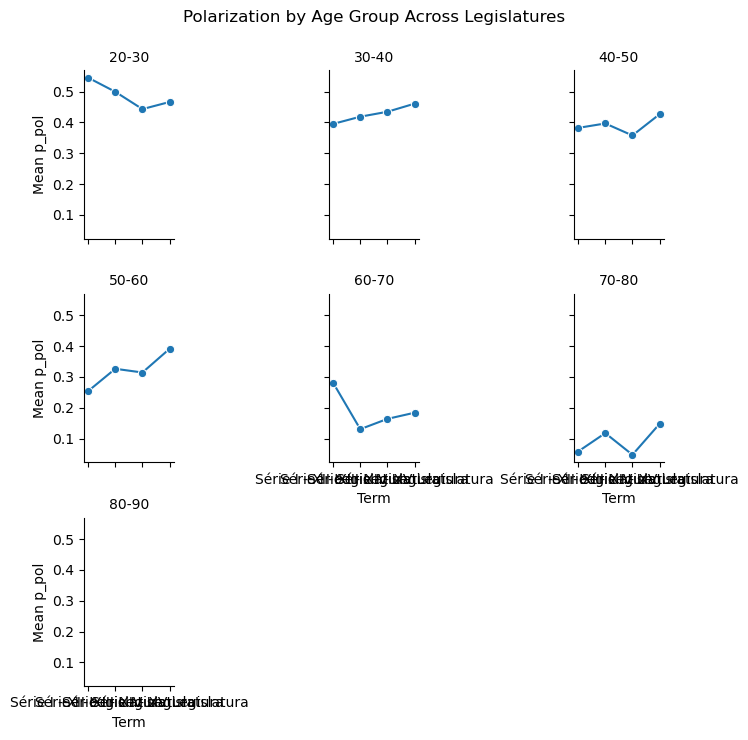

In [17]:
m = df.merge(full_df[["utt_id", "Speaker_birth", "Term"]],
             left_on="speech_id", right_on="utt_id", how="left")

m["Speaker_birth"] = pd.to_numeric(m["Speaker_birth"], errors="coerce")
m = m.dropna(subset=["Speaker_birth"])

m["age"] = m["date"].dt.year - m["Speaker_birth"]
bins = [20,30,40,50,60,70,80,90]
labels = ["20-30","30-40","40-50","50-60","60-70","70-80","80-90"]
m["age_group"] = pd.cut(m["age"], bins=bins, labels=labels, right=False)

agg = (
    m.dropna(subset=["age_group", "Term"])
     .groupby(["age_group", "Term"])["p_pol_ensemble"]
     .mean()
     .reset_index()
)

import seaborn as sns
g = sns.FacetGrid(agg, col="age_group", col_wrap=3, height=2.5, sharey=True)
g.map(sns.lineplot, "Term", "p_pol_ensemble", marker="o")
g.set_titles("{col_name}")
g.set_axis_labels("Term", "Mean p_pol")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Polarization by Age Group Across Legislatures")
plt.savefig("figures/age_term_facets.png", dpi=180)
plt.show()


Saved → figures\party_share_polarized_100stack.png


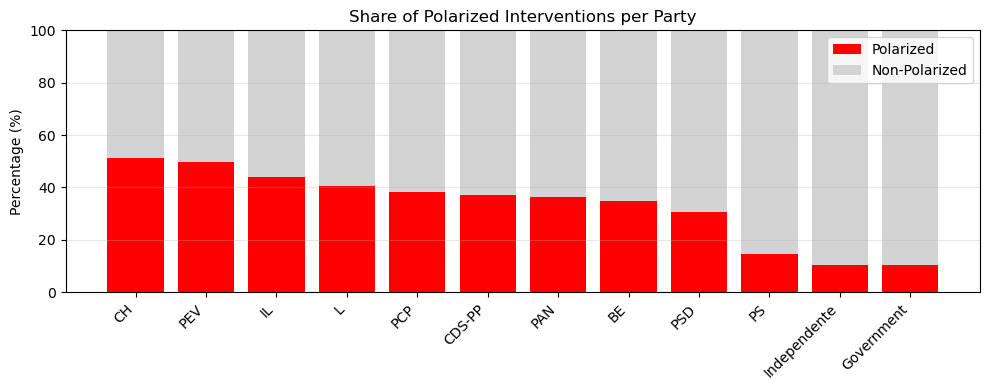

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

THRESH = 0.5
SAVE_DIR = Path("figures"); SAVE_DIR.mkdir(exist_ok=True)

# merge minimal info
merged_party = df.merge(
    full_df[["utt_id", "Party_status"]],  # Party_status not used but could be
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_party = merged_party.dropna(subset=["party"]).copy()
merged_party["is_polarizing"] = merged_party["p_pol_ensemble"] >= THRESH

agg_p = (
    merged_party.groupby("party")
        .agg(
            total=("is_polarizing", "size"),
            polar=("is_polarizing", "sum"),
        )
        .reset_index()
)

# optional: drop micro-parties
agg_p = agg_p[agg_p["total"] >= 100].copy()

agg_p["polar_pct"] = agg_p["polar"] / agg_p["total"] * 100
agg_p["non_polar_pct"] = 100 - agg_p["polar_pct"]
agg_p = agg_p.sort_values("polar_pct", ascending=False)

x = np.arange(len(agg_p))
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(x, agg_p["polar_pct"], color="red", label="Polarized")
ax.bar(x, agg_p["non_polar_pct"], bottom=agg_p["polar_pct"],
       color="lightgrey", label="Non-Polarized")

ax.set_xticks(x)
ax.set_xticklabels(agg_p["party"], rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)")
ax.set_title("Share of Polarized Interventions per Party")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "party_share_polarized_100stack.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\status_share_polarized_100stack.png


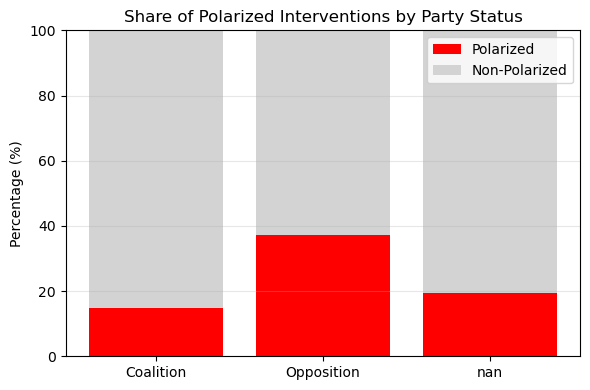

In [21]:
merged_status = df.merge(
    full_df[["utt_id", "Party_status"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_status = merged_status.dropna(subset=["Party_status"]).copy()
merged_status["is_polarizing"] = merged_status["p_pol_ensemble"] >= THRESH

agg_s = (
    merged_status.groupby("Party_status")
        .agg(
            total=("is_polarizing", "size"),
            polar=("is_polarizing", "sum")
        ).reset_index()
)

agg_s["polar_pct"] = agg_s["polar"] / agg_s["total"] * 100
agg_s["non_polar_pct"] = 100 - agg_s["polar_pct"]

# consistent order
order = ["Government", "Coalition", "Opposition"]
agg_s["Party_status"] = pd.Categorical(agg_s["Party_status"], order, ordered=True)
agg_s = agg_s.sort_values("Party_status")

x = np.arange(len(agg_s))
fig, ax = plt.subplots(figsize=(6, 4))

ax.bar(x, agg_s["polar_pct"], color="red", label="Polarized")
ax.bar(x, agg_s["non_polar_pct"], bottom=agg_s["polar_pct"],
       color="lightgrey", label="Non-Polarized")

ax.set_xticks(x)
ax.set_xticklabels(agg_s["Party_status"])
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)")
ax.set_title("Share of Polarized Interventions by Party Status")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "status_share_polarized_100stack.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_8680\807100060.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_age.groupby("age_group")


Saved → figures\agegroup_share_polarized_100stack.png


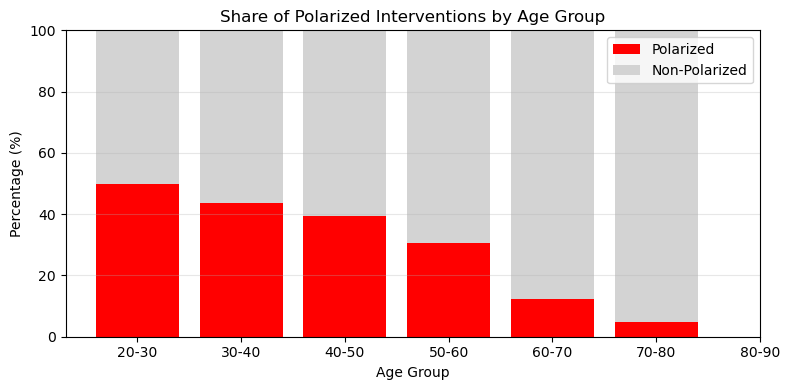

In [22]:
merged_age = df.merge(
    full_df[["utt_id", "Speaker_birth"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_age["Speaker_birth"] = pd.to_numeric(merged_age["Speaker_birth"], errors="coerce")
merged_age = merged_age.dropna(subset=["Speaker_birth"]).copy()
merged_age["age"] = merged_age["date"].dt.year - merged_age["Speaker_birth"]
merged_age = merged_age[(merged_age["age"] >= 20) & (merged_age["age"] <= 90)]

bins   = [20, 30, 40, 50, 60, 70, 80, 90]
labels = ["20-30","30-40","40-50","50-60","60-70","70-80","80-90"]
merged_age["age_group"] = pd.cut(merged_age["age"], bins=bins, labels=labels, right=False)

merged_age["is_polarizing"] = merged_age["p_pol_ensemble"] >= THRESH

agg_a = (
    merged_age.groupby("age_group")
        .agg(
            total=("is_polarizing","size"),
            polar=("is_polarizing","sum"),
        ).reset_index()
)

agg_a["polar_pct"] = agg_a["polar"] / agg_a["total"] * 100
agg_a["non_polar_pct"] = 100 - agg_a["polar_pct"]

x = np.arange(len(agg_a))
fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(x, agg_a["polar_pct"], color="red", label="Polarized")
ax.bar(x, agg_a["non_polar_pct"], bottom=agg_a["polar_pct"],
       color="lightgrey", label="Non-Polarized")

ax.set_xticks(x)
ax.set_xticklabels(agg_a["age_group"])
ax.set_ylim(0, 100)
ax.set_ylabel("Percentage (%)")
ax.set_xlabel("Age Group")
ax.set_title("Share of Polarized Interventions by Age Group")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "agegroup_share_polarized_100stack.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\gender_share_polarized_by_topic_100stack.png


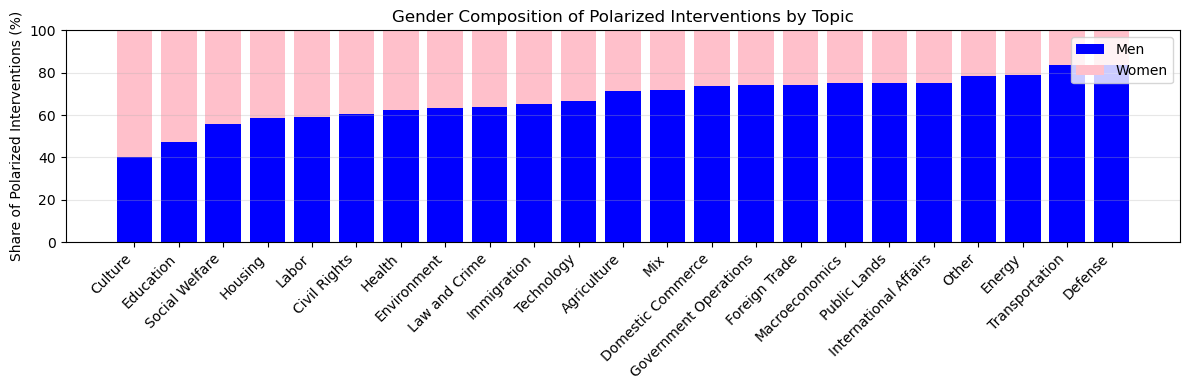

In [24]:
merged_gt = df.merge(
    full_df[["utt_id", "Topic", "Speaker_gender"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_gt = merged_gt[merged_gt["Speaker_gender"].isin(["M","F"])].copy()
merged_gt = merged_gt.dropna(subset=["Topic"])
merged_gt["is_polarizing"] = merged_gt["p_pol_ensemble"] >= THRESH

polar = merged_gt[merged_gt["is_polarizing"]].copy()

shares_gt = (
    polar.groupby(["Topic","Speaker_gender"])["is_polarizing"]
          .size().reset_index(name="count")
)

# convert to percentages within each topic
shares_gt["pct"] = (
    shares_gt.groupby("Topic")["count"]
             .transform(lambda x: x / x.sum() * 100)
)

# pivot to Men/Women columns
shares_pivot = shares_gt.pivot(index="Topic", columns="Speaker_gender", values="pct").fillna(0)
shares_pivot.rename(columns={"M":"Men","F":"Women"}, inplace=True)

# optional: keep topics with enough polarizing interventions
counts_p = polar.groupby("Topic")["is_polarizing"].size()
shares_pivot = shares_pivot.loc[counts_p[counts_p >= 100].index]

shares_pivot = shares_pivot.sort_values("Women", ascending=False)

x = np.arange(len(shares_pivot))
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(x, shares_pivot["Men"], color="blue", label="Men")
ax.bar(x, shares_pivot["Women"], bottom=shares_pivot["Men"],
       color="pink", label="Women")

ax.set_xticks(x)
ax.set_xticklabels(shares_pivot.index, rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("Share of Polarized Interventions (%)")
ax.set_title("Gender Composition of Polarized Interventions by Topic")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "gender_share_polarized_by_topic_100stack.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


In [26]:
merged_status = df.merge(
    full_df[["utt_id", "Party_status"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

# Clean + drop missing/unknown statuses
merged_status["Party_status"] = (
    merged_status["Party_status"]
    .astype(str)
    .str.strip()
)

merged_status = merged_status[
    ~merged_status["Party_status"].isin(["nan", "NaN", "None", "", "NA"])
].copy()

merged_status["is_polarizing"] = merged_status["p_pol_ensemble"] >= THRESH

agg_s = (
    merged_status.groupby("Party_status")
        .agg(
            total=("is_polarizing", "size"),
            polar=("is_polarizing", "sum")
        ).reset_index()
)

agg_s["polar_pct"] = agg_s["polar"] / agg_s["total"] * 100
agg_s["non_polar_pct"] = 100 - agg_s["polar_pct"]


Saved → figures\dist_p_pol_ensemble.png


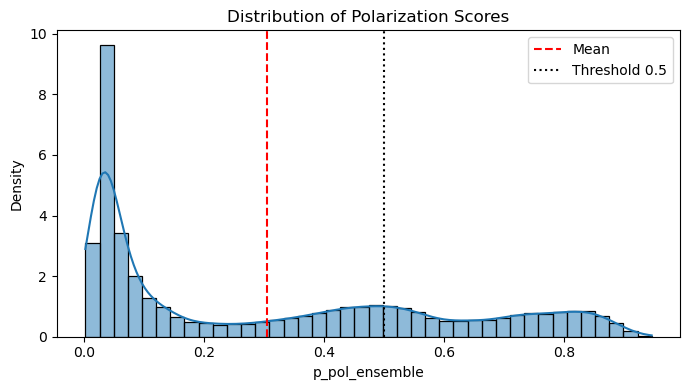

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,4))
sns.histplot(df["p_pol_ensemble"], bins=40, kde=True, stat="density")
plt.axvline(df["p_pol_ensemble"].mean(), color="red", linestyle="--", label="Mean")
plt.axvline(THRESH, color="black", linestyle=":", label=f"Threshold {THRESH}")
plt.xlabel("p_pol_ensemble")
plt.ylabel("Density")
plt.title("Distribution of Polarization Scores")
plt.legend()
plt.tight_layout()
out = SAVE_DIR / "dist_p_pol_ensemble.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\violin_polarization_by_party.png


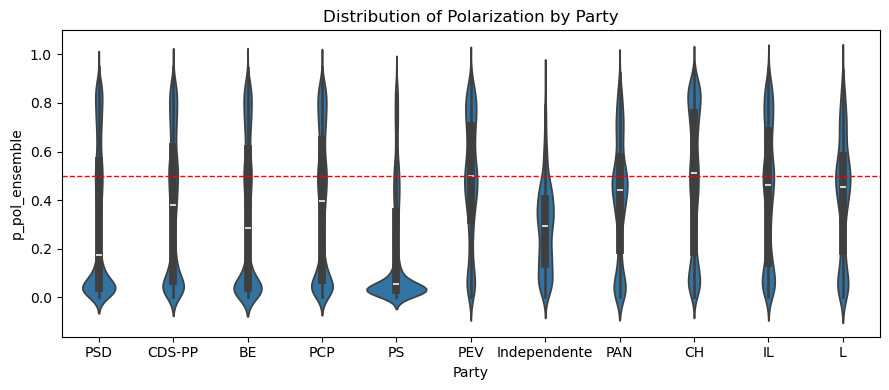

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# keep only main parties with enough interventions
party_counts = df["party"].value_counts()
main_parties = party_counts[party_counts >= 1000].index   # adjust threshold
sub = df[df["party"].isin(main_parties)].copy()

plt.figure(figsize=(9,4))
sns.violinplot(data=sub, x="party", y="p_pol_ensemble", inner="box")
plt.axhline(THRESH, color="red", linestyle="--", linewidth=1)
plt.xlabel("Party")
plt.ylabel("p_pol_ensemble")
plt.title("Distribution of Polarization by Party")
plt.tight_layout()
out = SAVE_DIR / "violin_polarization_by_party.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\monthly_share_polarizing.png


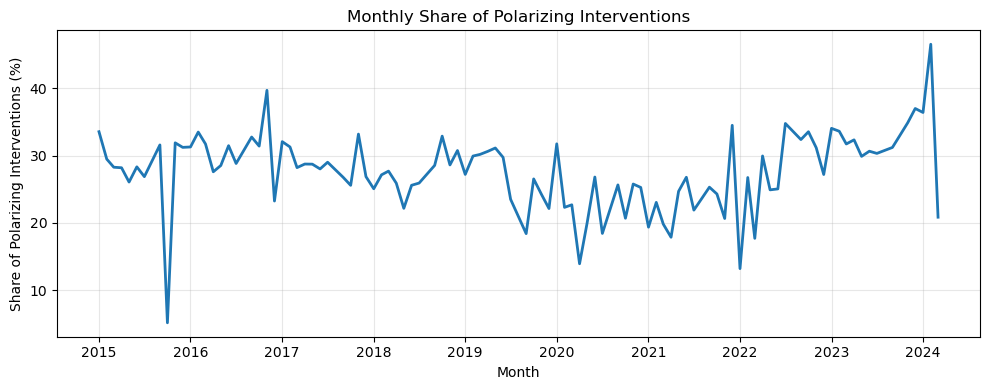

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

d = df.copy()
d["month"] = d["date"].dt.to_period("M").dt.to_timestamp()
d["is_polarizing"] = d["p_pol_ensemble"] >= THRESH

monthly = (
    d.groupby("month")["is_polarizing"]
     .mean()
     .mul(100)
     .reset_index(name="polarizing_pct")
)

plt.figure(figsize=(10,4))
plt.plot(monthly["month"], monthly["polarizing_pct"], linewidth=2)
plt.ylabel("Share of Polarizing Interventions (%)")
plt.xlabel("Month")
plt.title("Monthly Share of Polarizing Interventions")
plt.grid(alpha=0.3)
plt.tight_layout()
out = SAVE_DIR / "monthly_share_polarizing.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\heatmap_topic_party_polarization.png


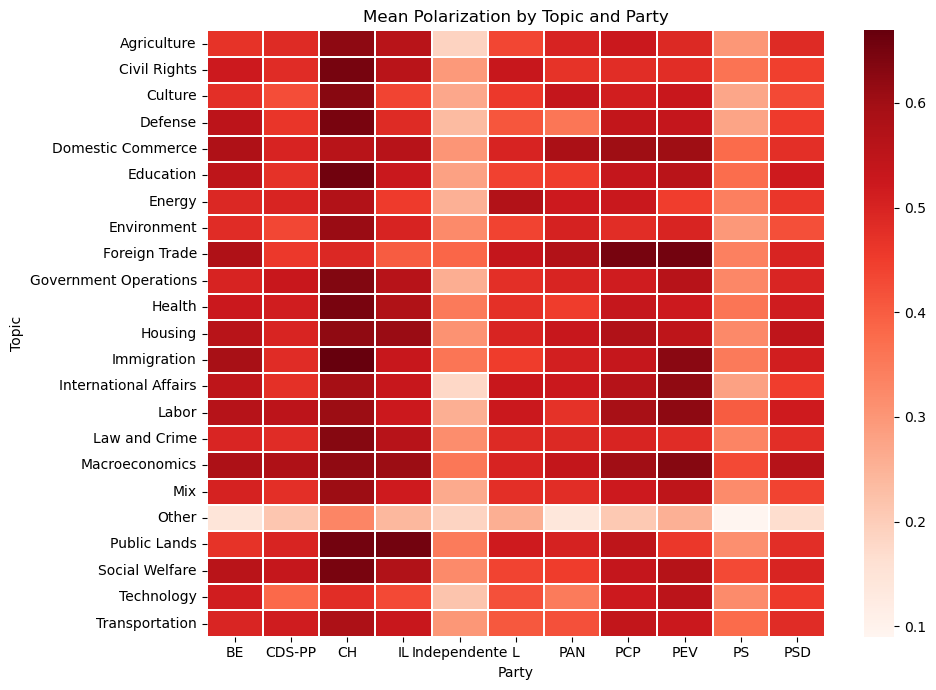

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

merged_tp = df.merge(
    full_df[["utt_id", "Topic"]],
    left_on="speech_id", right_on="utt_id", how="left"
)
merged_tp = merged_tp.dropna(subset=["Topic", "party"])

# optional: restrict to main parties
party_counts = merged_tp["party"].value_counts()
main_parties = party_counts[party_counts >= 1000].index
merged_tp = merged_tp[merged_tp["party"].isin(main_parties)]

pivot = (
    merged_tp.groupby(["Topic", "party"])["p_pol_ensemble"]
             .mean()
             .unstack("party")
)

plt.figure(figsize=(10,7))
sns.heatmap(pivot, cmap="Reds", linewidths=0.3, linecolor="white")
plt.title("Mean Polarization by Topic and Party")
plt.xlabel("Party")
plt.ylabel("Topic")
plt.tight_layout()
out = SAVE_DIR / "heatmap_topic_party_polarization.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


C:\Users\Nomis\AppData\Local\Temp\ipykernel_8680\9795301.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(


Saved → figures\scatter_age_gender_polarization.png


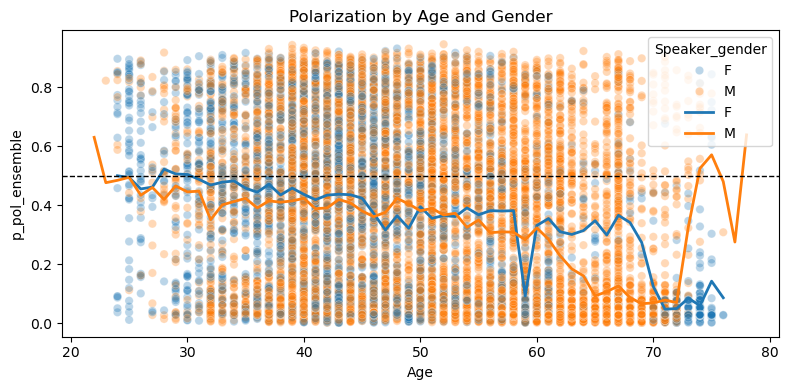

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

merged_age = df.merge(
    full_df[["utt_id", "Speaker_birth", "Speaker_gender"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_age["Speaker_birth"] = pd.to_numeric(merged_age["Speaker_birth"], errors="coerce")
merged_age = merged_age.dropna(subset=["Speaker_birth", "Speaker_gender"]).copy()
merged_age["age"] = merged_age["date"].dt.year - merged_age["Speaker_birth"]
merged_age = merged_age[(merged_age["age"] >= 20) & (merged_age["age"] <= 90)]

plt.figure(figsize=(8,4))
sns.scatterplot(
    data=merged_age.sample(min(15000, len(merged_age))),   # sample for speed
    x="age",
    y="p_pol_ensemble",
    hue="Speaker_gender",
    alpha=0.3
)
sns.lineplot(
    data=merged_age,
    x="age",
    y="p_pol_ensemble",
    hue="Speaker_gender",
    estimator="mean",
    ci=None,
    lw=2
)
plt.axhline(THRESH, color="black", linestyle="--", linewidth=1)
plt.xlabel("Age")
plt.ylabel("p_pol_ensemble")
plt.title("Polarization by Age and Gender")
plt.tight_layout()
out = SAVE_DIR / "scatter_age_gender_polarization.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\gender_polarizing_propensity_by_topic_normalized.png


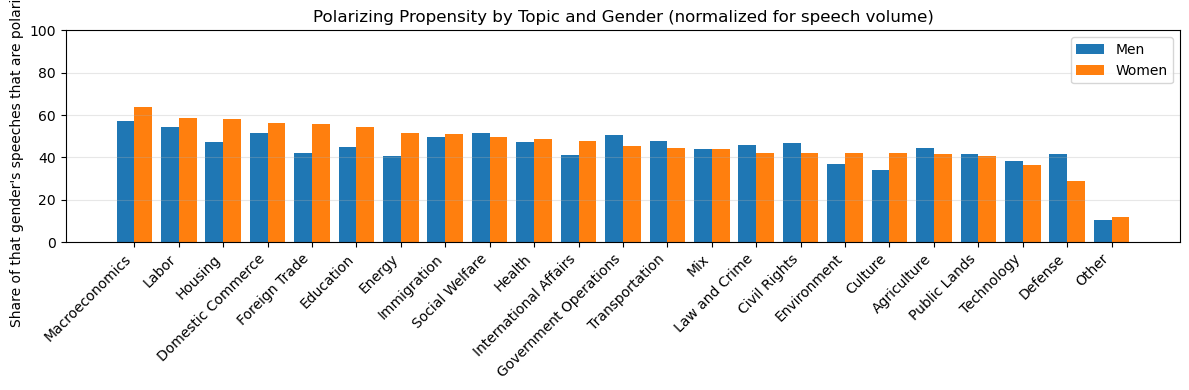

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- merge + filter as before ------------------------------------
merged_gt = df.merge(
    full_df[["utt_id", "Topic", "Speaker_gender"]],
    left_on="speech_id", right_on="utt_id", how="left"
)
THRESH = 0.5  # adjust if you use another cutoff

merged_gt = merged_gt[merged_gt["Speaker_gender"].isin(["M", "F"])].copy()
merged_gt = merged_gt.dropna(subset=["Topic"])
merged_gt["is_polarizing"] = merged_gt["p_pol_ensemble"] >= THRESH

# --- 1) totals per topic & gender (denominator) -------------------
totals = (
    merged_gt
    .groupby(["Topic", "Speaker_gender"])["is_polarizing"]
    .size()
    .rename("n_total")
)

# --- 2) polarising counts per topic & gender (numerator) ----------
polars = (
    merged_gt[merged_gt["is_polarizing"]]
    .groupby(["Topic", "Speaker_gender"])["is_polarizing"]
    .size()
    .rename("n_polar")
)

# --- 3) combine + compute within-gender polarising rate -----------
rates = (
    pd.concat([totals, polars], axis=1)
    .fillna(0)
    .reset_index()
)

rates["polarizing_pct"] = (rates["n_polar"] / rates["n_total"]) * 100

# optional: keep topics with enough total interventions (all genders)
topic_totals = rates.groupby("Topic")["n_total"].sum()
keep_topics = topic_totals[topic_totals >= 100].index
rates = rates[rates["Topic"].isin(keep_topics)]

# pivot to Men / Women columns
shares_pivot = (
    rates
    .pivot(index="Topic", columns="Speaker_gender", values="polarizing_pct")
    .fillna(0)
)
shares_pivot.rename(columns={"M": "Men", "F": "Women"}, inplace=True)

# sort by women's rate (or whatever you prefer)
shares_pivot = shares_pivot.sort_values("Women", ascending=False)

# --- 4) plot grouped bars (not stacked) ---------------------------
x = np.arange(len(shares_pivot))
width = 0.4

fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(x - width/2, shares_pivot["Men"],   width=width, label="Men")
ax.bar(x + width/2, shares_pivot["Women"], width=width, label="Women")

ax.set_xticks(x)
ax.set_xticklabels(shares_pivot.index, rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("Share of that gender's speeches that are polarized (%)")
ax.set_title("Polarizing Propensity by Topic and Gender (normalized for speech volume)")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "gender_polarizing_propensity_by_topic_normalized.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()


Saved → figures\gender_propensity_polarized_by_topic_normalized_100.png


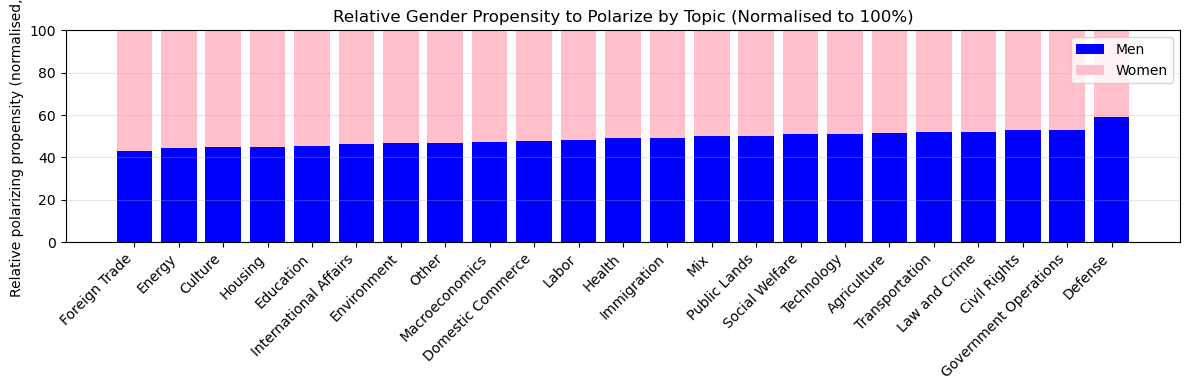

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- merge + basic filtering as before ---
merged_gt = df.merge(
    full_df[["utt_id", "Topic", "Speaker_gender"]],
    left_on="speech_id", right_on="utt_id", how="left"
)

merged_gt = merged_gt[merged_gt["Speaker_gender"].isin(["M", "F"])].copy()
merged_gt = merged_gt.dropna(subset=["Topic"])
merged_gt["is_polarizing"] = merged_gt["p_pol_ensemble"] >= THRESH

# --------- 1) polarizing *rates* per topic & gender ----------
# mean(is_polarizing) = (# polarizing interventions) / (# all interventions)
rates = (
    merged_gt.groupby(["Topic", "Speaker_gender"])["is_polarizing"]
             .mean()
             .reset_index(name="pol_rate")
)

# optional: drop topics with very few interventions overall
topic_sizes = merged_gt.groupby("Topic")["is_polarizing"].size()
valid_topics = topic_sizes[topic_sizes >= 100].index      # e.g. at least 100 interventions
rates = rates[rates["Topic"].isin(valid_topics)].copy()

# --------- 2) normalise within each topic to sum to 100 ----------
rates["rel_pct"] = (
    rates["pol_rate"] /
    rates.groupby("Topic")["pol_rate"].transform("sum")
    * 100
)

# pivot to Men/Women columns
shares_pivot = (
    rates.pivot(index="Topic", columns="Speaker_gender", values="rel_pct")
         .fillna(0)
)
shares_pivot.rename(columns={"M": "Men", "F": "Women"}, inplace=True)

# sort by Women's relative propensity (optional)
shares_pivot = shares_pivot.sort_values("Women", ascending=False)

# --------- 3) plot (stacked to 100% per topic) ----------
x = np.arange(len(shares_pivot))
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(x, shares_pivot["Men"], color="blue", label="Men")
ax.bar(x, shares_pivot["Women"], bottom=shares_pivot["Men"],
       color="pink", label="Women")

ax.set_xticks(x)
ax.set_xticklabels(shares_pivot.index, rotation=45, ha="right")
ax.set_ylim(0, 100)
ax.set_ylabel("Relative polarizing propensity (normalised, %)")
ax.set_title("Relative Gender Propensity to Polarize by Topic (Normalised to 100%)")
ax.legend(loc="upper right")
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
out = SAVE_DIR / "gender_propensity_polarized_by_topic_normalized_100.png"
plt.savefig(out, dpi=180); print("Saved →", out)
plt.show()
